In [1]:
# import argparse
import os
import pickle
# import time
# from itertools import product
# from math import inf, pi

import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint
import jax.debug as jdb
from functools import partial
import numpy as np

from tqdm.auto import tqdm

# from dynamics import prior, disturbance, plant
# from utils import params_to_posdef
from utils import random_ragged_spline, spline
from utils import (tree_normsq, rk38_step, epoch,   # noqa: E402
                   odeint_fixed_step, odeint_ckpt, random_ragged_spline, spline,
            params_to_cholesky, params_to_posdef, vee, hat,
            quaternion_to_rotation_matrix, flat_rotation_matrix_to_quaternion, 
            quaternion_multiply)

# from functools import partial
import matplotlib.pyplot as plt
# import csv

plt.rcParams.update({'font.size': 24})

/Users/josh/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


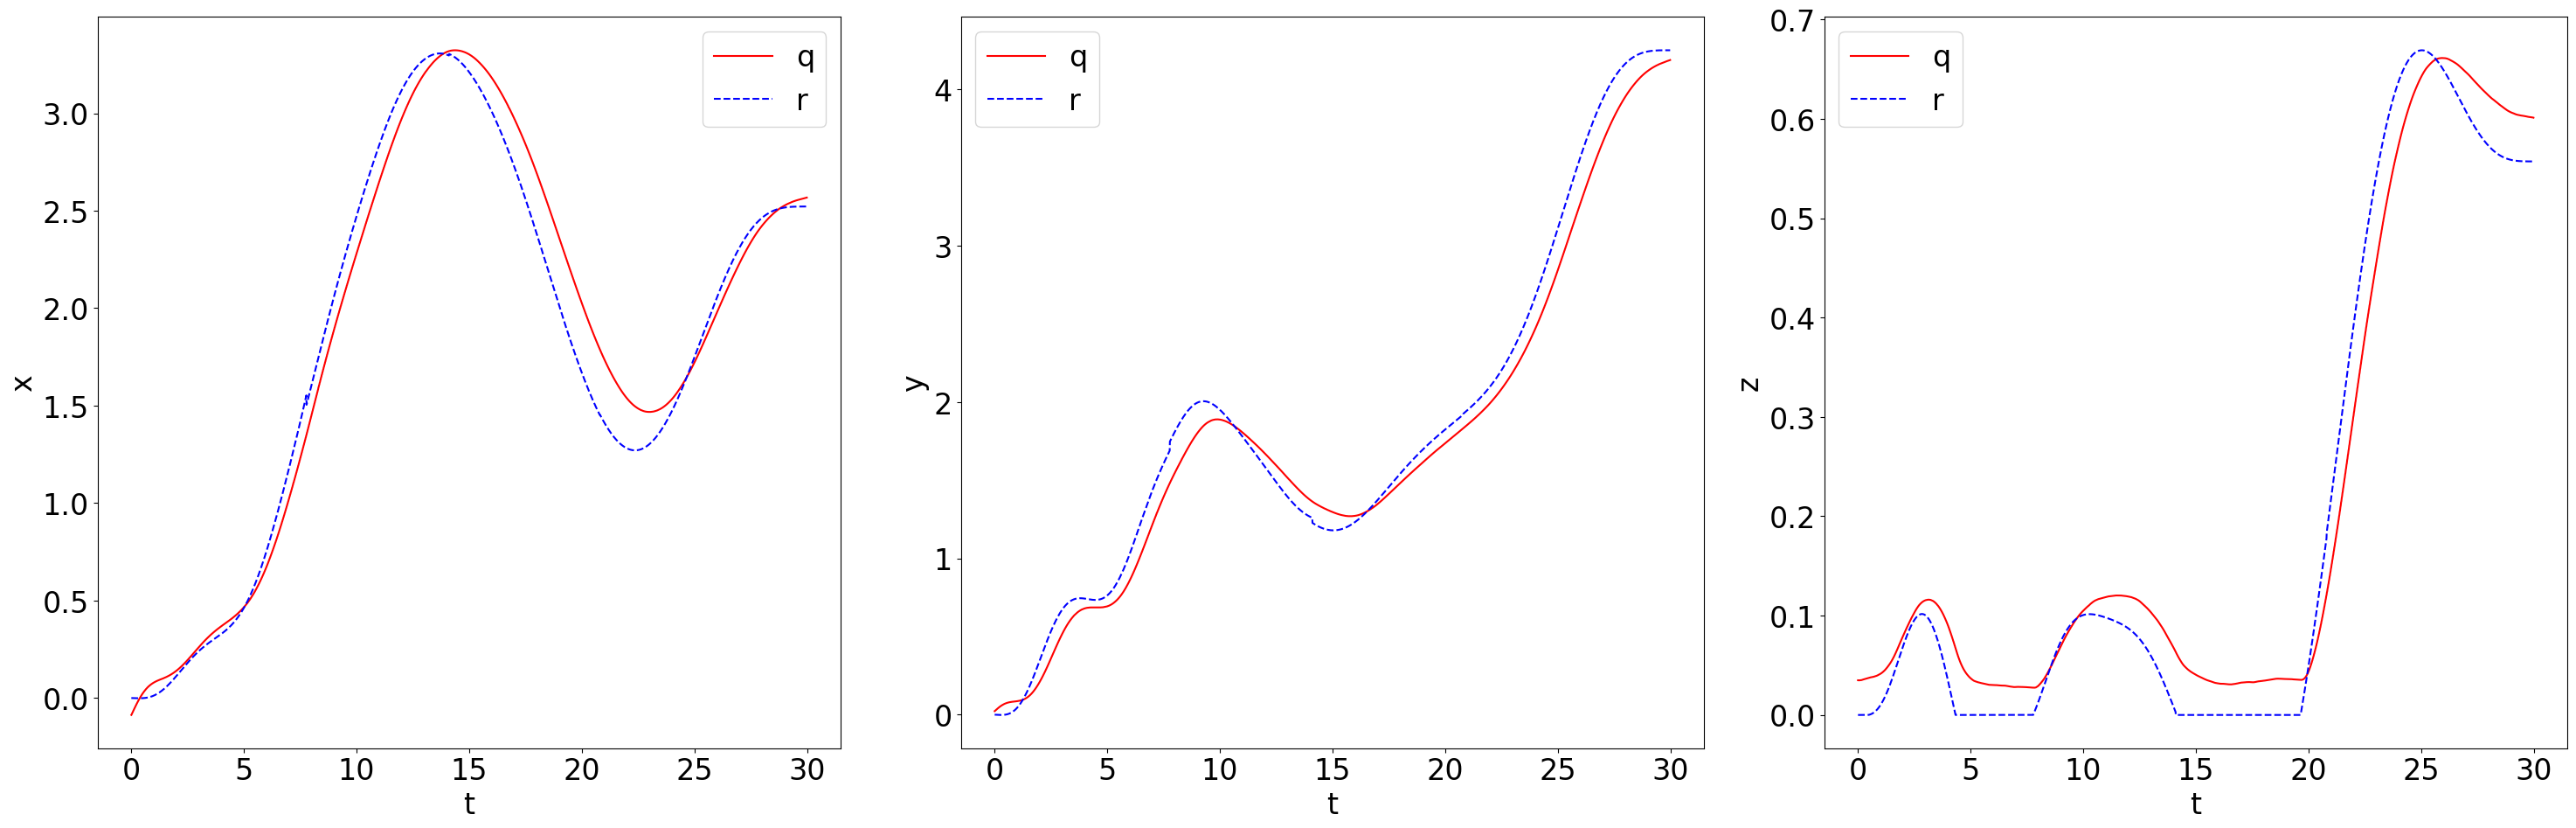

In [2]:
def plot_training_data(filename, traj=0):
    with open(f'data/{filename}', 'rb') as file:
        raw = pickle.load(file)

    num_traj = raw['q'].shape[0]       # total number of raw trajectories
    # ts = jnp.tile(raw['t'][:-1], (num_traj, 1))
    ts = raw['t'][:-1]
    q = raw['q'][traj, :-1]
    dq = raw['dq'][traj, :-1]
    r = raw['r'][traj, :-1]
    dr = raw['dr'][traj, :-1]
    u = raw['u'][traj, :-1, :3]
    quat = raw['quat'][traj, :-1]
    R = jax.vmap(quaternion_to_rotation_matrix, in_axes=0)(quat)
    R_flatten = R.reshape(R.shape[0], R.shape[1], -1)
    omega = raw['omega'][:, :-1]
    data = {'ts': ts, 'q': q, 'dq': dq, 'r': r, 'dr': dr, 'u': u, 'R_flatten': R_flatten, 'omega': omega}

    if os.path.exists('data/figs') == False:
        os.makedirs('data/figs')
        
    fig, ax = plt.subplots(1, 3, figsize=(30, 10))
    ax[0].plot(ts, data['q'][:, 0], 'r-', label='q')
    ax[0].plot(ts, data['r'][:, 0], 'b--', label='r')
    ax[0].set_ylabel('x')
    ax[0].set_xlabel('t')
    ax[0].legend()

    ax[1].plot(ts, data['q'][:, 1], 'r-', label='q')
    ax[1].plot(ts, data['r'][:, 1], 'b--', label='r')
    ax[1].set_ylabel('y')
    ax[1].set_xlabel('t')
    ax[1].legend()

    ax[2].plot(ts, data['q'][:, 2], 'r-', label='q')
    ax[2].plot(ts, data['r'][:, 2], 'b--', label='r')
    ax[2].set_ylabel('z')
    ax[2].set_xlabel('t')
    ax[2].legend()

    fig.tight_layout()
    # fig.savefig('data/figs/tracking_{}'.format(filename.replace('.pkl', '.png')))
    # plt.close(fig)

plot_training_data('2024-04-04_23-51-17_traj50_seed0.pkl', 30)
    

In [119]:
"""
TODO description.

Author: Spencer M. Richards
        Autonomous Systems Lab (ASL), Stanford
        (GitHub: spenrich)
"""

import jax
import jax.numpy as jnp
from jax.scipy.linalg import block_diag
import numpy as np
from functools import partial
from jax.flatten_util import ravel_pytree
import jax.debug as jdebug


@partial(jax.jit, static_argnums=(2, 3))
def _scalar_smooth_trajectory(x_knots, t_knots, poly_order, deriv_order):
    """Construct a smooth trajectory through given points.

    Arguments
    ---------
    x_knots : jax.numpy.ndarray
        TODO.
    t_knots : jax.numpy.ndarray
        TODO.
    poly_order : int
        TODO.
    deriv_order : int
        TODO.

    Returns
    -------
    coefs : jax.numpy.ndarray
        TODO.

    References
    ----------
    .. [1] Charles Richter, Adam Bry, and Nicholas Roy,
           "Polynomial trajectory planning for aggressive quadrotor flight in
           dense indoor environments", ISRR 2013.
    .. [2] Daniel Mellinger and Vijay Kumar,
           "Minimum snap trajectory generation and control for quadrotors",
           ICRA 2011.
    .. [3] Declan Burke, Airlie Chapman, and Iman Shames,
           "Generating minimum-snap quadrotor trajectories really fast",
           IROS 2020.
    """
    num_coefs = poly_order + 1          # number of coefficients per polynomial
    num_knots = x_knots.size            # number of interpolating points
    num_polys = num_knots - 1           # number of polynomials
    primal_dim = num_coefs * num_polys  # number of unknown coefficients

    T = jnp.diff(t_knots)                # polynomial lengths in time
    powers = jnp.arange(poly_order + 1)  # exponents defining each monomial
    D = jnp.diag(powers[1:], -1)         # maps monomials to their derivatives

    c0 = jnp.zeros((deriv_order + 1, num_coefs)).at[0, 0].set(1.)
    c1 = jnp.zeros((deriv_order + 1, num_coefs)).at[0, :].set(1.)
    for n in range(1, deriv_order + 1):
        c0 = c0.at[n].set(D @ c0[n - 1])
        c1 = c1.at[n].set(D @ c1[n - 1])

    # Assemble constraints in the form `A @ x = b`, where `x` is the vector of
    # stacked polynomial coefficients

    # Knots
    b_knots = jnp.concatenate((x_knots[:-1], x_knots[1:]))
    A_knots = jnp.vstack([
        block_diag(*jnp.tile(c0[0], (num_polys, 1))),
        block_diag(*jnp.tile(c1[0], (num_polys, 1)))
    ])

    # Zero initial conditions (velocity, acceleration, jerk)
    b_init = jnp.zeros(deriv_order - 1)
    A_init = jnp.zeros((deriv_order - 1, primal_dim))
    A_init = A_init.at[:deriv_order - 1, :num_coefs].set(c0[1:deriv_order])

    # Zero final conditions (velocity, acceleration, jerk)
    b_fin = jnp.zeros(deriv_order - 1)
    A_fin = jnp.zeros((deriv_order - 1, primal_dim))
    A_fin = A_fin.at[:deriv_order - 1, -num_coefs:].set(c1[1:deriv_order])

    # Continuity (velocity, acceleration, jerk, snap)
    b_cont = jnp.zeros(deriv_order * (num_polys - 1))
    As = []
    zero_pad = jnp.zeros((num_polys - 1, num_coefs))
    Tn = jnp.ones_like(T)
    for n in range(1, deriv_order + 1):
        Tn = T * Tn
        diag_c0 = block_diag(*(c0[n] / Tn[1:].reshape([-1, 1])))
        diag_c1 = block_diag(*(c1[n] / Tn[:-1].reshape([-1, 1])))
        As.append(jnp.hstack((diag_c1, zero_pad))
                  - jnp.hstack((zero_pad, diag_c0)))
    A_cont = jnp.vstack(As)

    # Assemble
    A = jnp.vstack((A_knots, A_init, A_fin, A_cont))
    b = jnp.concatenate((b_knots, b_init, b_fin, b_cont))
    dual_dim = b.size

    # Compute the cost Hessian `Q(T)` as a function of the length `T` for each
    # polynomial, and stack them into the full block-diagonal Hessian
    ij_1 = powers.reshape([-1, 1]) + powers + 1
    D_snap = jnp.linalg.matrix_power(D, deriv_order)
    Q_snap = D_snap @ (1 / ij_1) @ D_snap.T
    Q_poly = lambda T: Q_snap / (T**(2*deriv_order - 1))  # noqa: E731
    Q = block_diag(*jax.vmap(Q_poly)(T))

    # Assemble KKT system and solve for coefficients
    K = jnp.block([
        [Q, A.T],
        [A, jnp.zeros((dual_dim, dual_dim))]
    ])
    soln = jnp.linalg.solve(K, jnp.concatenate((jnp.zeros(primal_dim), b)))
    primal, dual = soln[:primal_dim], soln[-dual_dim:]
    coefs = primal.reshape((num_polys, -1))
    r_primal = A@primal - b
    r_dual = Q@primal + A.T@dual
    return coefs, r_primal, r_dual


@partial(jax.jit, static_argnums=(2, 3))
def smooth_trajectory(x_knots, t_knots, poly_order, deriv_order):
    """TODO: docstring."""
    # TODO: shape checking
    num_knots = x_knots.shape[0]
    knot_shape = x_knots.shape[1:]
    flat_x_knots = jnp.reshape(x_knots, (num_knots, -1))
    in_axes = (1, None, None, None)
    out_axes = (2, 1, 1)
    flat_coefs, _, _ = jax.vmap(_scalar_smooth_trajectory,
                                in_axes, out_axes)(flat_x_knots, t_knots,
                                                   poly_order, deriv_order)
    num_polys = num_knots - 1
    coefs = jnp.reshape(flat_coefs, (num_polys, poly_order + 1, *knot_shape))
    return coefs


@jax.jit
def spline(t, t_knots, coefs):
    """Compute the value of a polynomial spline at time `t`."""
    num_polys = coefs.shape[0]
    poly_order = coefs.shape[1] - 1
    powers = jnp.arange(poly_order + 1)
    i = jnp.clip(jnp.searchsorted(t_knots, t, side='left') - 1,
                 0, num_polys - 1)
    tau = (t - t_knots[i]) / (t_knots[i+1] - t_knots[i])
    #x = jnp.tensordot(coefs[i], tau**powers, axes=(0, 0))
    x = 0.0
    for p, c in enumerate(coefs[i]):
        x += c * (tau**p)

    return x


def uniform_random_walk(key, num_steps, shape=(), min_step=0., max_step=1.):
    """TODO: docstring."""
    minvals = jnp.broadcast_to(min_step, shape)
    maxvals = jnp.broadcast_to(max_step, shape)
    noise = minvals + (maxvals - minvals)*jax.random.uniform(key, (num_steps,
                                                                   *shape))
    # start_point = jnp.array([0., 0., 1.])
    # points = jnp.concatenate((start_point.reshape(1, *shape),
    #                           jnp.cumsum(noise, axis=0)), axis=0)
    points = jnp.concatenate((jnp.zeros((1, *shape)),
                              jnp.cumsum(noise, axis=0)), axis=0)
    return points

def normalize_diffs_if_needed(normalized_diffs):
    def true_fun(_):
        return normalized_diffs / jnp.sum(normalized_diffs)
    def false_fun(_):
        return normalized_diffs
    return jax.lax.cond(
        jnp.sum(normalized_diffs) > 1,
        true_fun,
        false_fun,
        operand=None
    )

def random_ragged_spline(key, T_total, num_knots, poly_orders, deriv_orders,
                         min_step, max_step, min_knot, max_knot):
    """TODO: docstring."""
    poly_orders = np.array(poly_orders).ravel().astype(int)
    deriv_orders = np.array(deriv_orders).ravel().astype(int)
    num_dims = poly_orders.size
    assert deriv_orders.size == num_dims
    shape = (num_dims,)
    knots = uniform_random_walk(key, num_knots - 1, shape, min_step, max_step)
    knots = jnp.clip(knots, min_knot, max_knot)
    flat_knots = jnp.reshape(knots, (num_knots, -1))
    diffs = jnp.linalg.norm(jnp.diff(flat_knots, axis=0), axis=1)
    normalized_diffs = diffs / jnp.sum(diffs)

    lower_bound = 0.1

    # Ensure that each normalized time interval is above the lower bound
    normalized_diffs = jnp.maximum(normalized_diffs, lower_bound)

    # If the adjustment above made the total exceed 1, re-normalize the diffs
    normalized_diffs = normalize_diffs_if_needed(normalized_diffs)

    T = T_total * normalized_diffs
    t_knots = jnp.concatenate((jnp.array([0., ]),
                               jnp.cumsum(T))).at[-1].set(T_total)
    coefs = []
    for i, (p, d) in enumerate(zip(poly_orders, deriv_orders)):
        coefs.append(smooth_trajectory(knots[:, i], t_knots, p, d))
    coefs = tuple(coefs)
    knots = tuple(knots[:, i] for i in range(num_dims))
    return t_knots, knots, coefs

In [3]:
# Seed random numbers
seed = 0
key = jax.random.PRNGKey(seed)

xmin_ = -4.25
xmax_ = 4.5
ymin_ = -3.5
ymax_ = 4.25
zmin_ = 0.0
zmax_ = 2.0

# xmin_ = -jnp.inf
# xmax_ = jnp.inf
# ymin_ = -jnp.inf
# ymax_ = jnp.inf
# zmin_ = -jnp.inf
# zmax_ = jnp.inf

# Generate smooth trajectories
T = 30
num_traj = 50
num_knots = 6
poly_orders = (9, 9, 9)
deriv_orders = (4, 4, 4)
min_step = jnp.array([-2, -2, -0.25])
max_step = jnp.array([2, 2, 0.25])
min_knot = jnp.array([xmin_, ymin_, zmin_-1])
max_knot = jnp.array([xmax_, ymax_, zmax_-1])

key, *subkeys = jax.random.split(key, 1 + num_traj)
subkeys = jnp.vstack(subkeys)
in_axes = (0, None, None, None, None, None, None, None, None)
t_knots, knots, coefs = jax.vmap(random_ragged_spline, in_axes)(
    subkeys, T, num_knots, poly_orders, deriv_orders,
    min_step, max_step, min_knot, max_knot
)
r_knots = jnp.dstack(knots)

def generate_trajectory():

    # Sampled-time simulator
    @partial(jax.vmap, in_axes=(None, 0, 0))
    def simulate(ts, t_knots, coefs):
        """TODO: docstring."""
        # Construct spline reference trajectory
        def reference(t):
            x_coefs, y_coefs, z_coefs = coefs
            x = spline(t, t_knots, x_coefs)
            y = spline(t, t_knots, y_coefs)
            z = spline(t, t_knots, z_coefs) + 1.
            r = jnp.array([x, y, z])
            return r

        # Required derivatives of the reference trajectory
        def ref_derivatives(t):
            ref_vel = jax.jacfwd(reference)
            ref_acc = jax.jacfwd(ref_vel)
            r = reference(t)
            dr = ref_vel(t)
            ddr = ref_acc(t)
            return r, dr, ddr

        # Simulation loop
        def loop(carry, input_slice):
            t_prev = carry
            t = input_slice

            r, dr, ddr = ref_derivatives(t)
            carry = (t)
            output_slice = (r, dr, ddr)
            return carry, output_slice

        # Initial conditions
        t0 = ts[0]
        r0, dr0, ddr0 = ref_derivatives(t0)
        
        # Run simulation loop
        carry = (t0)
        carry, output = jax.lax.scan(loop, carry, ts[1:])
        r, dr, ddr = output

        # Prepend initial conditions
        r = jnp.vstack((r0, r))
        dr = jnp.vstack((dr0, dr))
        ddr = jnp.vstack((ddr0, ddr))

        return r, dr, ddr
    
    dt = 0.01
    t = jnp.arange(0, T + dt, dt)  # same times for each trajectory
    r, dr, ddr = simulate(t, t_knots, coefs)
    return t, r, dr, ddr

ts, r, dr, ddr = generate_trajectory()

/var/folders/5k/37x_xxv96r7cyxvsm7d90fhh0000gn/T/ipykernel_70745/1843615959.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 3, figsize=(30, 10))


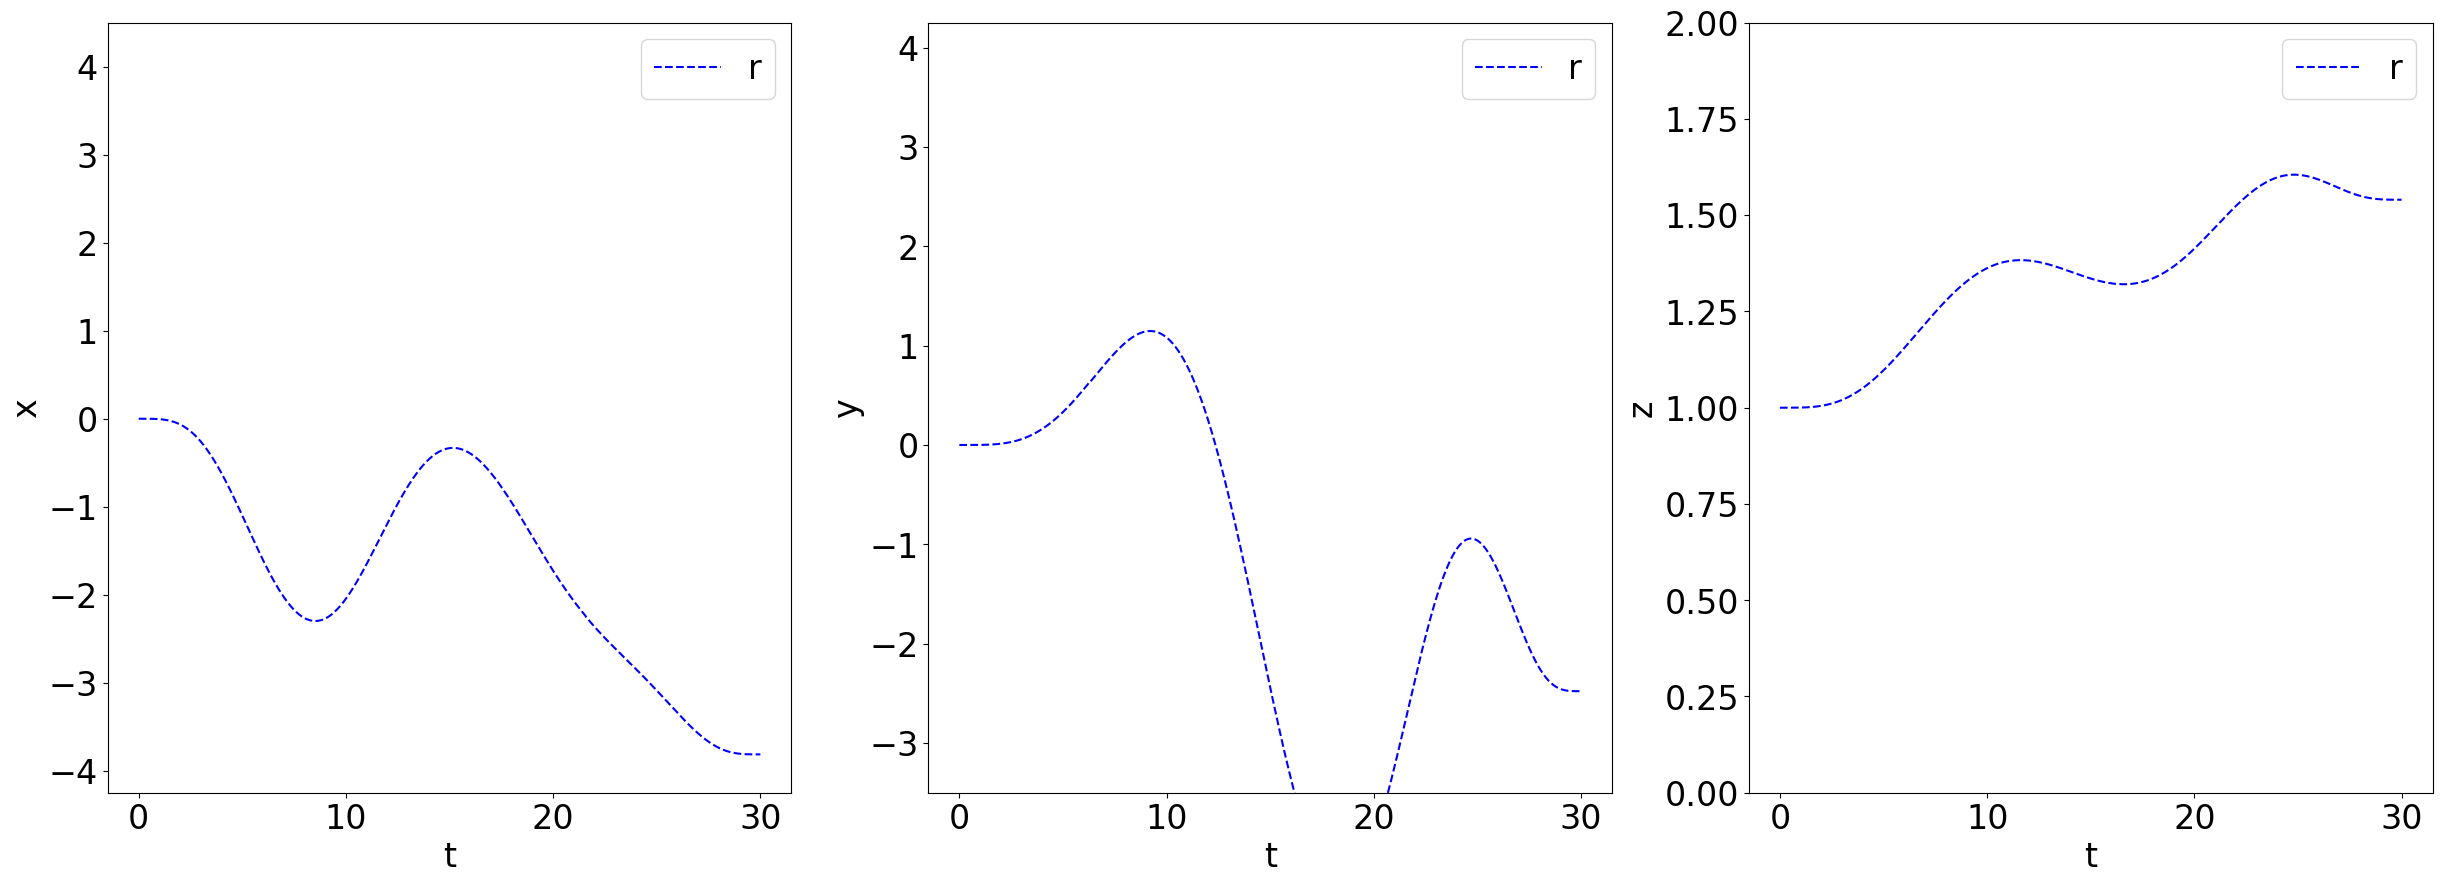

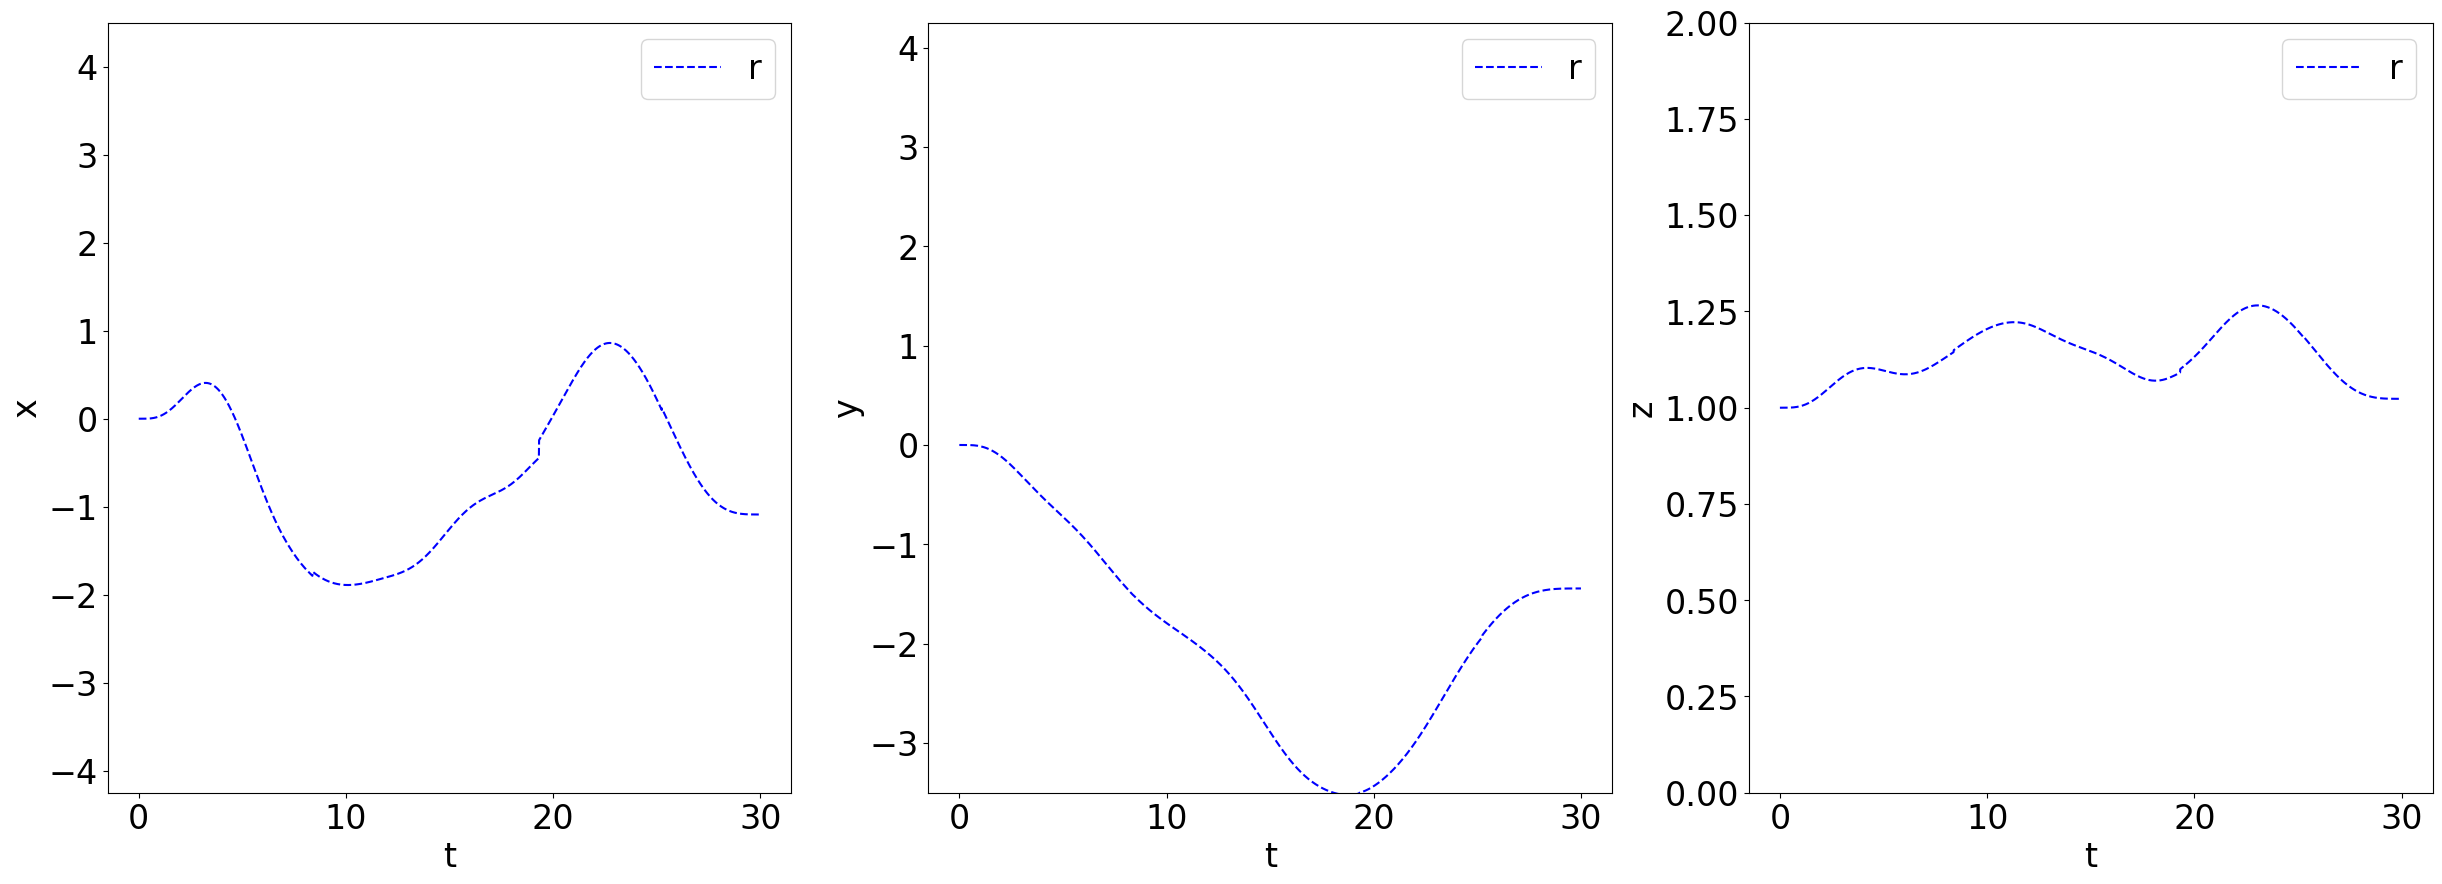

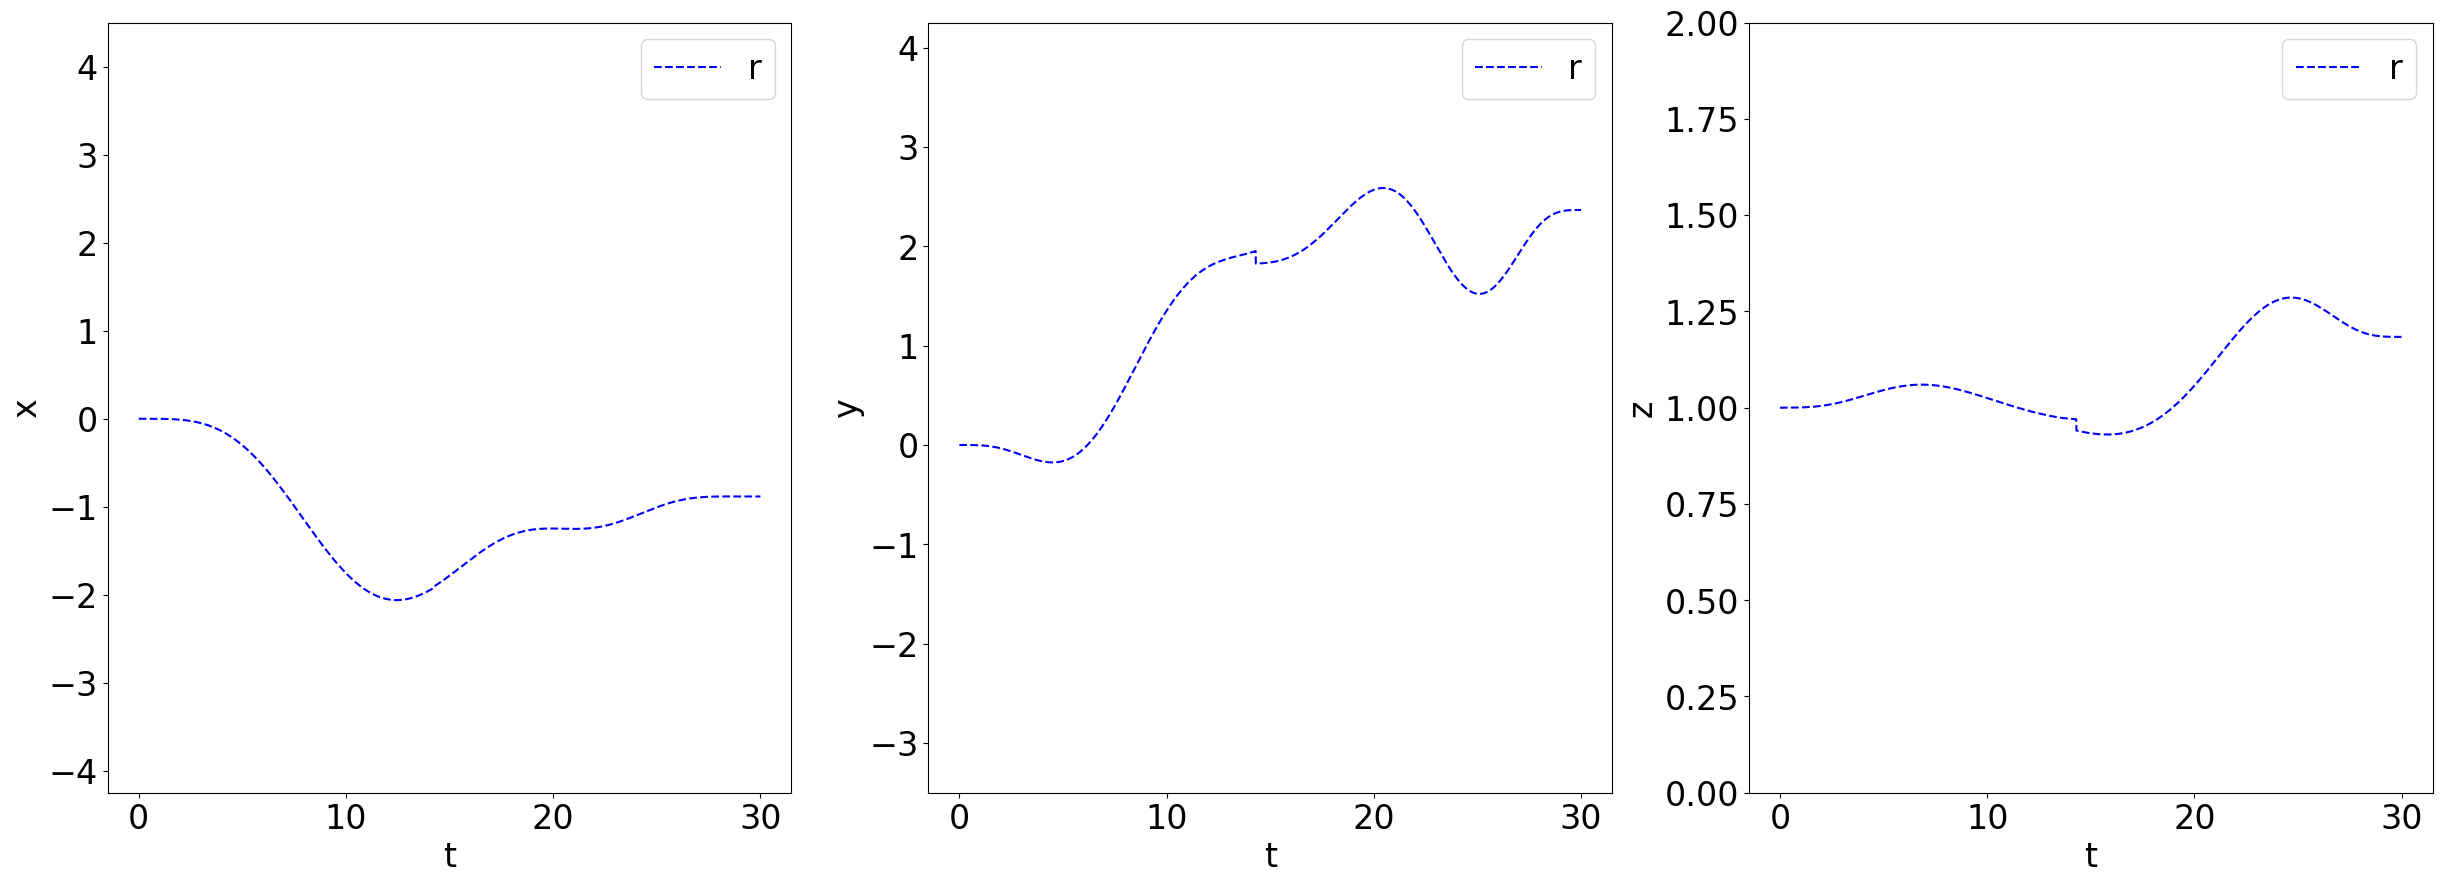

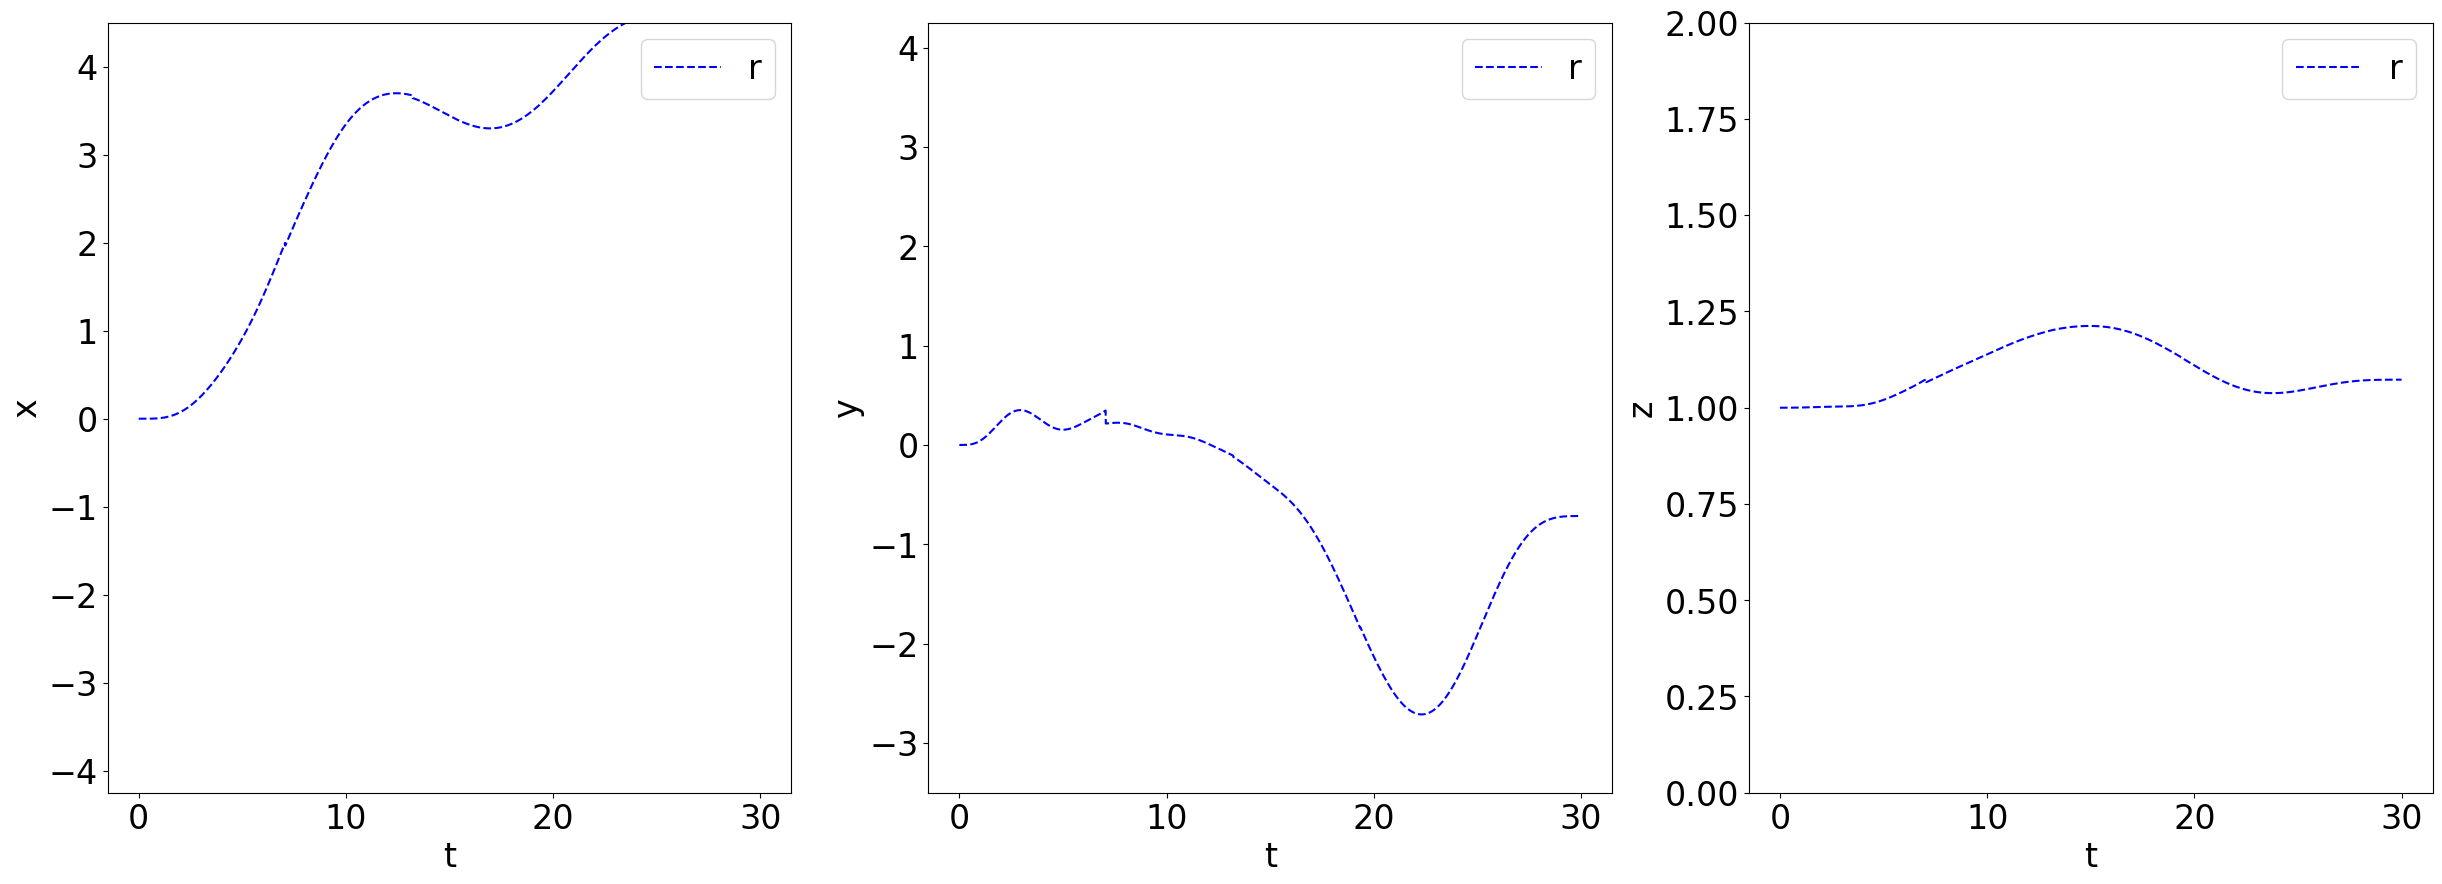

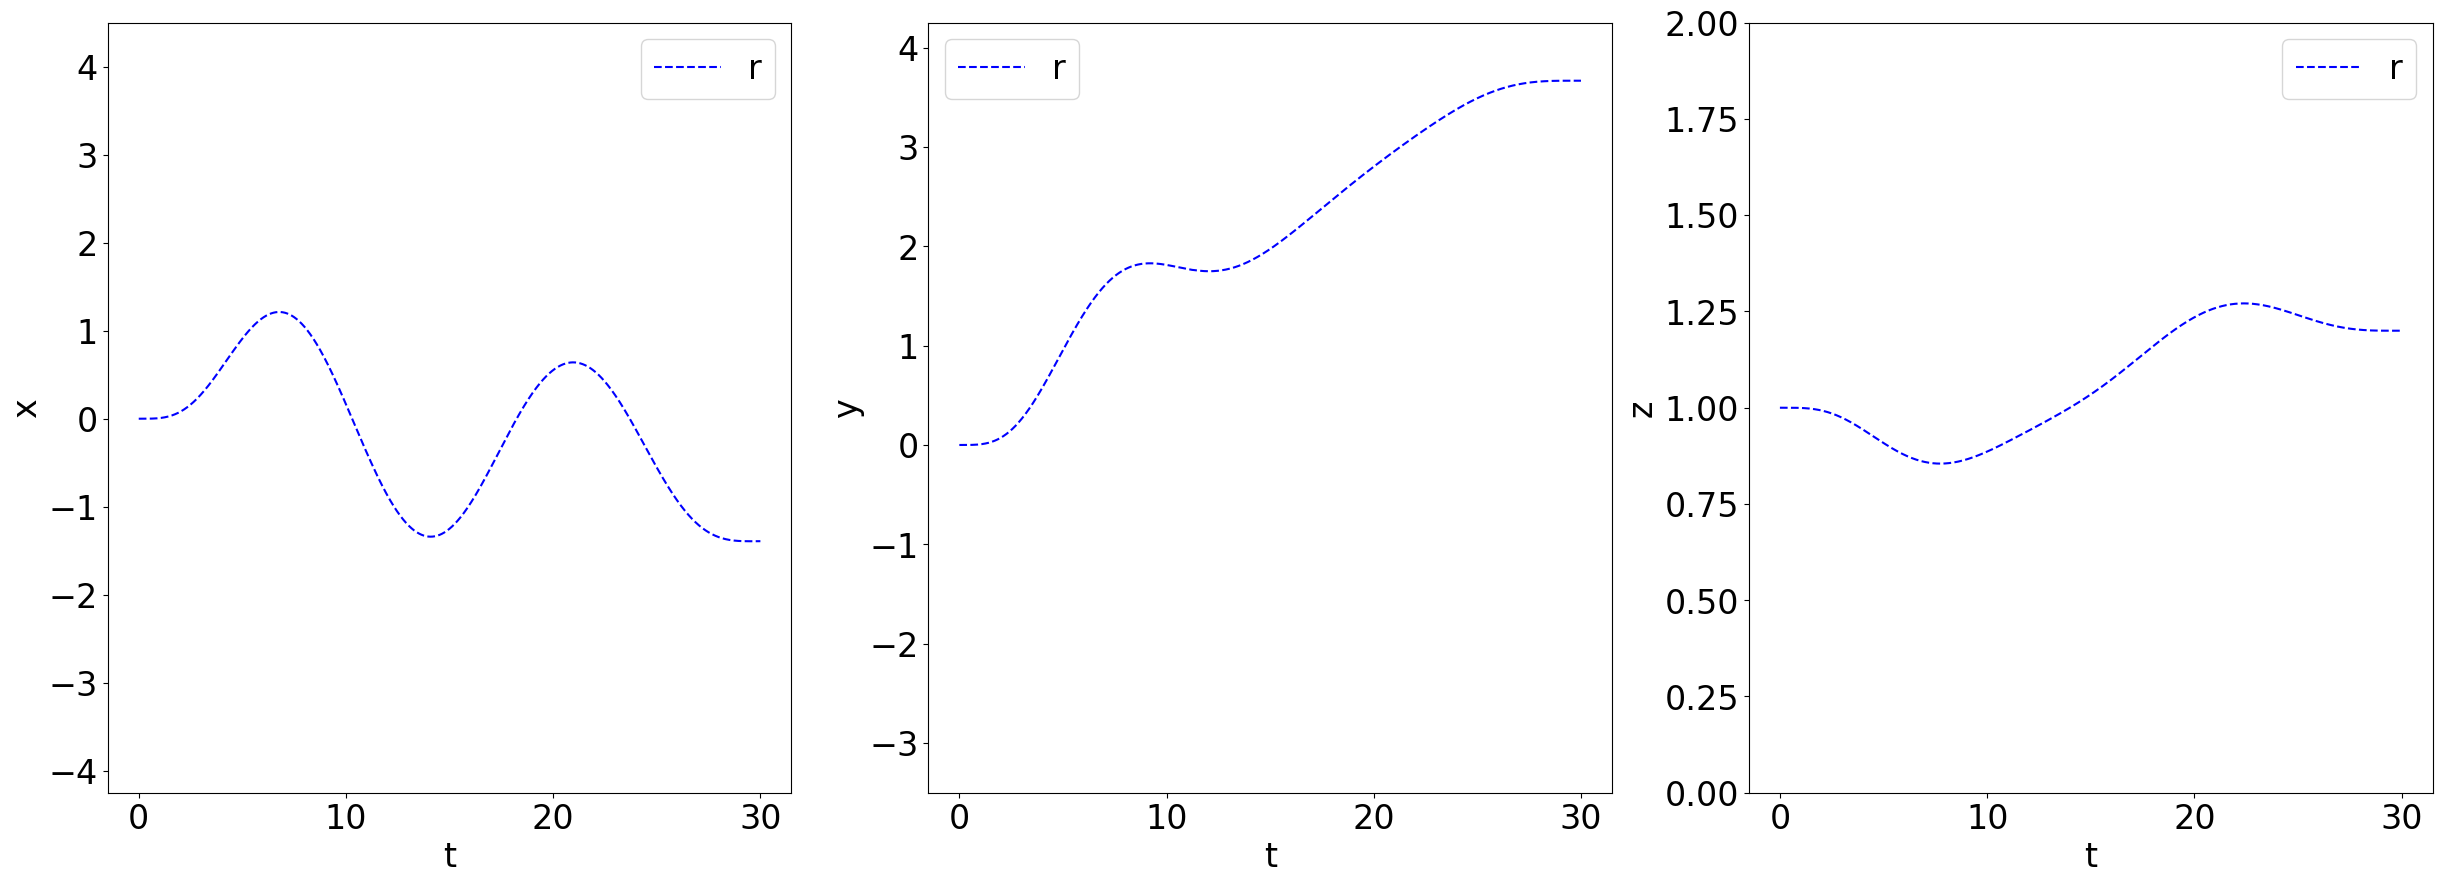

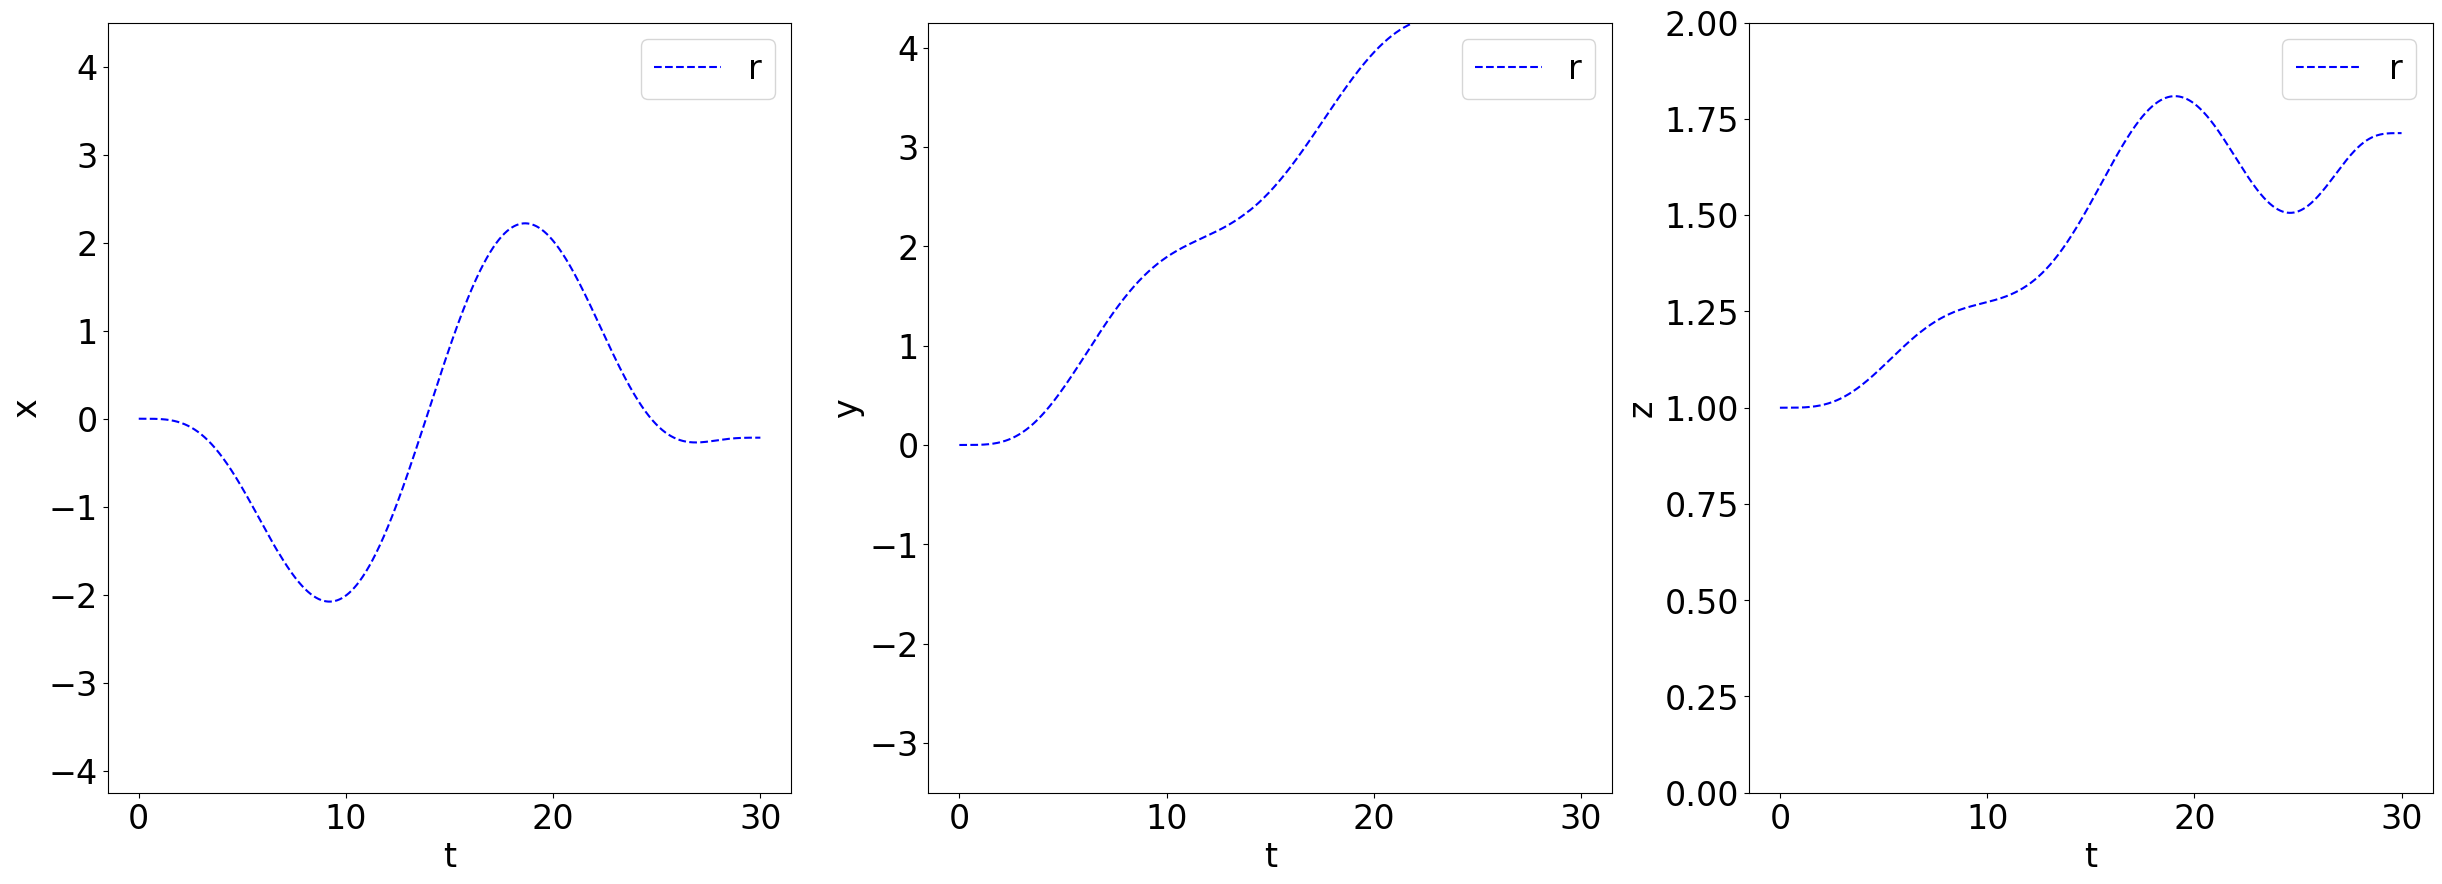

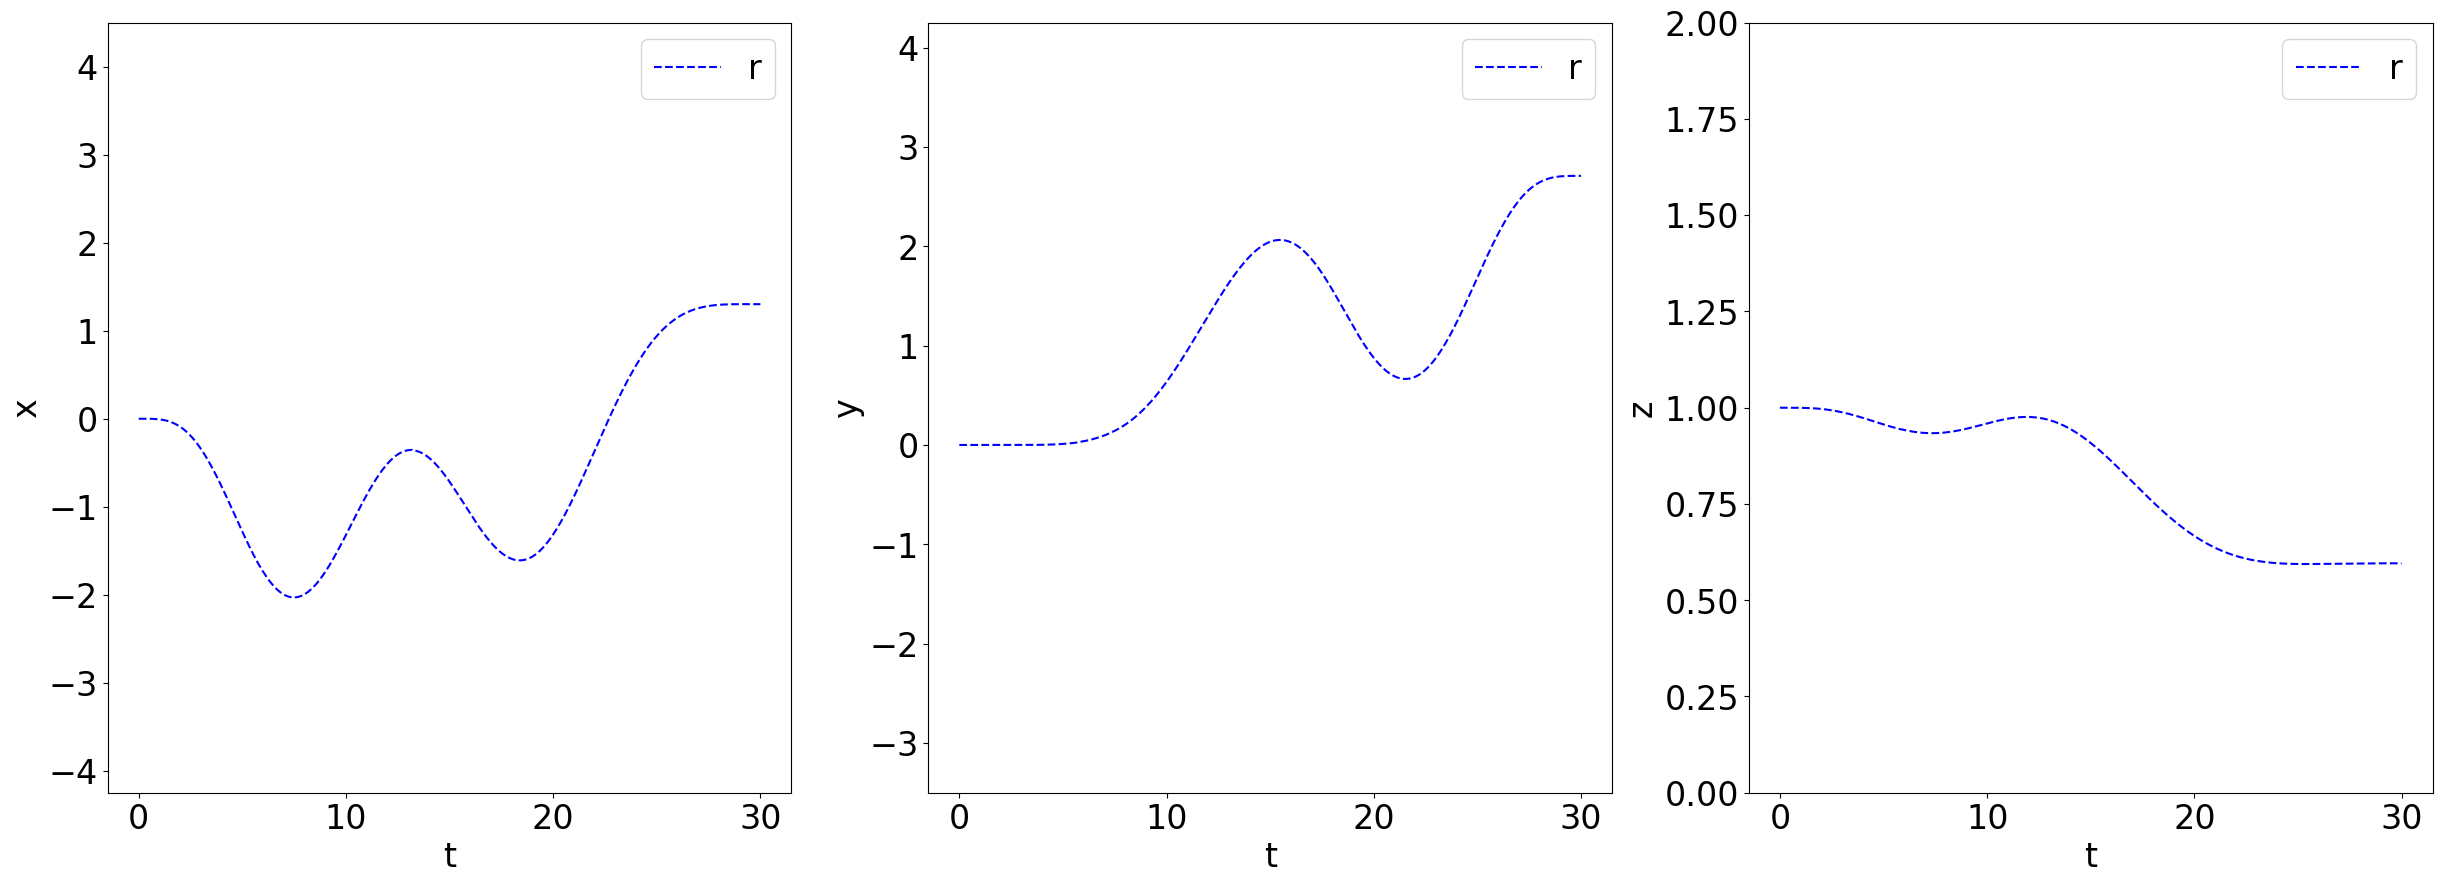

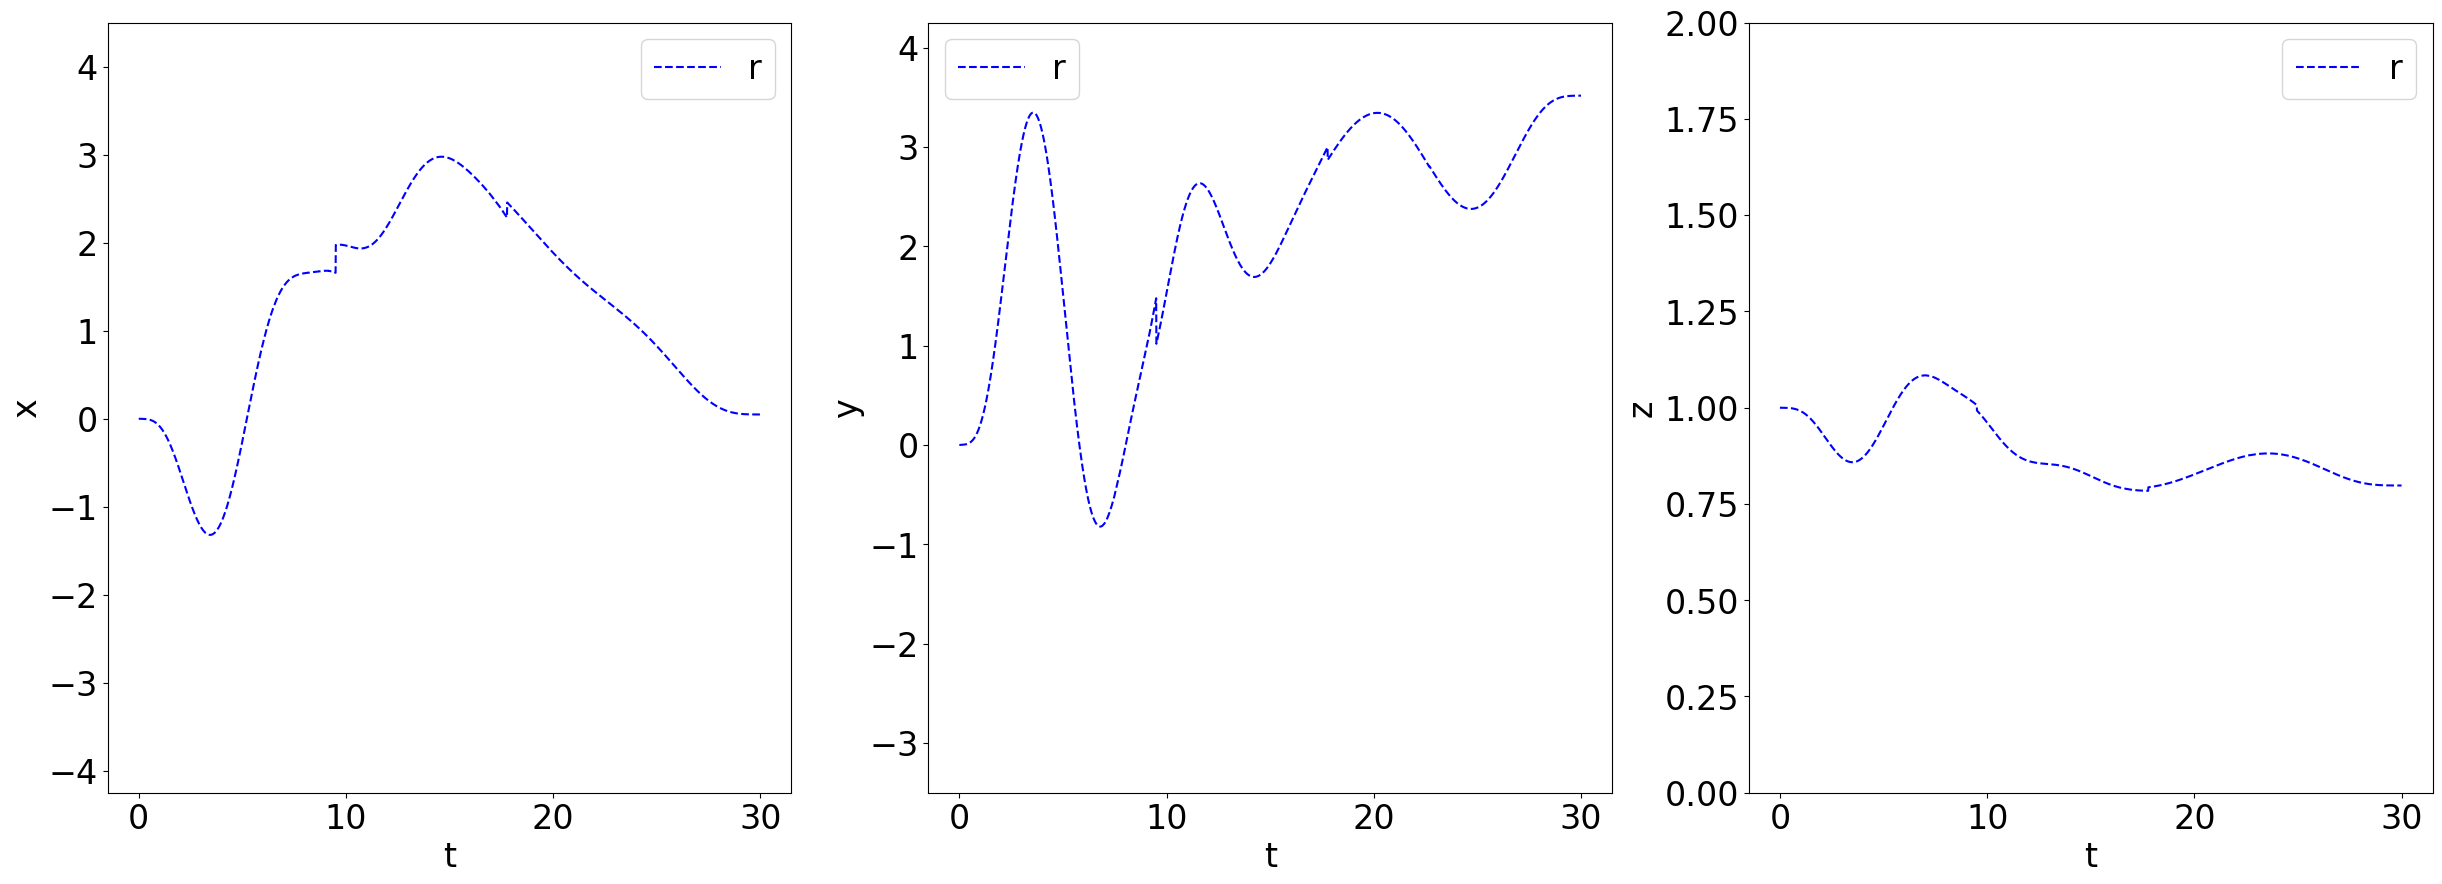

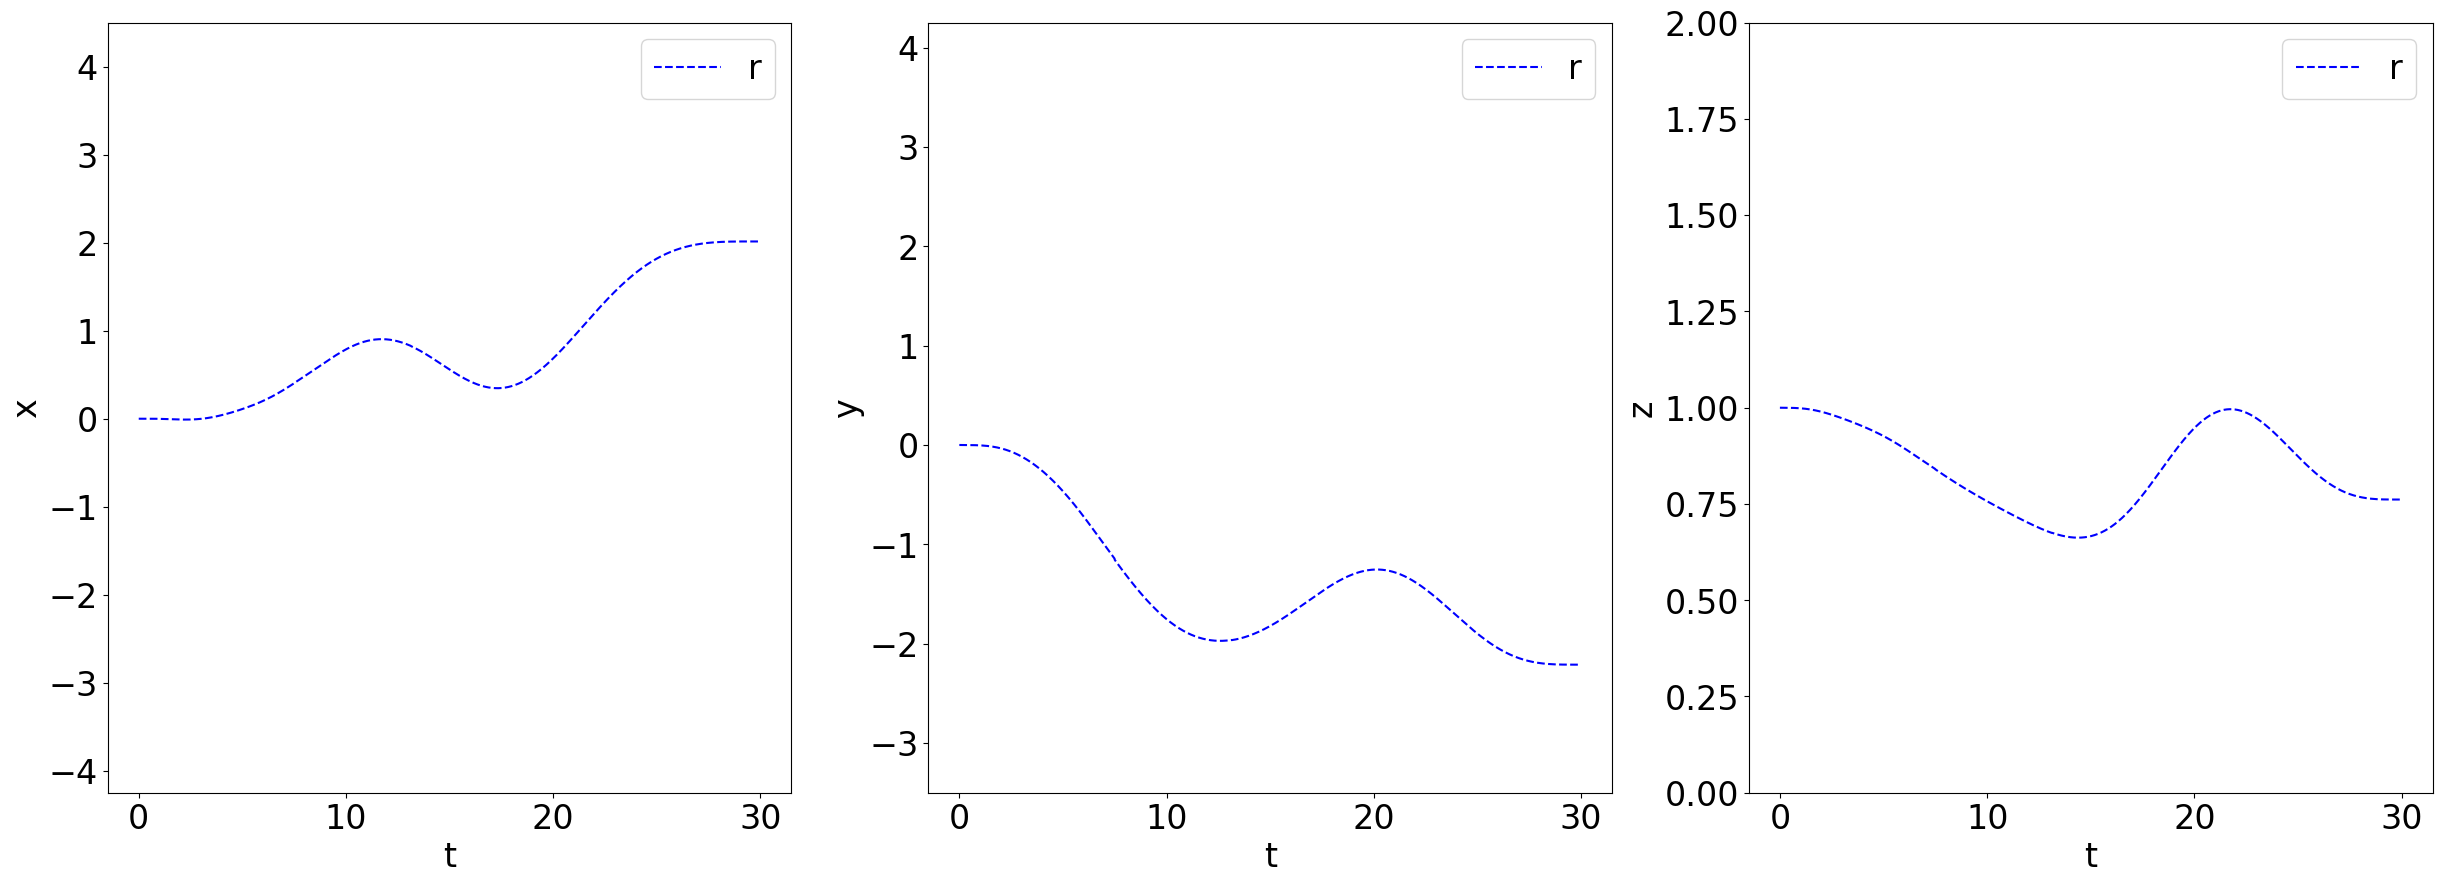

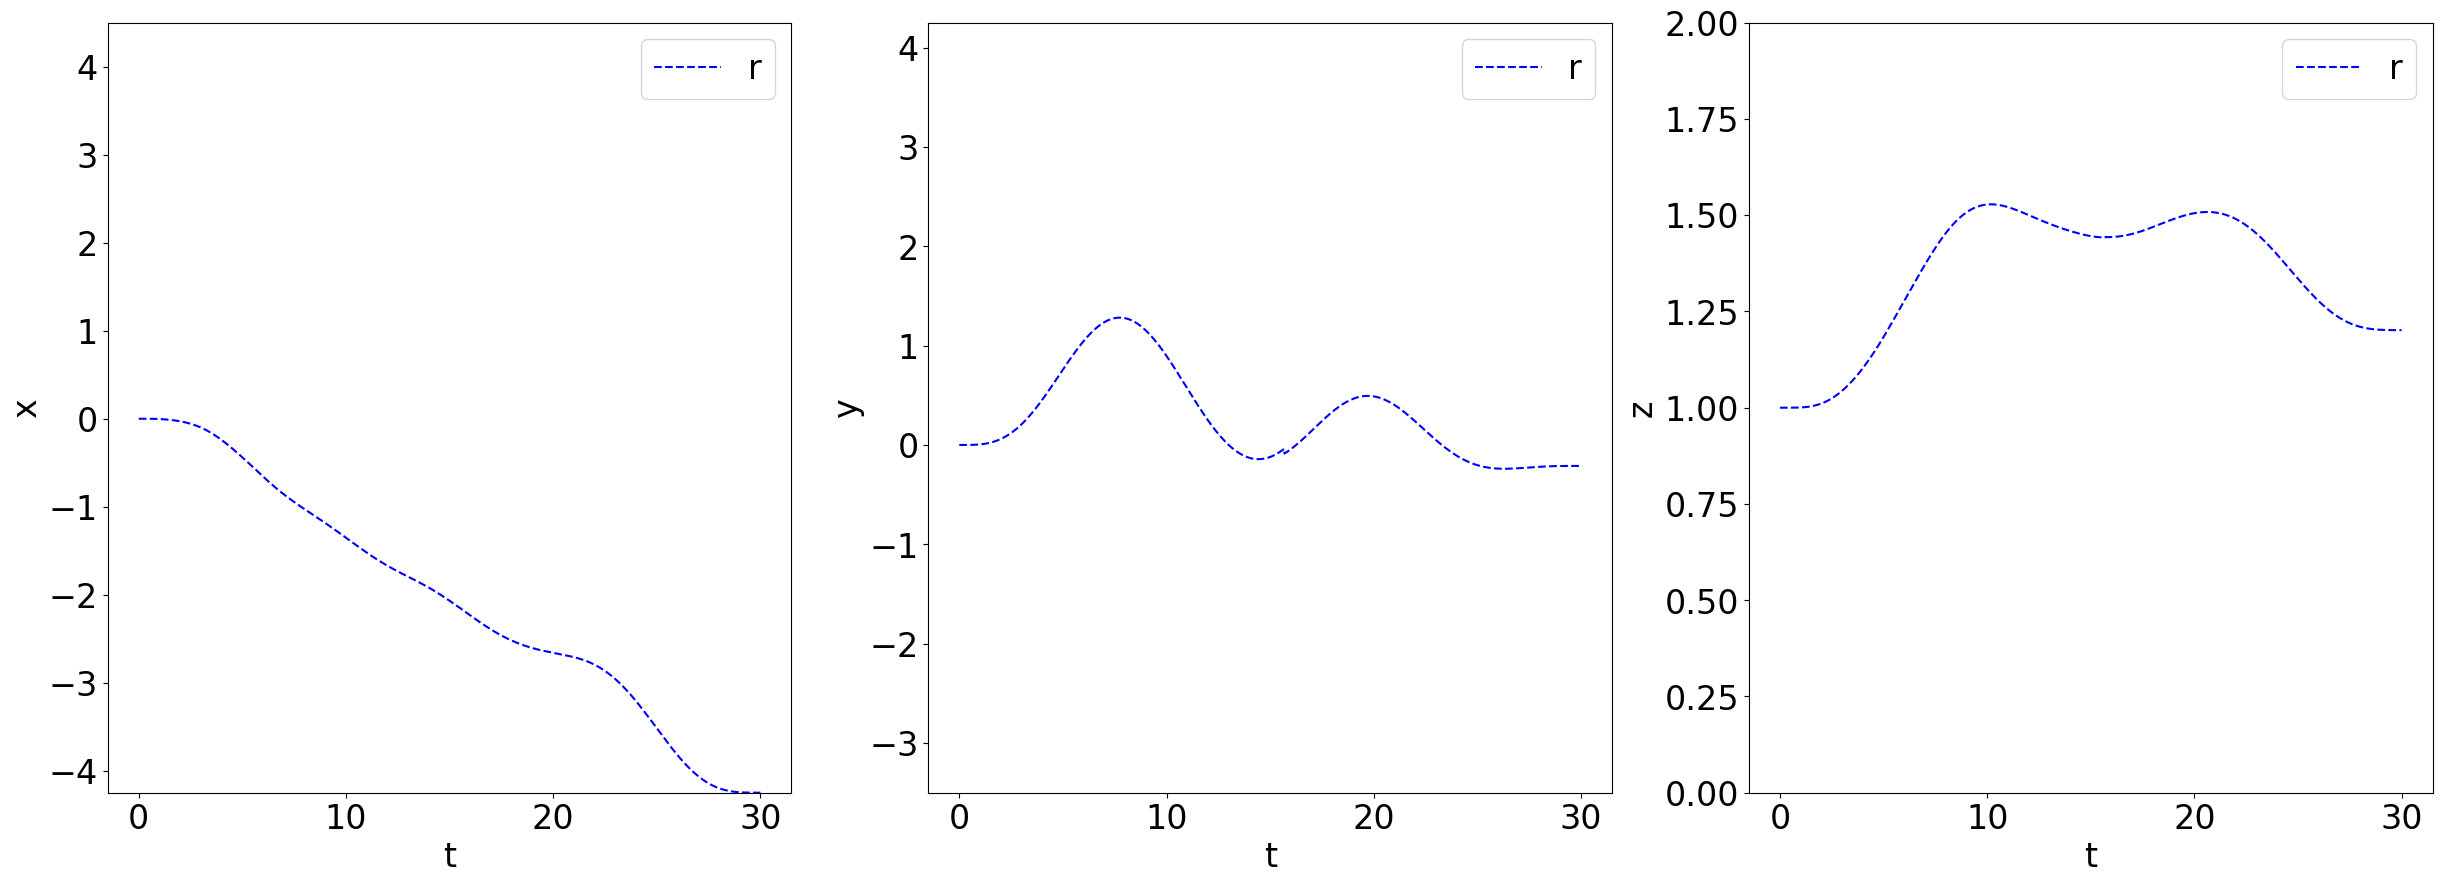

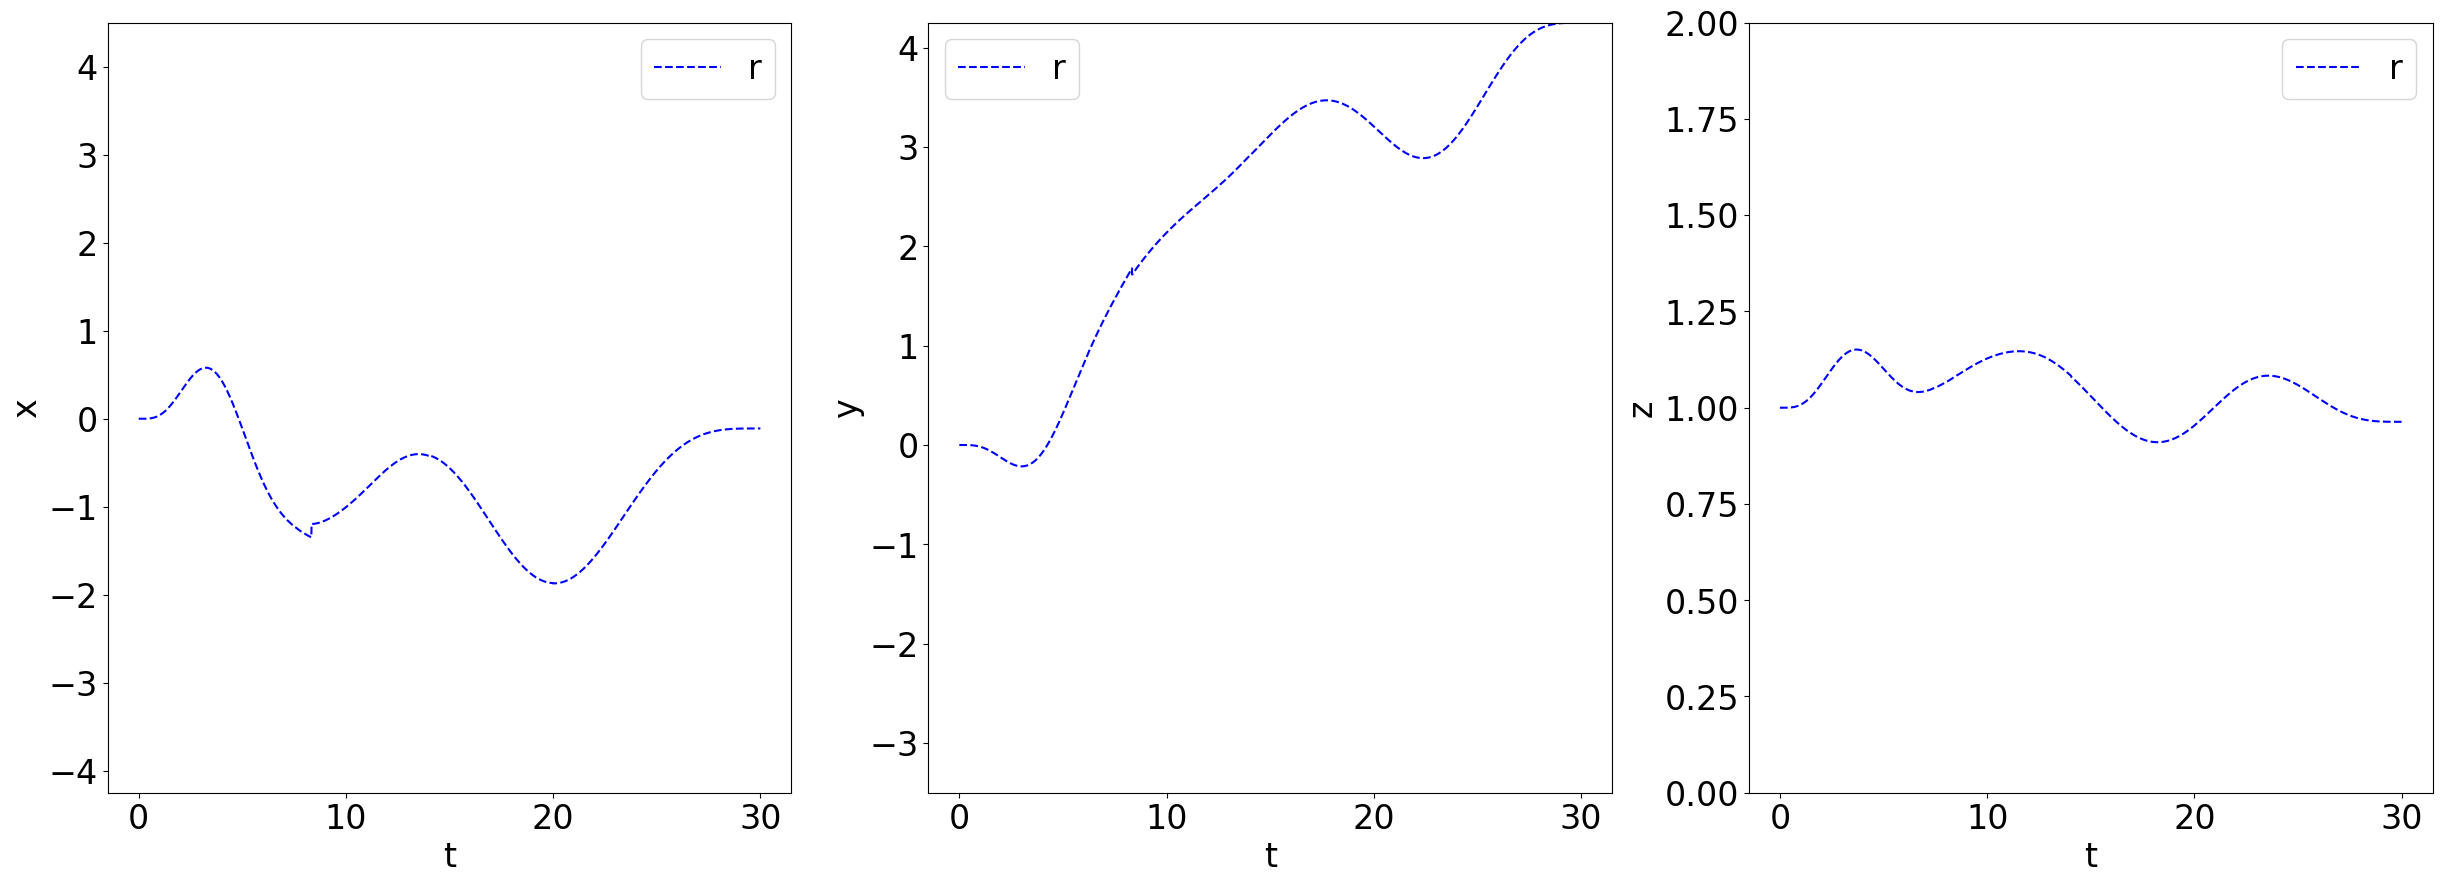

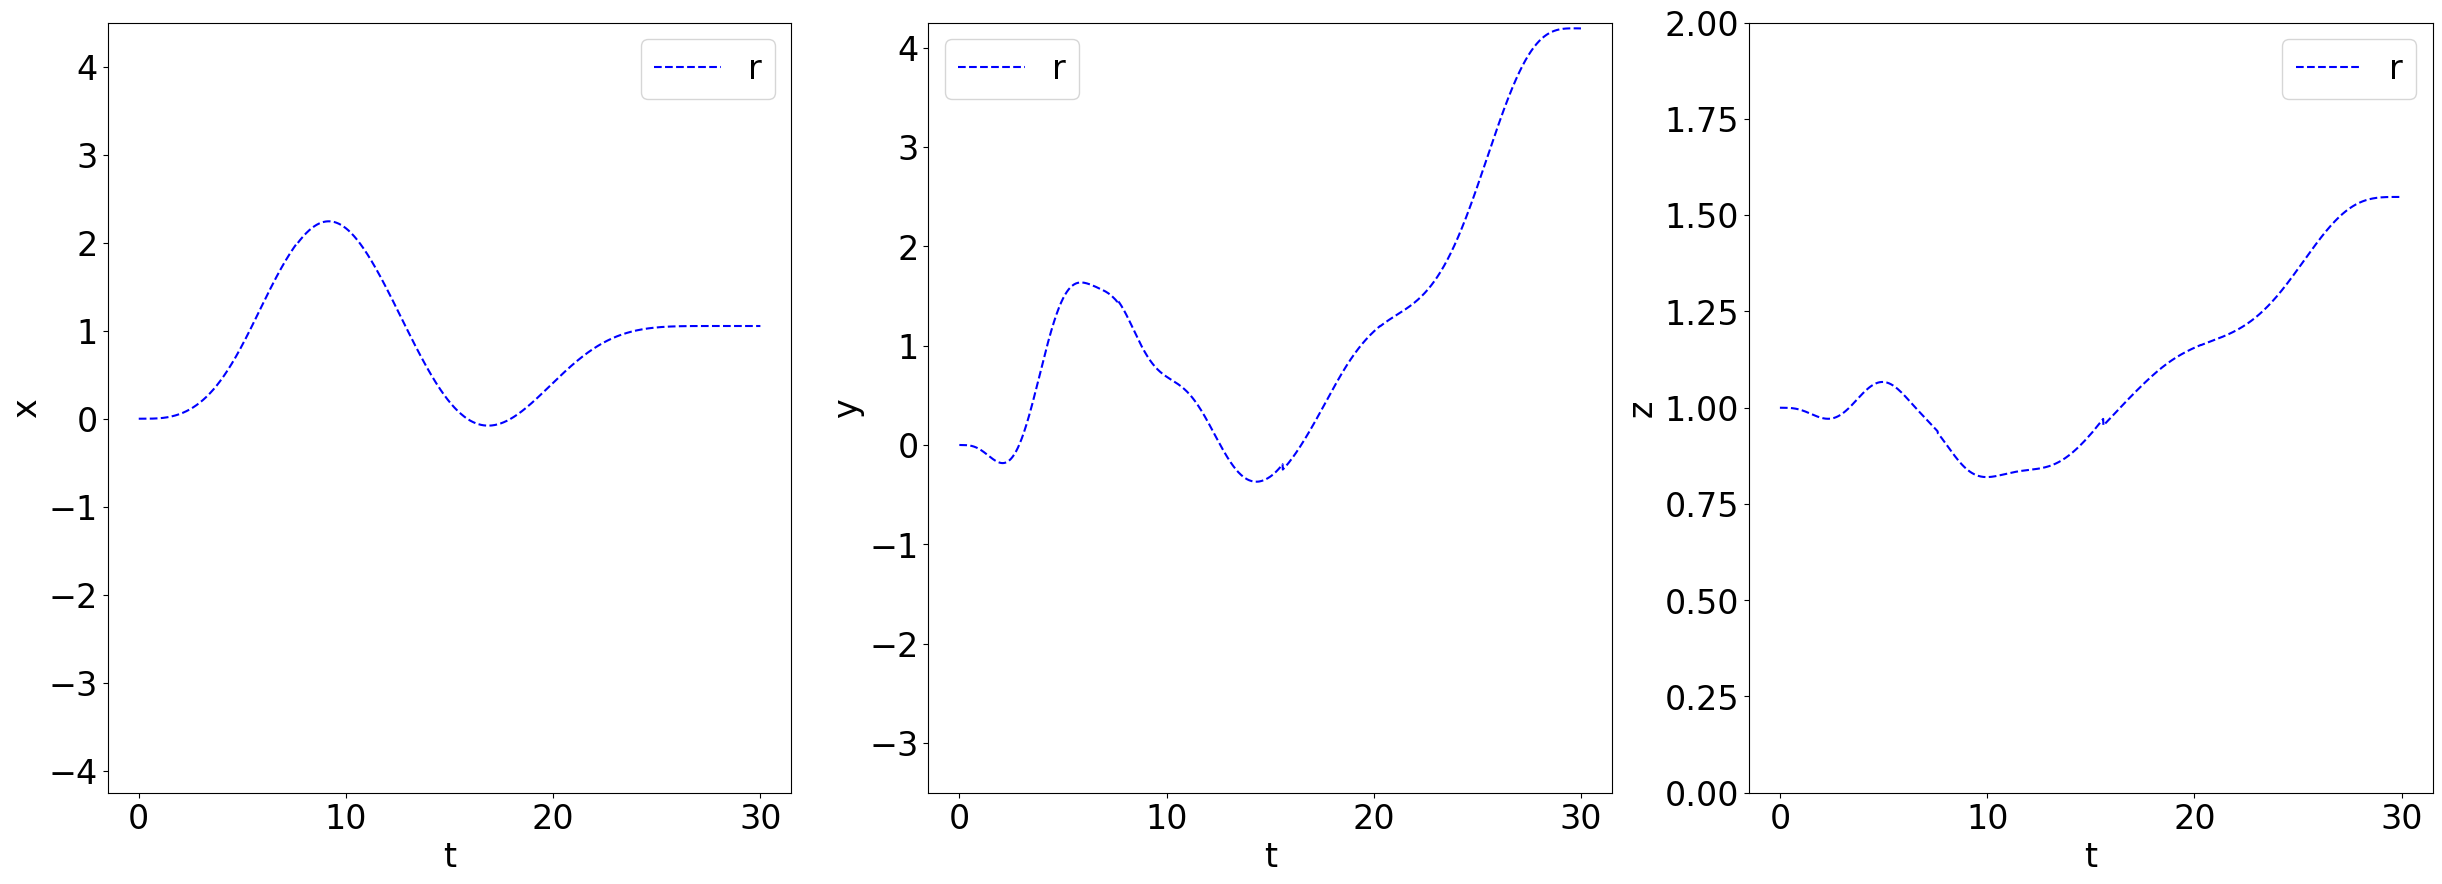

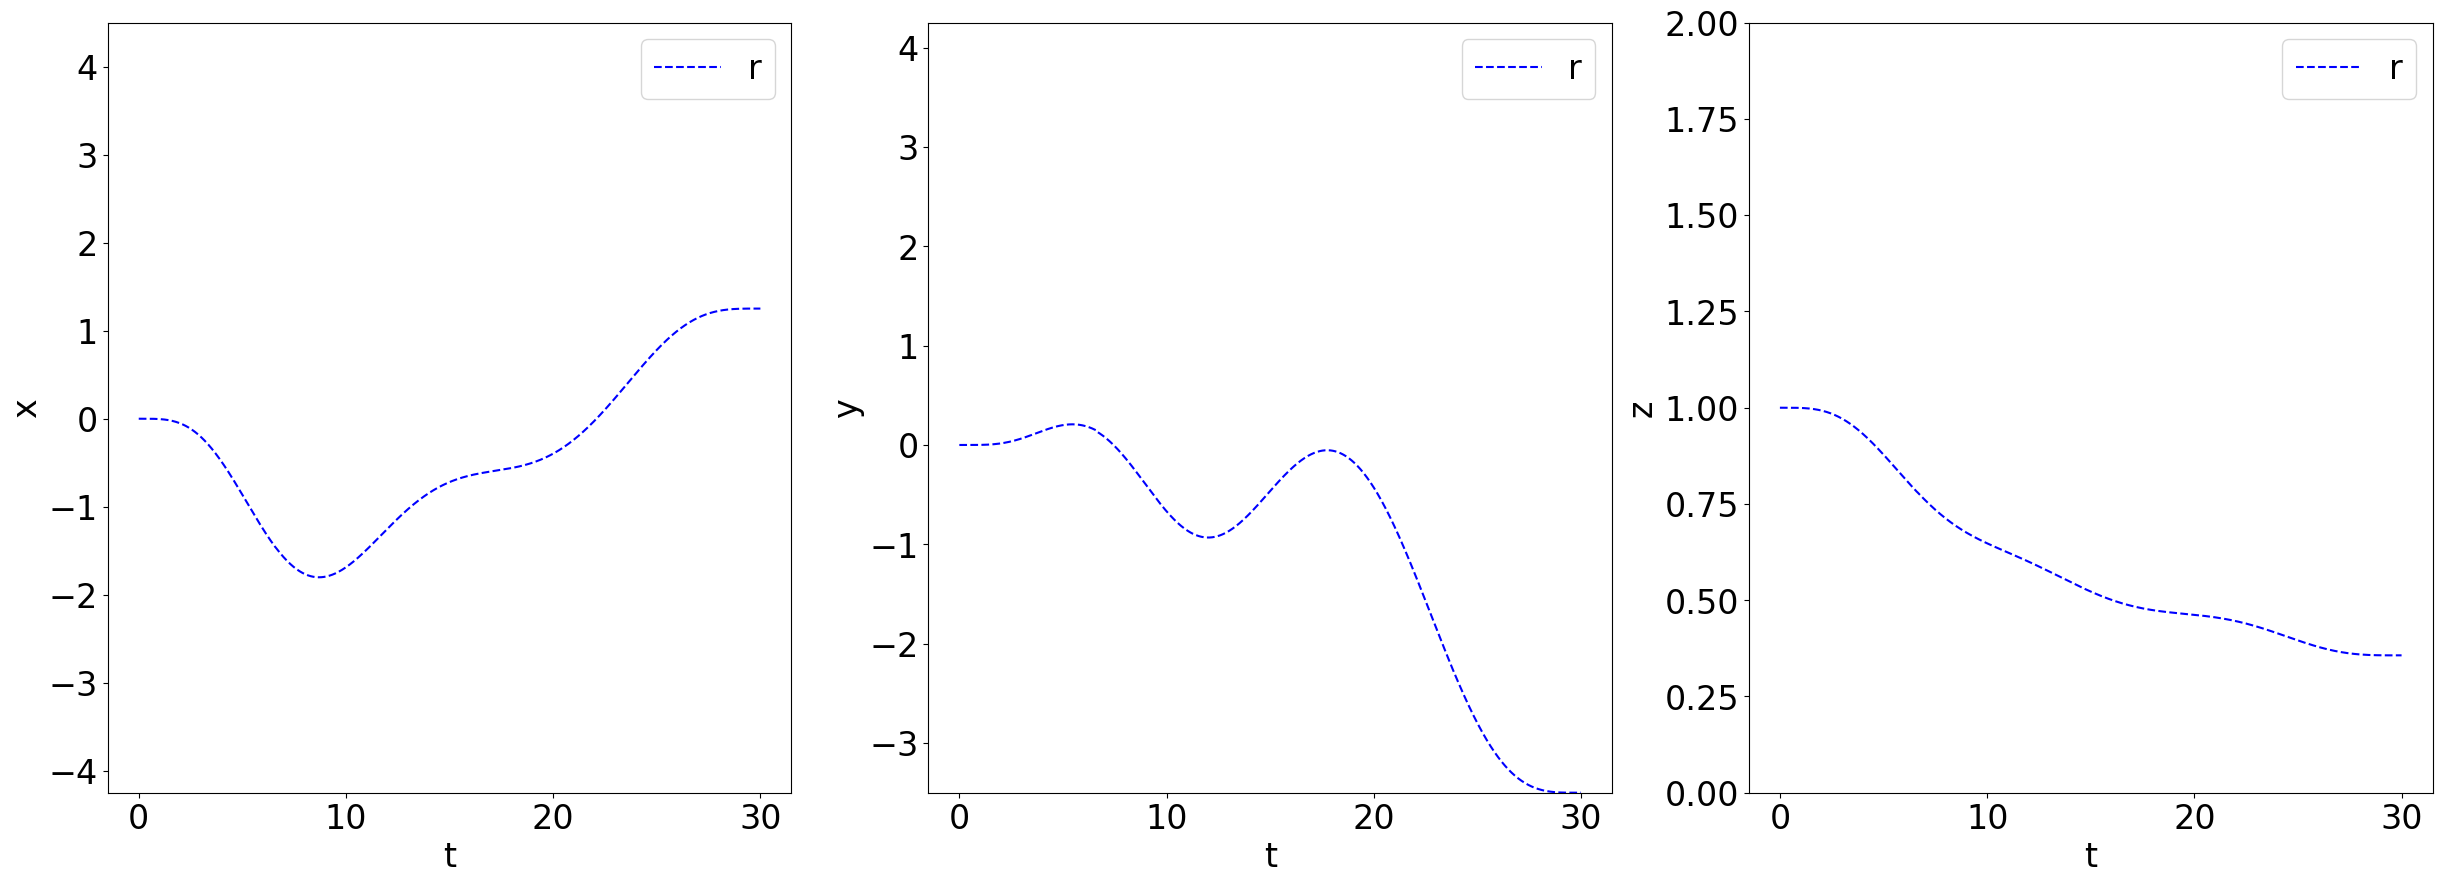

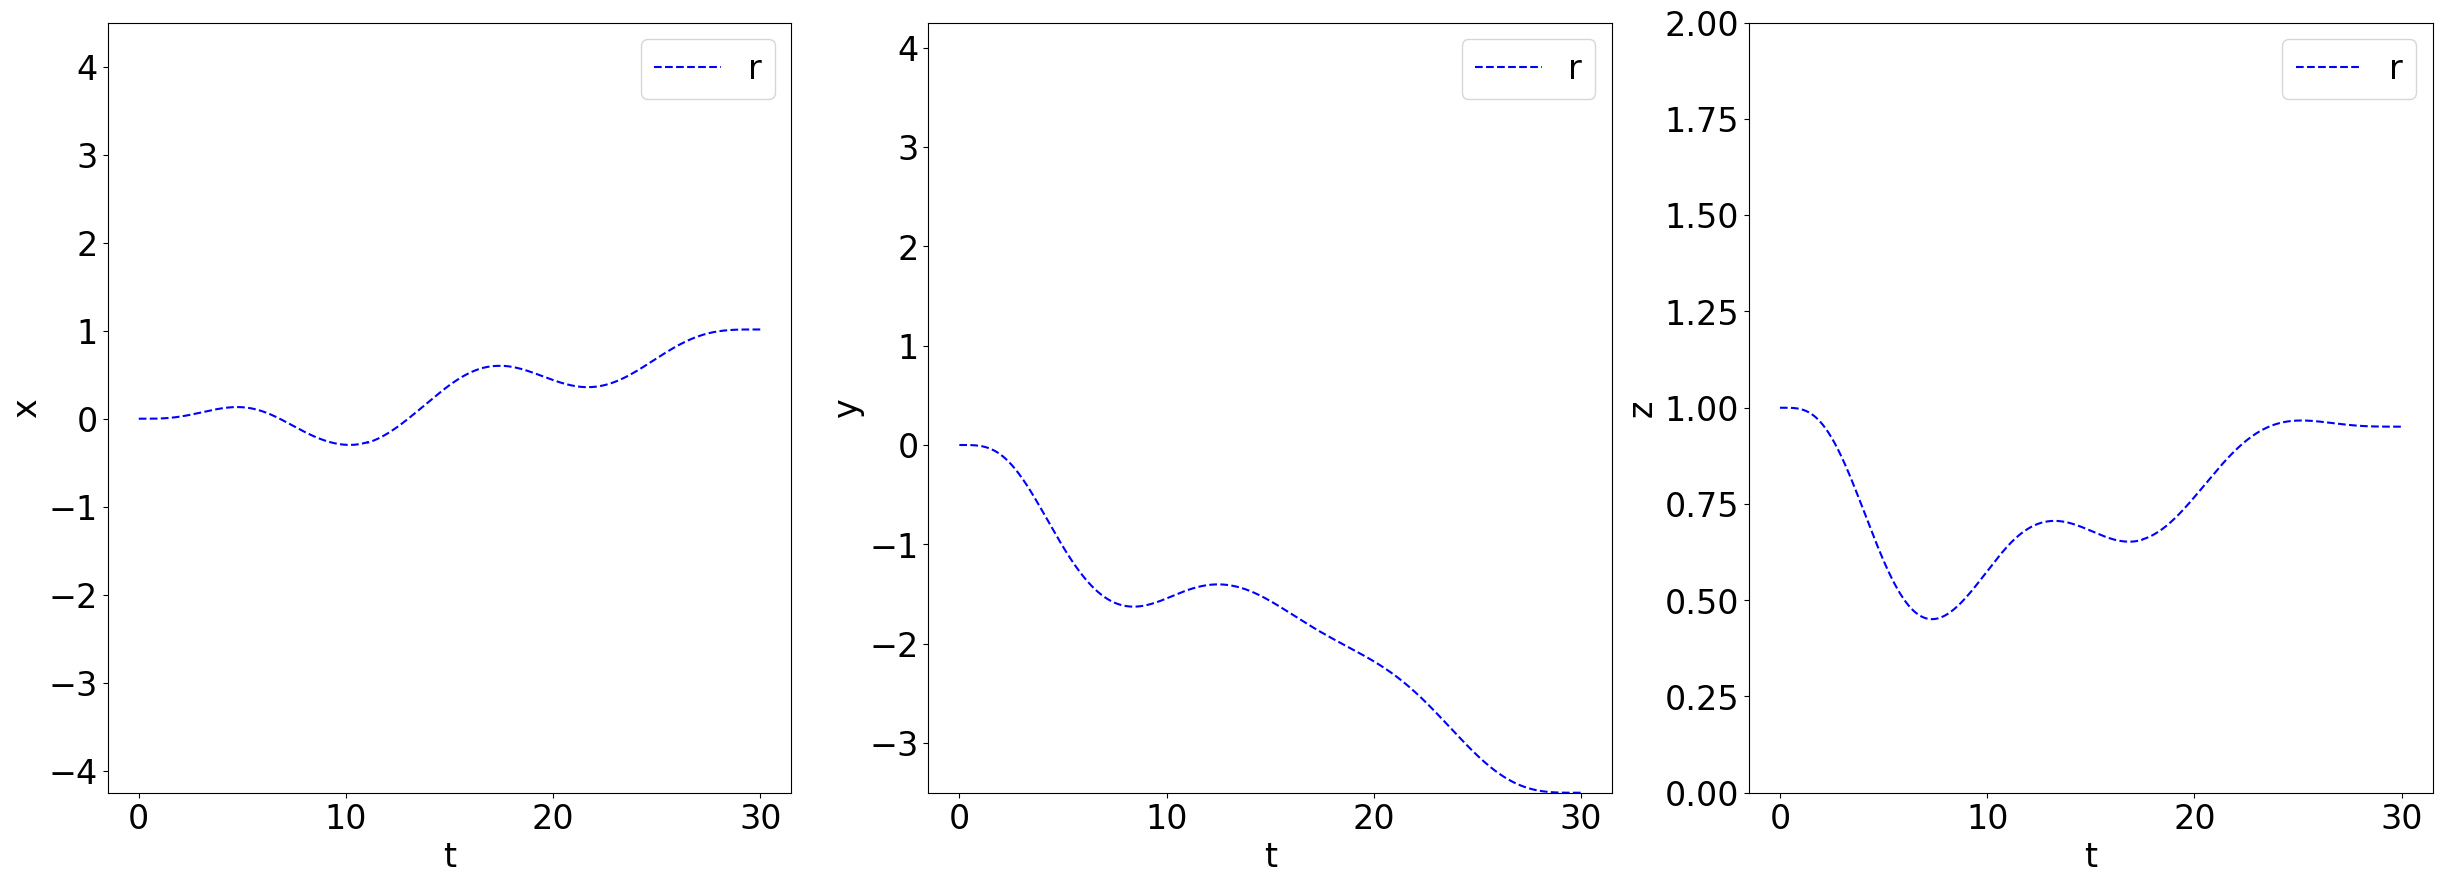

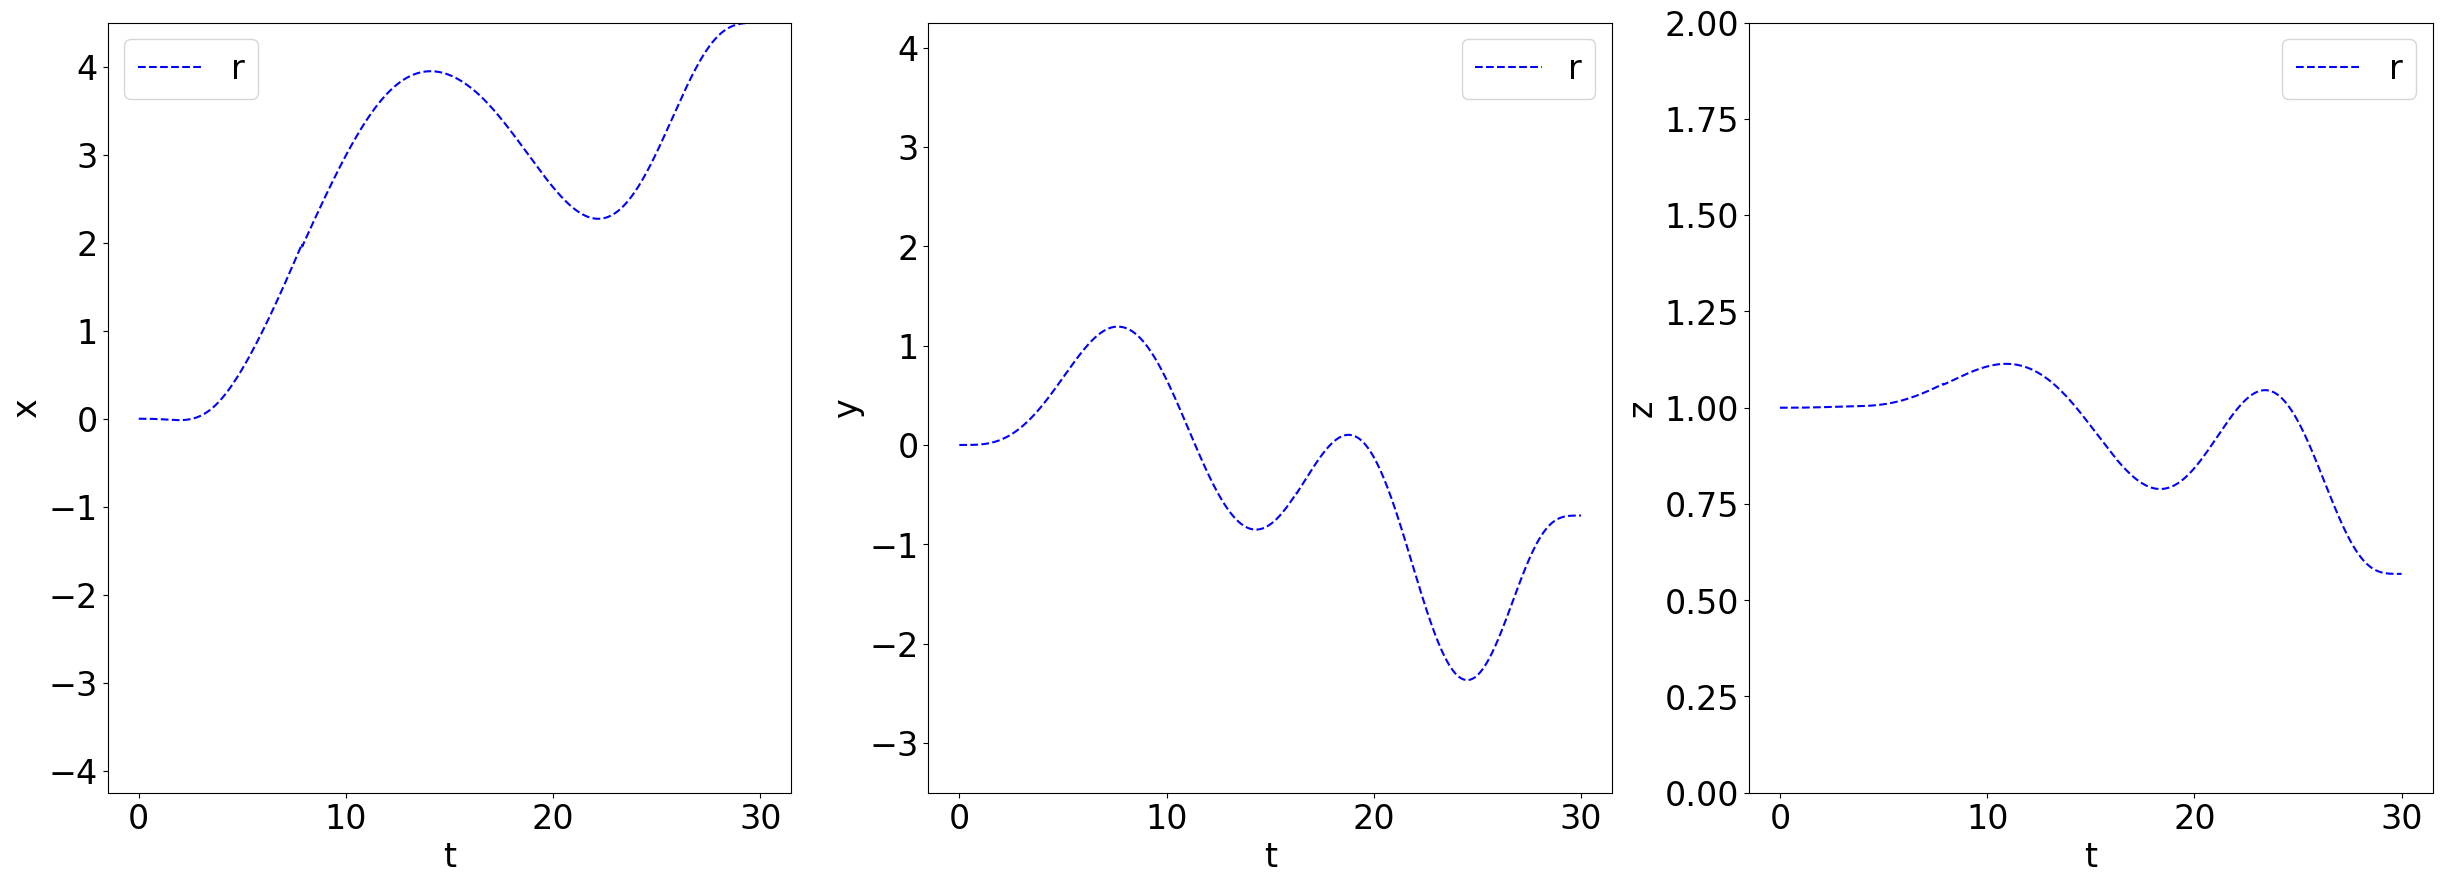

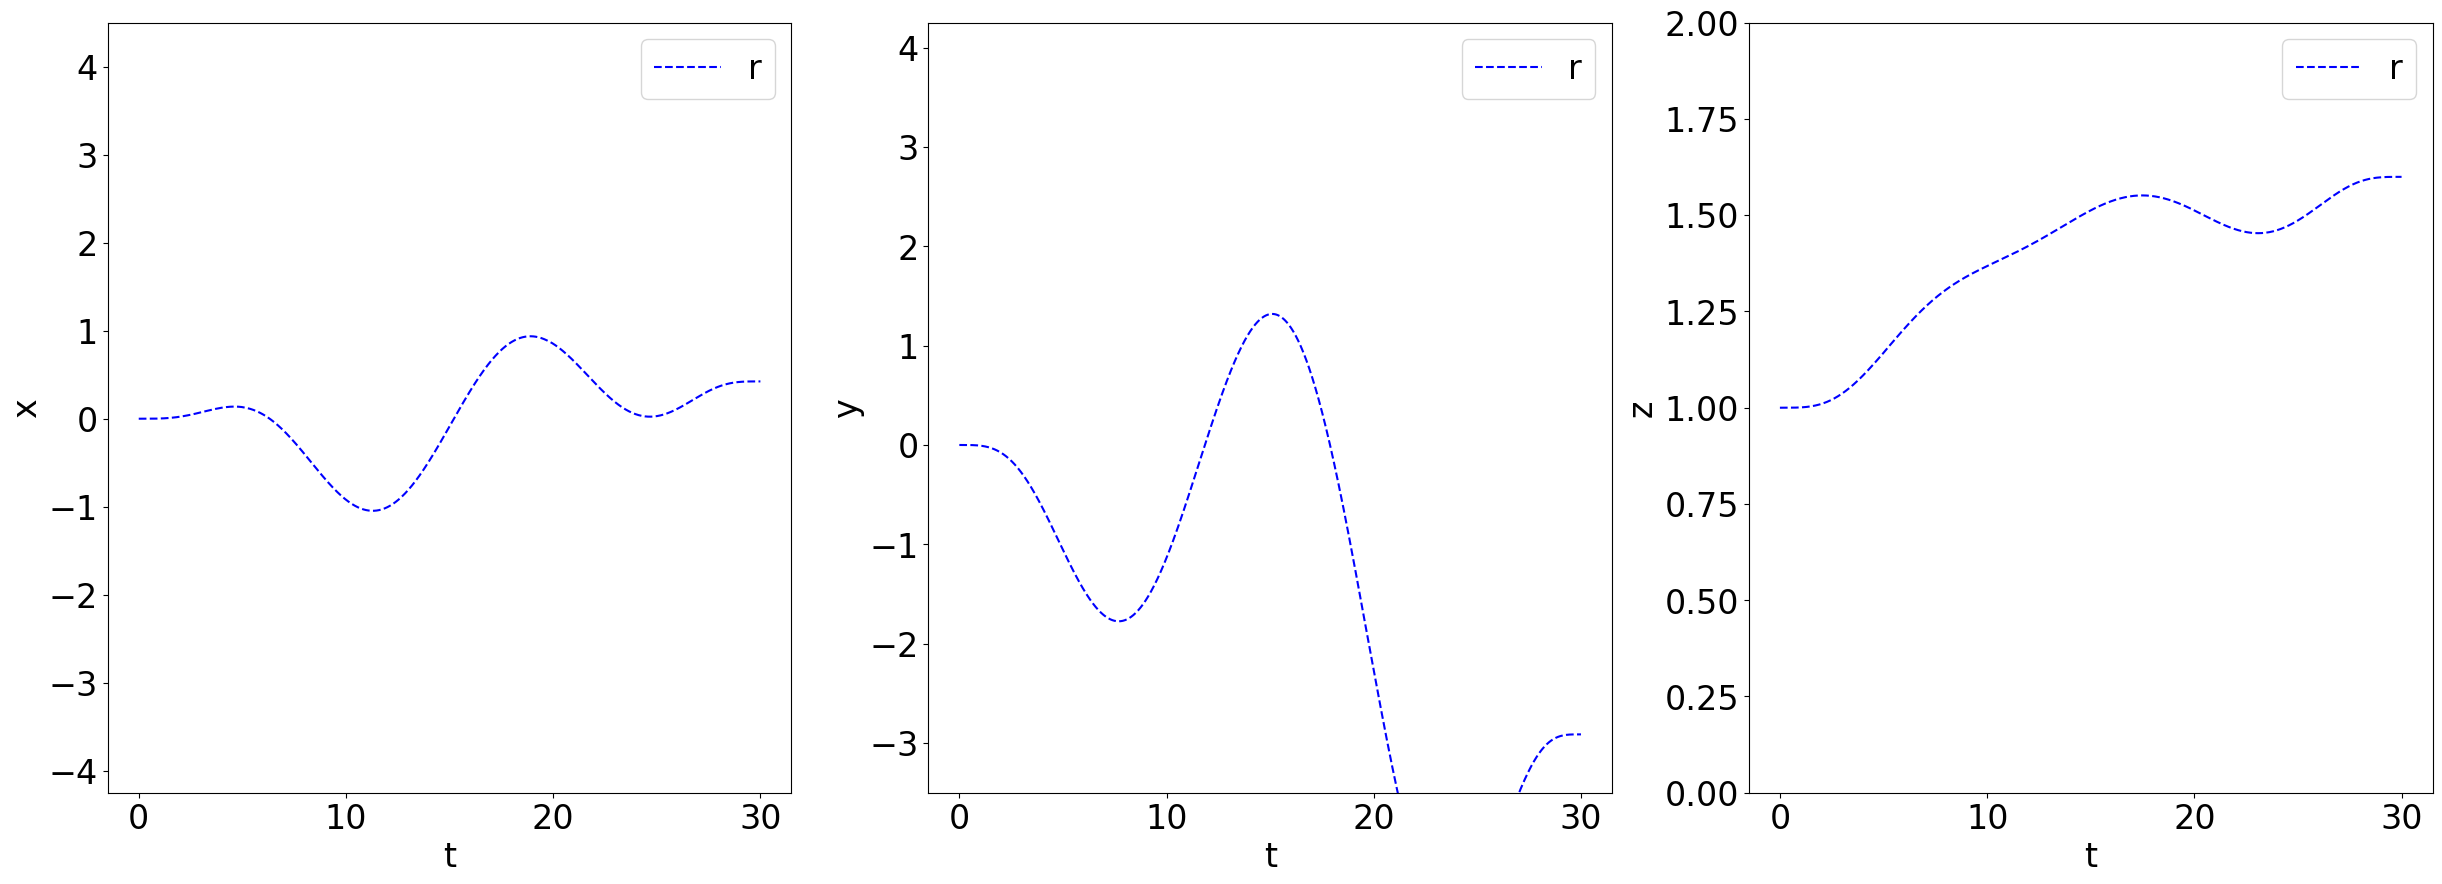

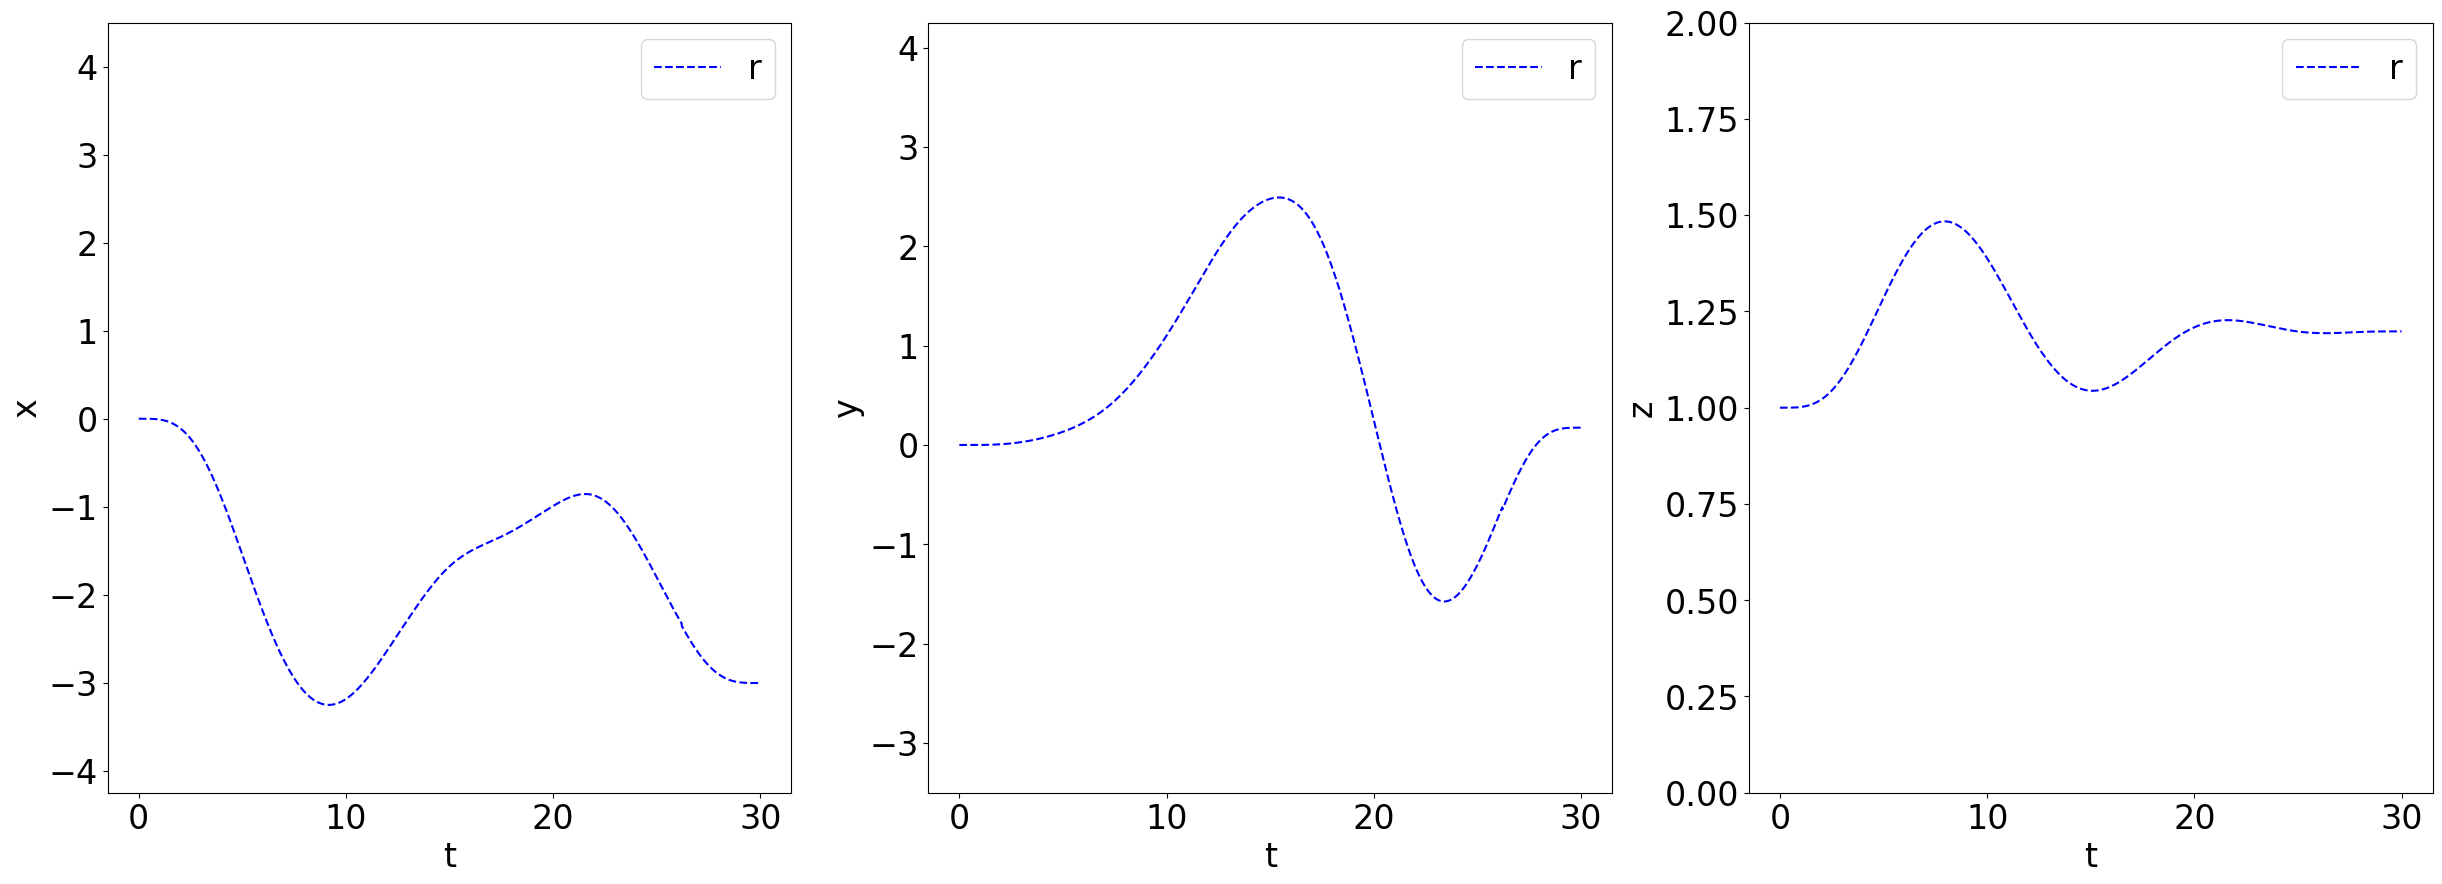

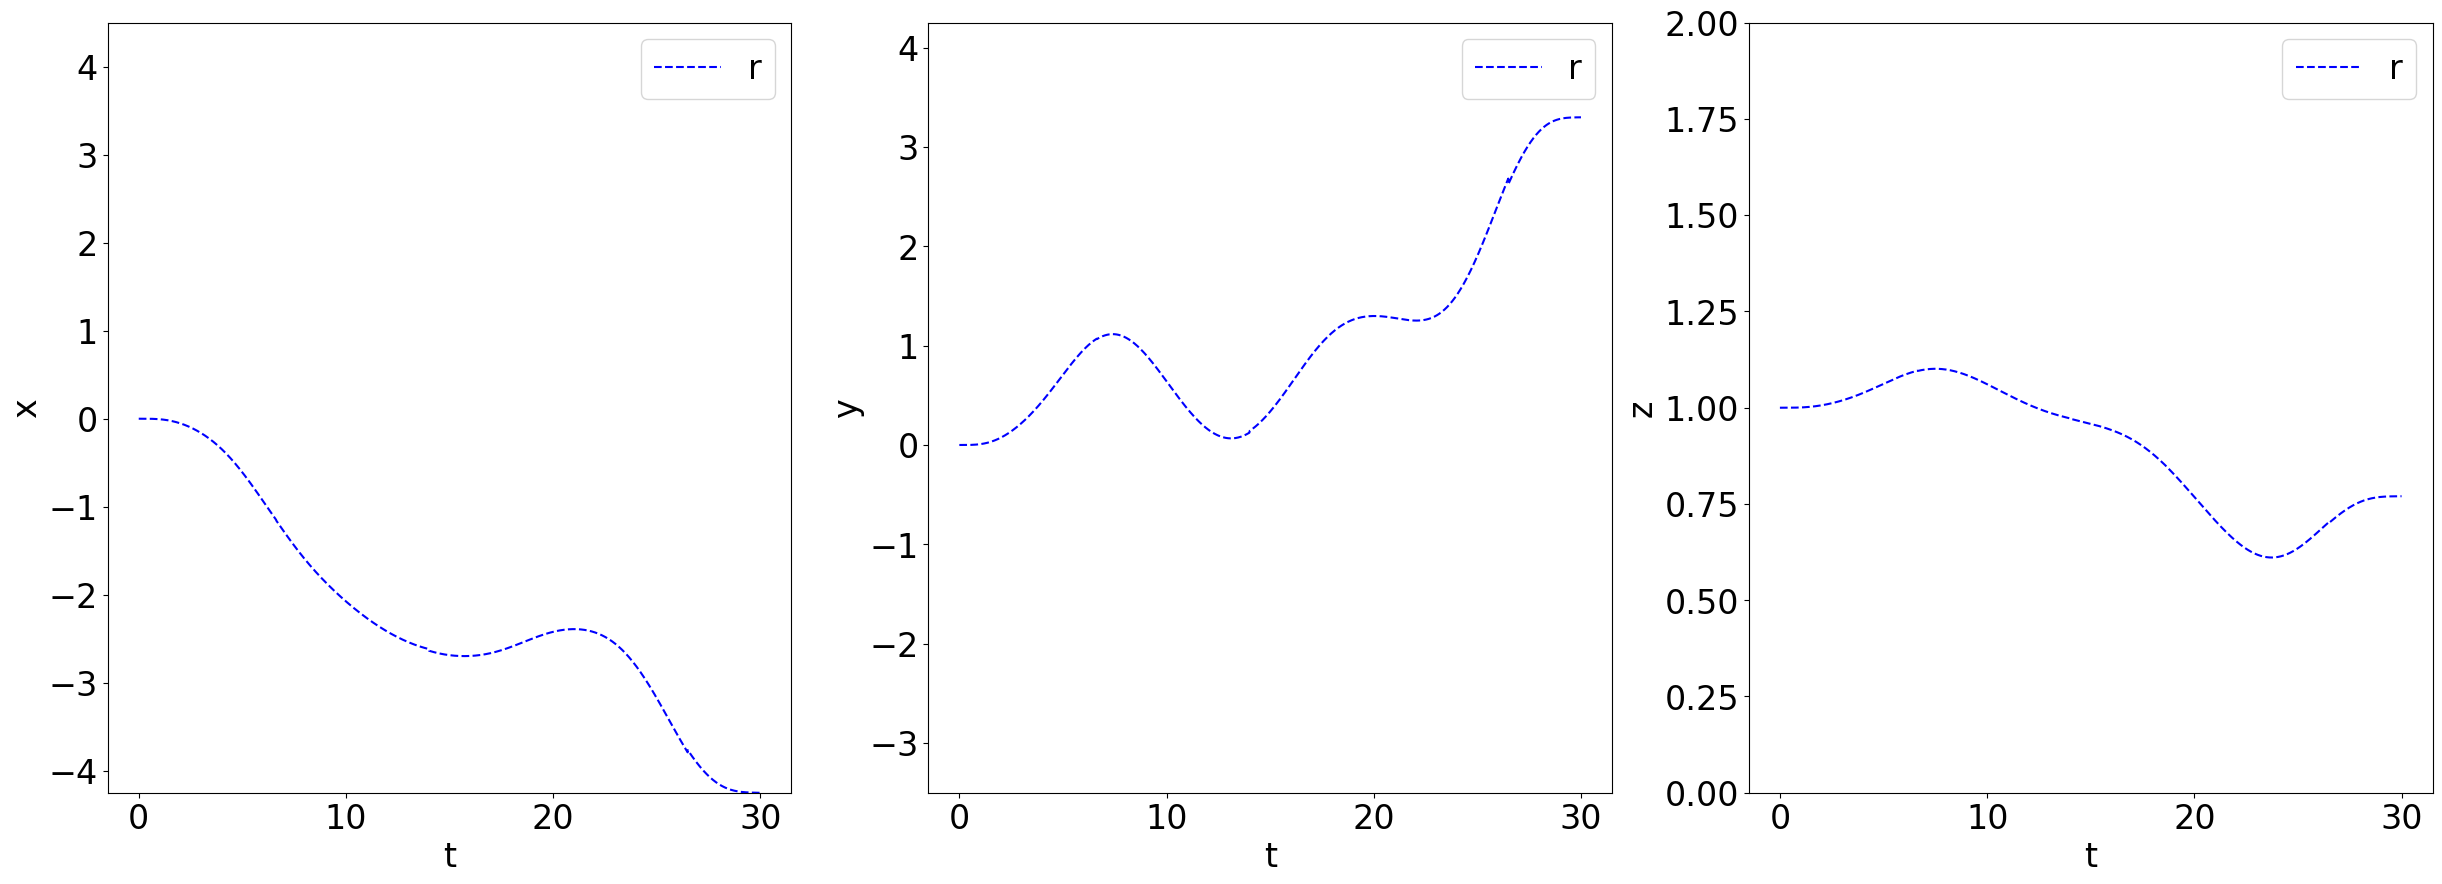

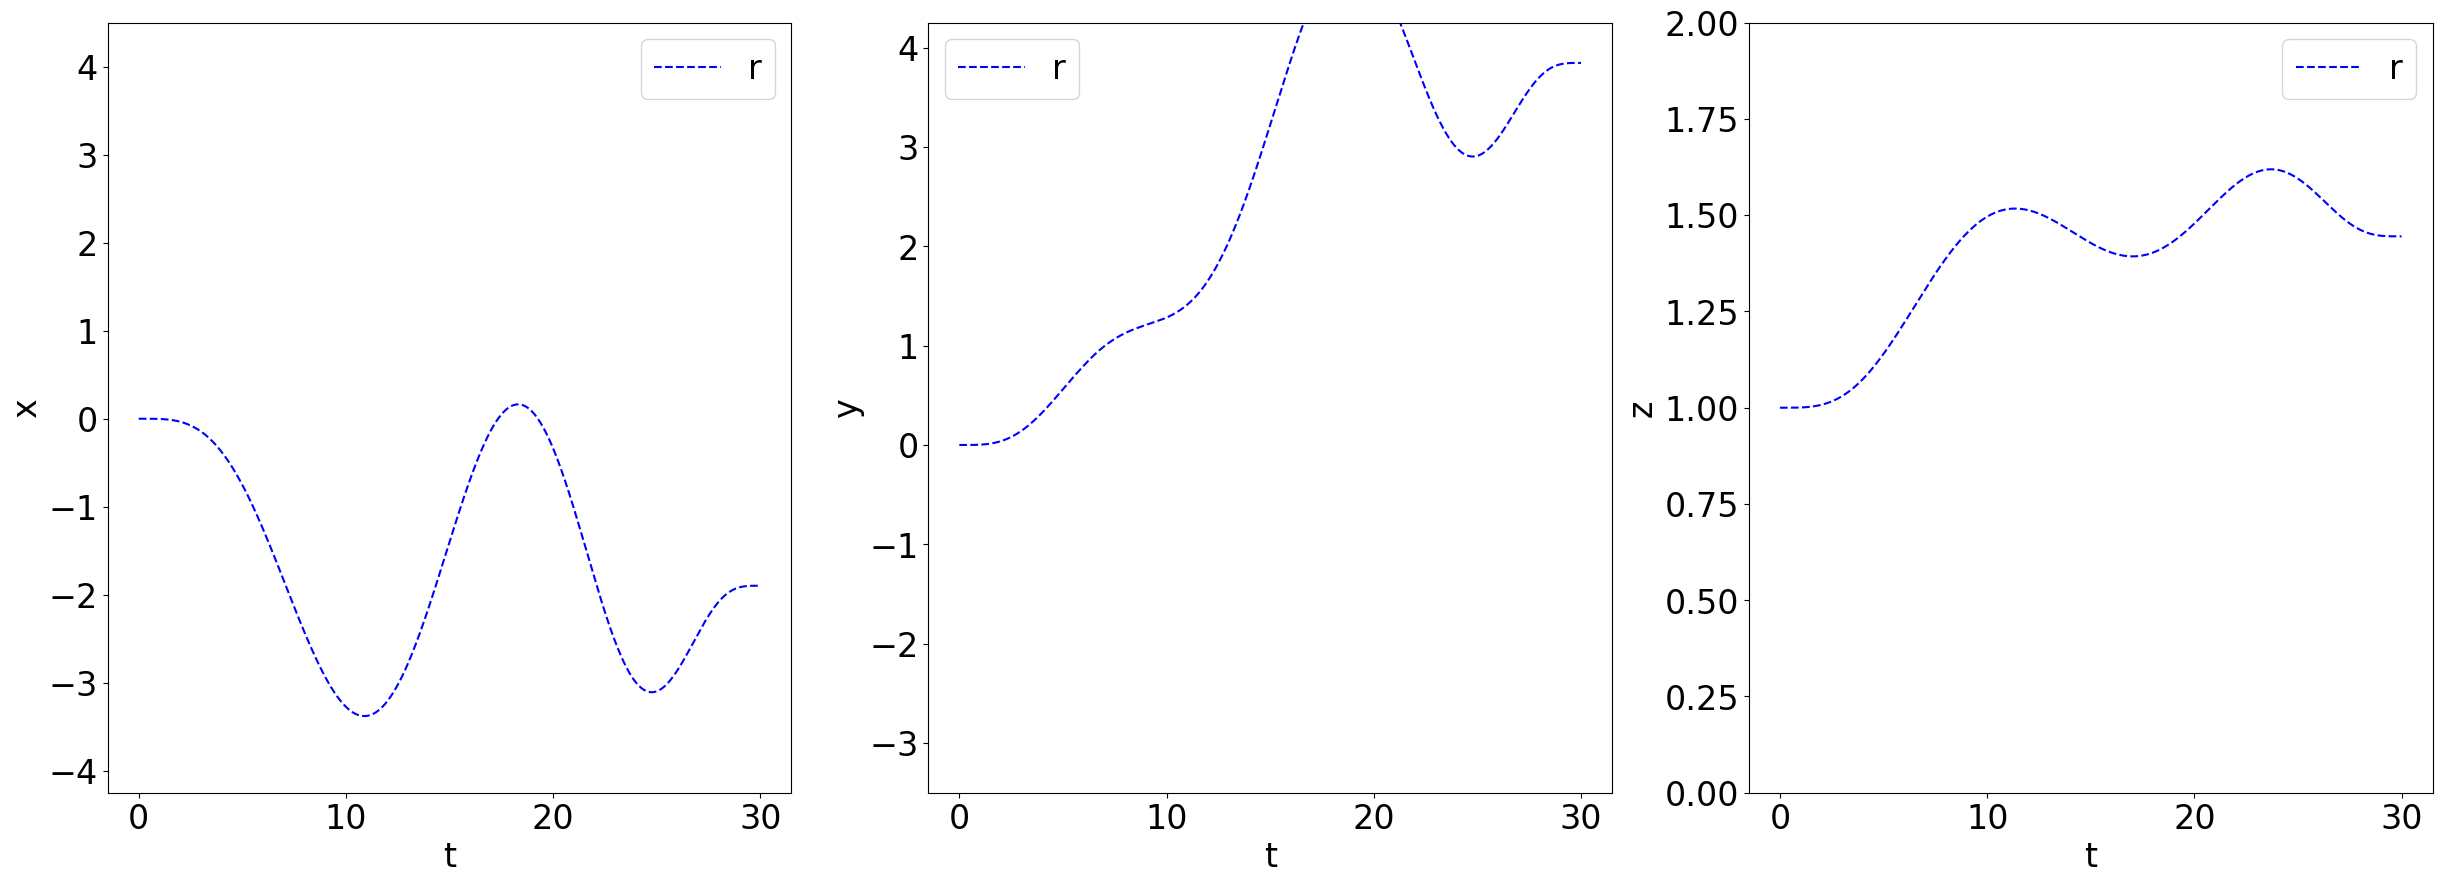

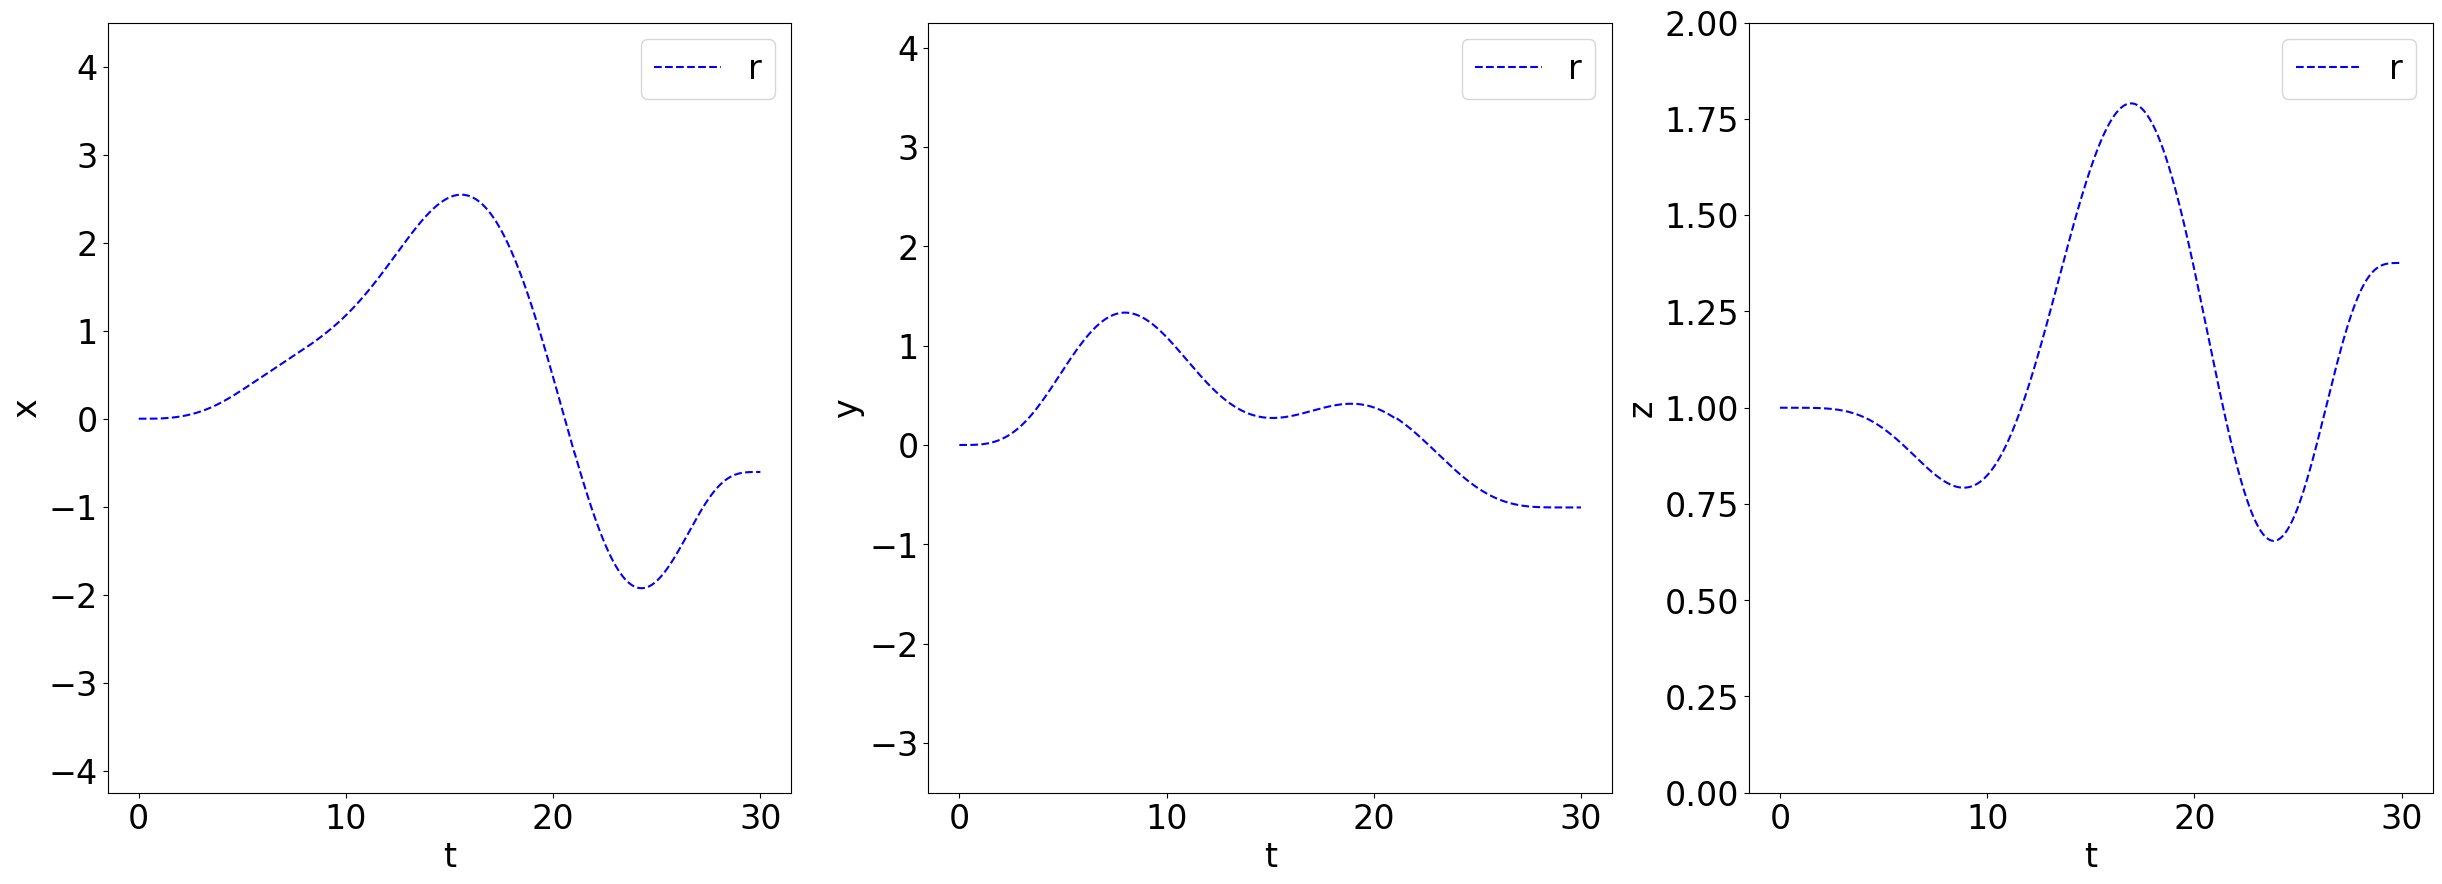

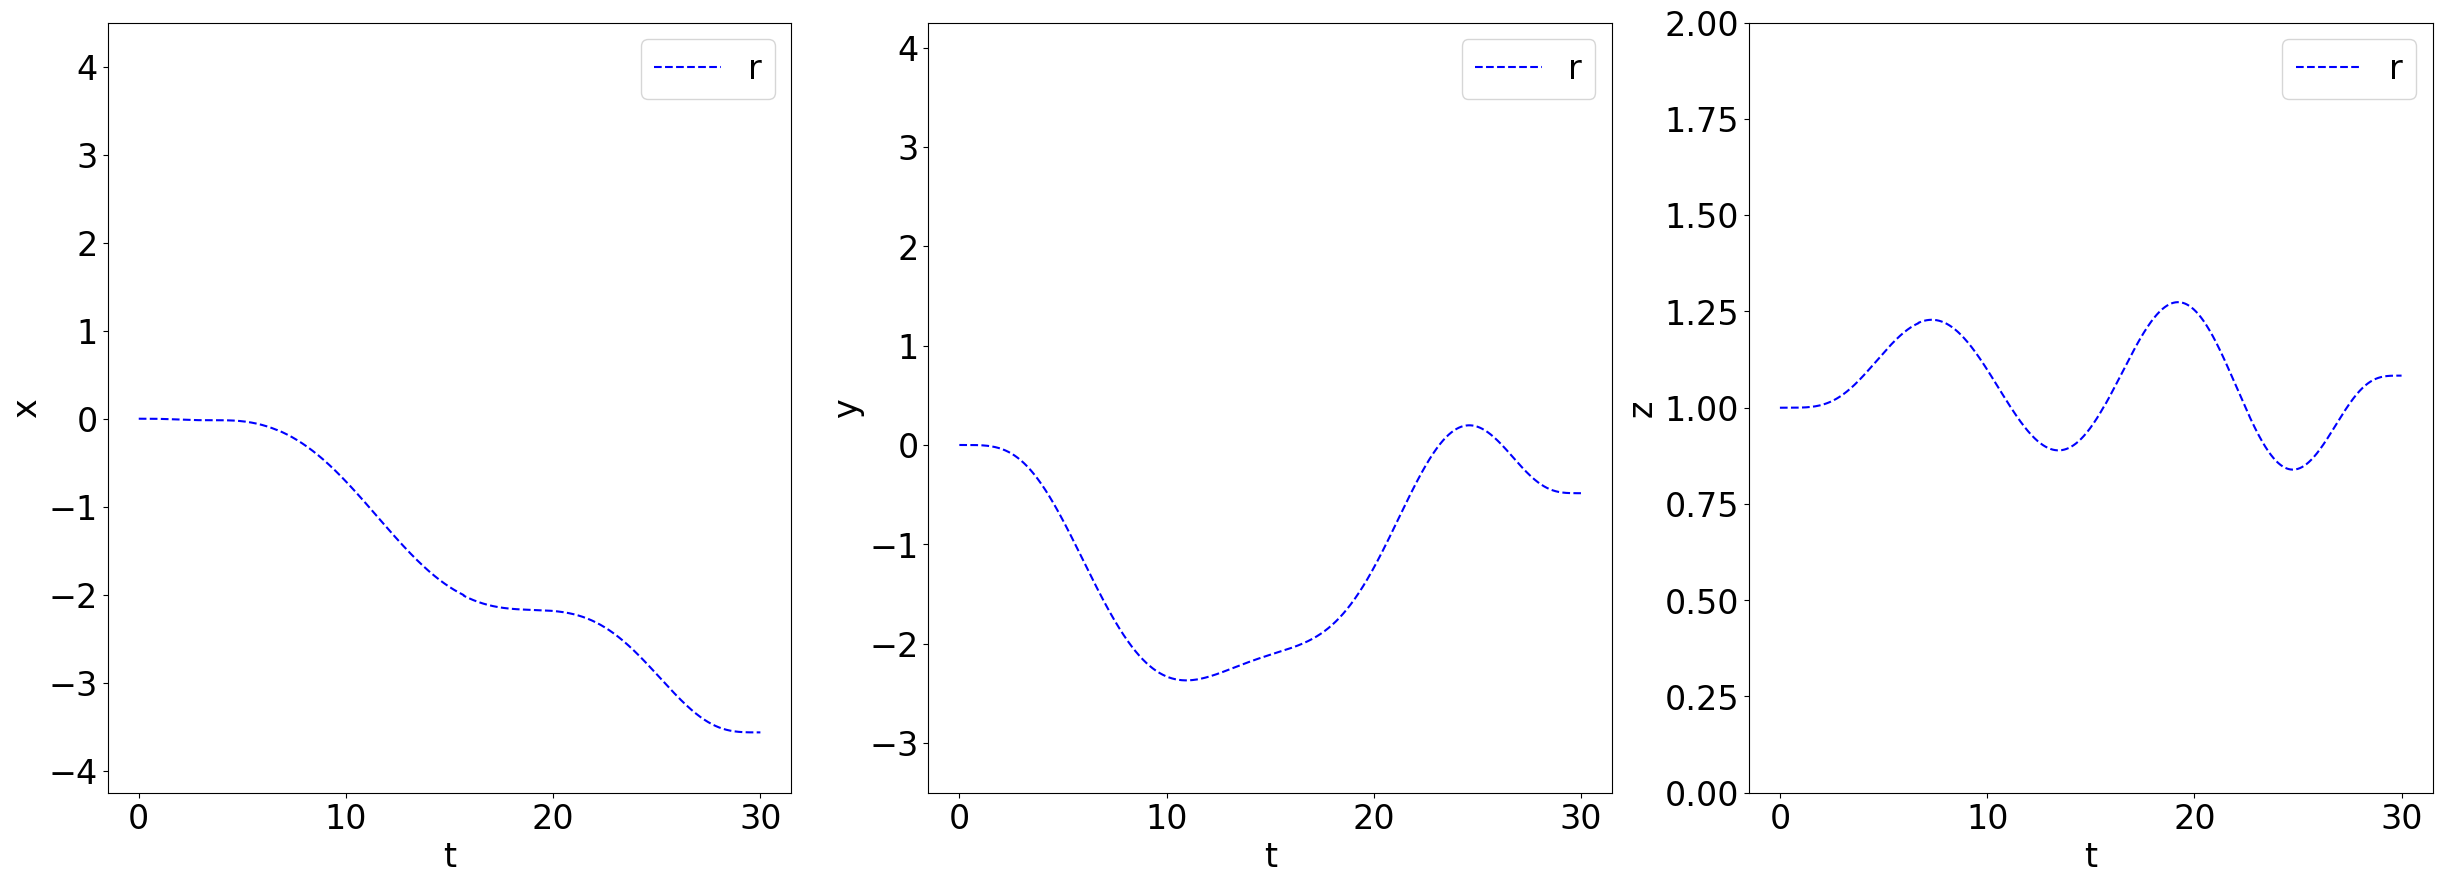

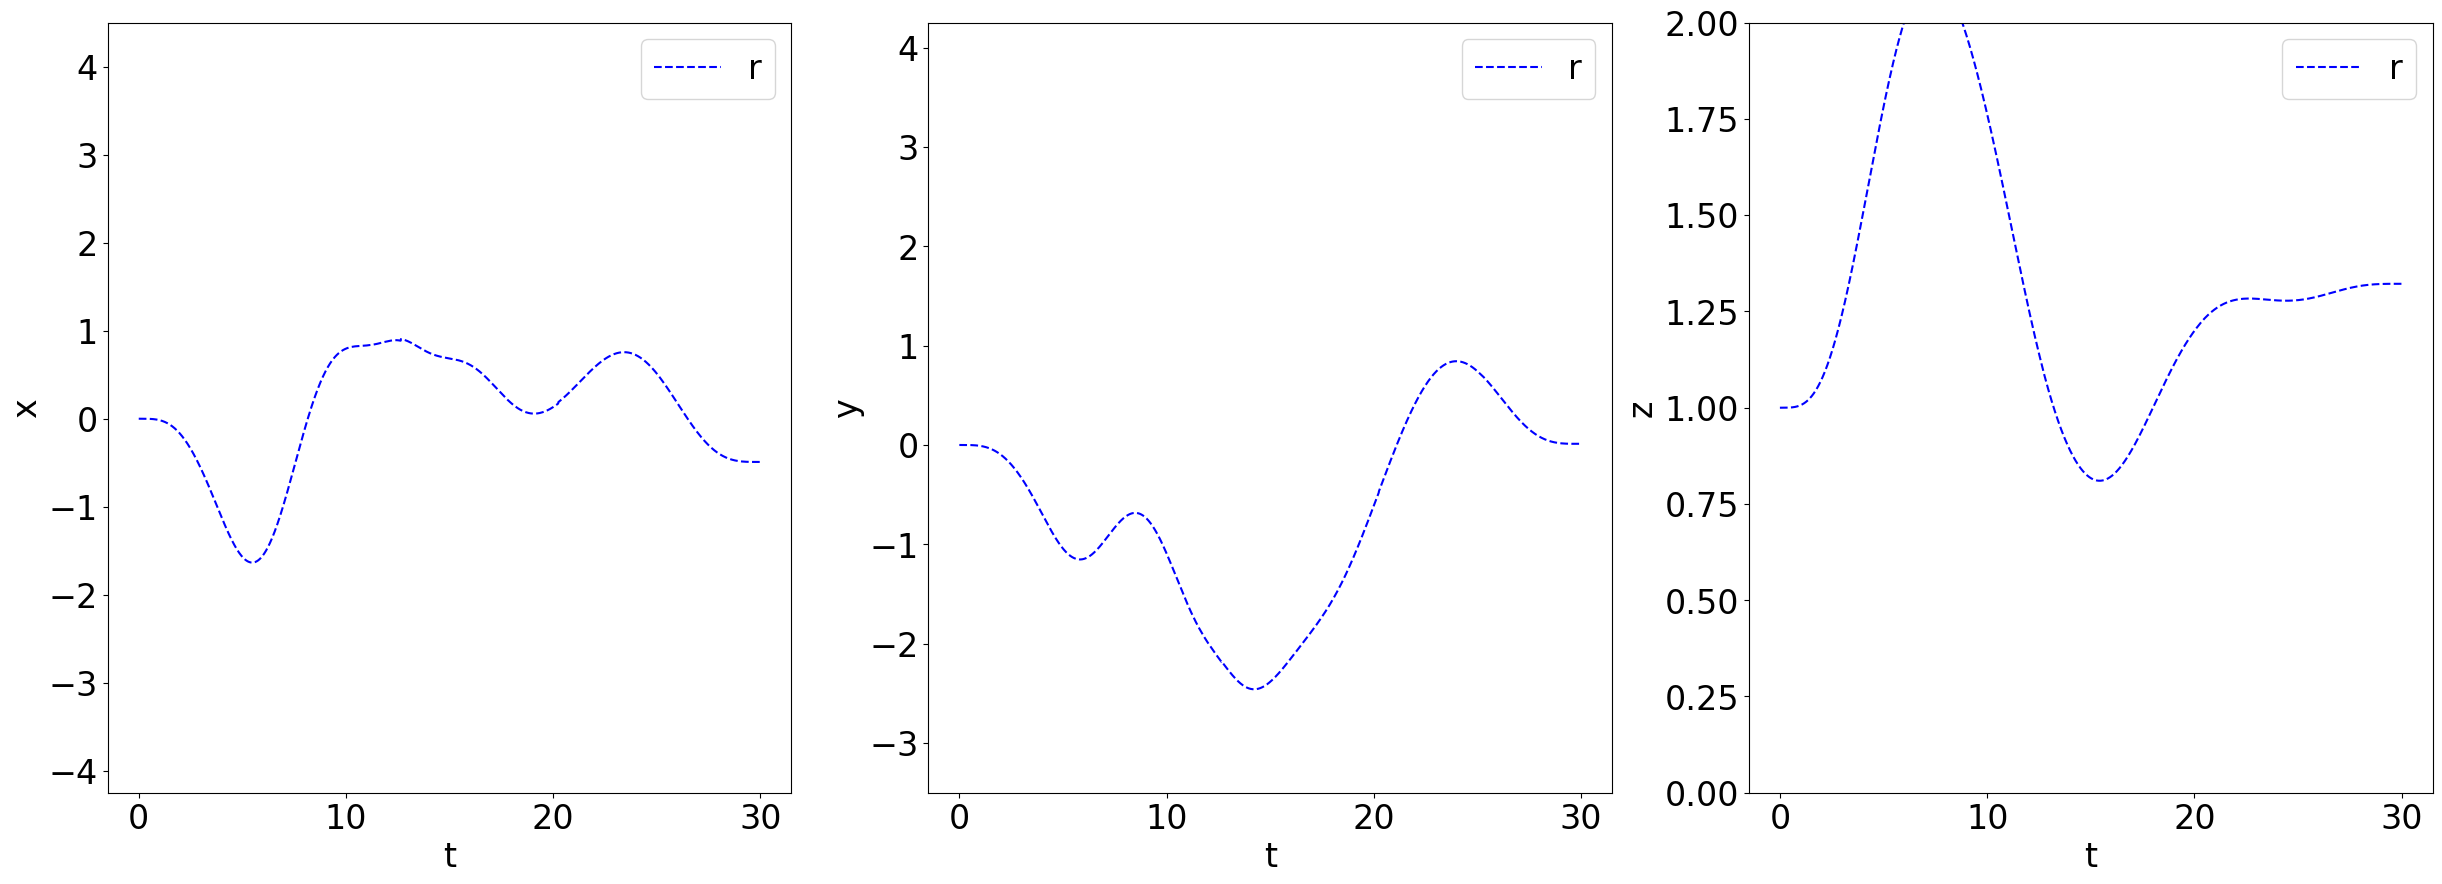

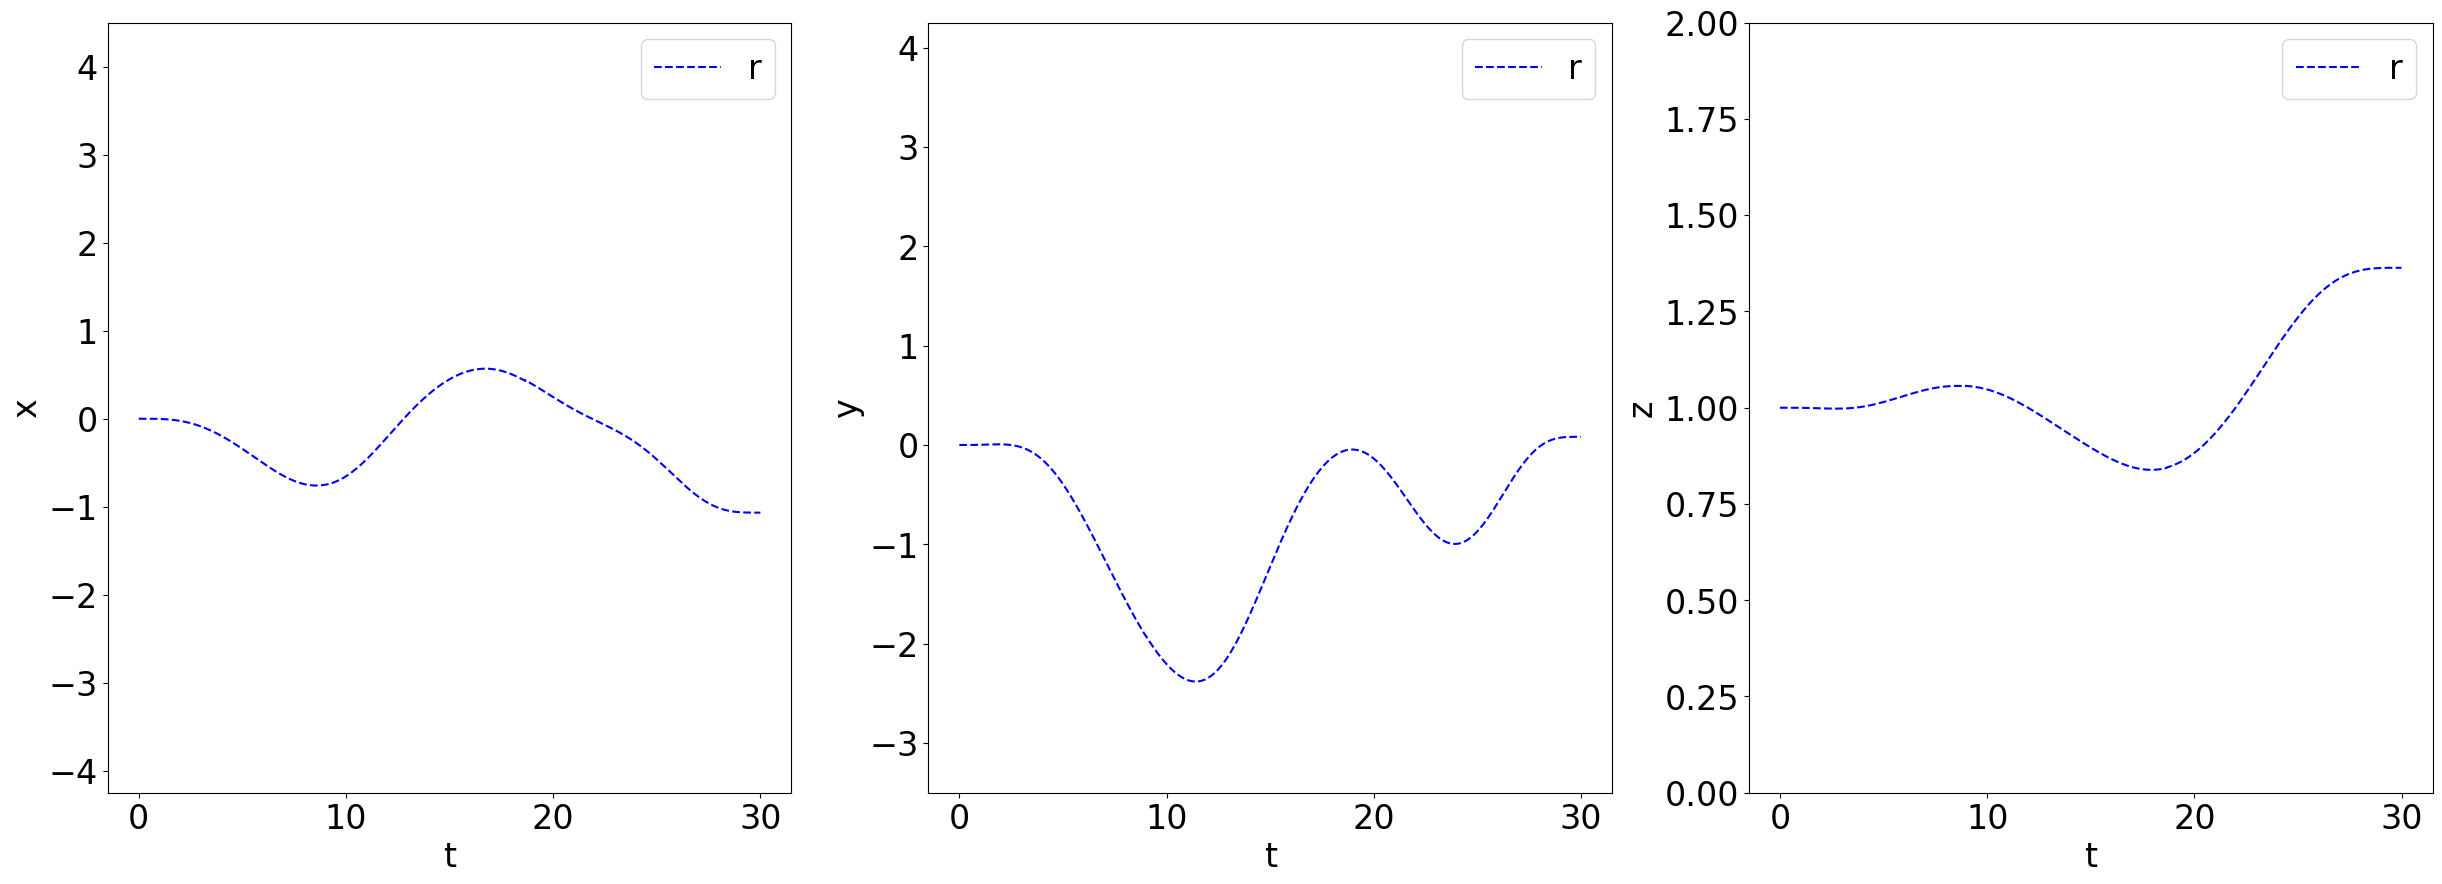

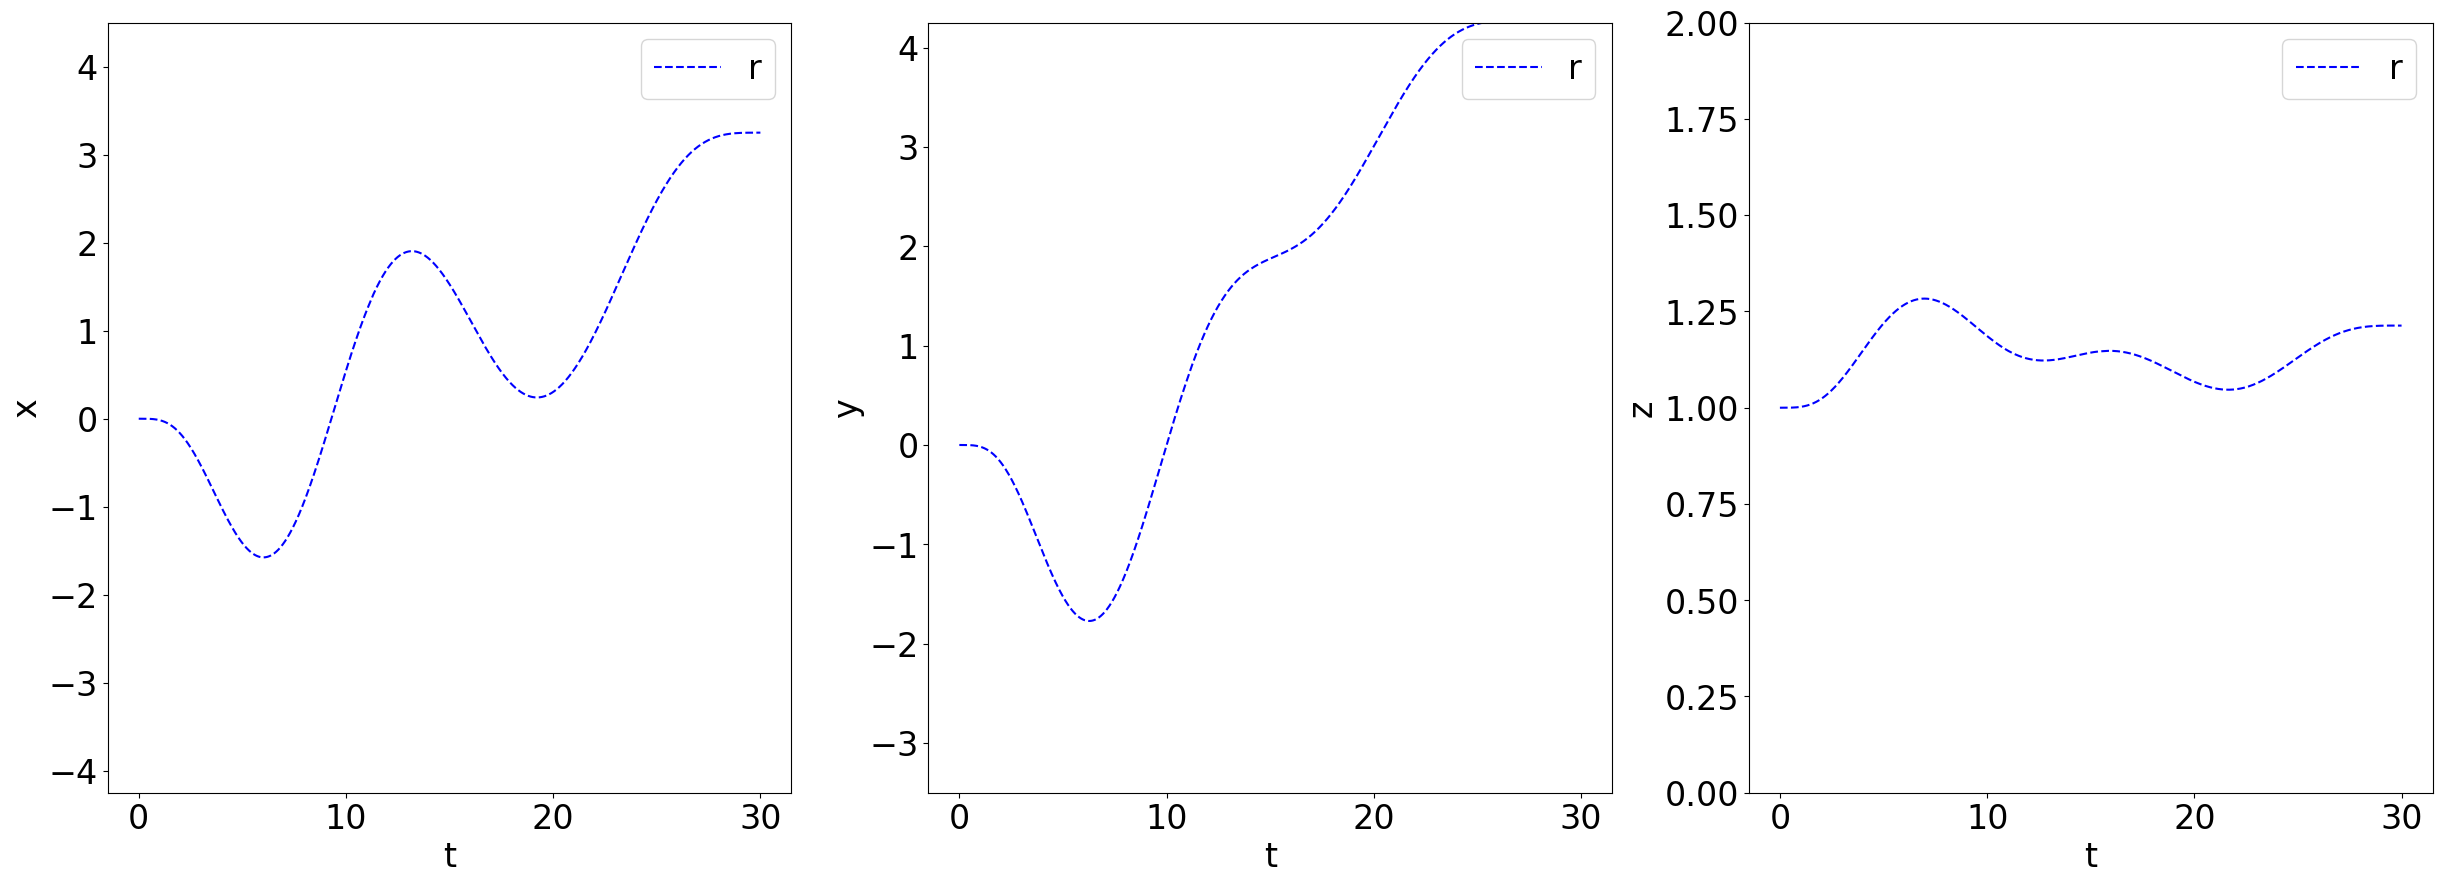

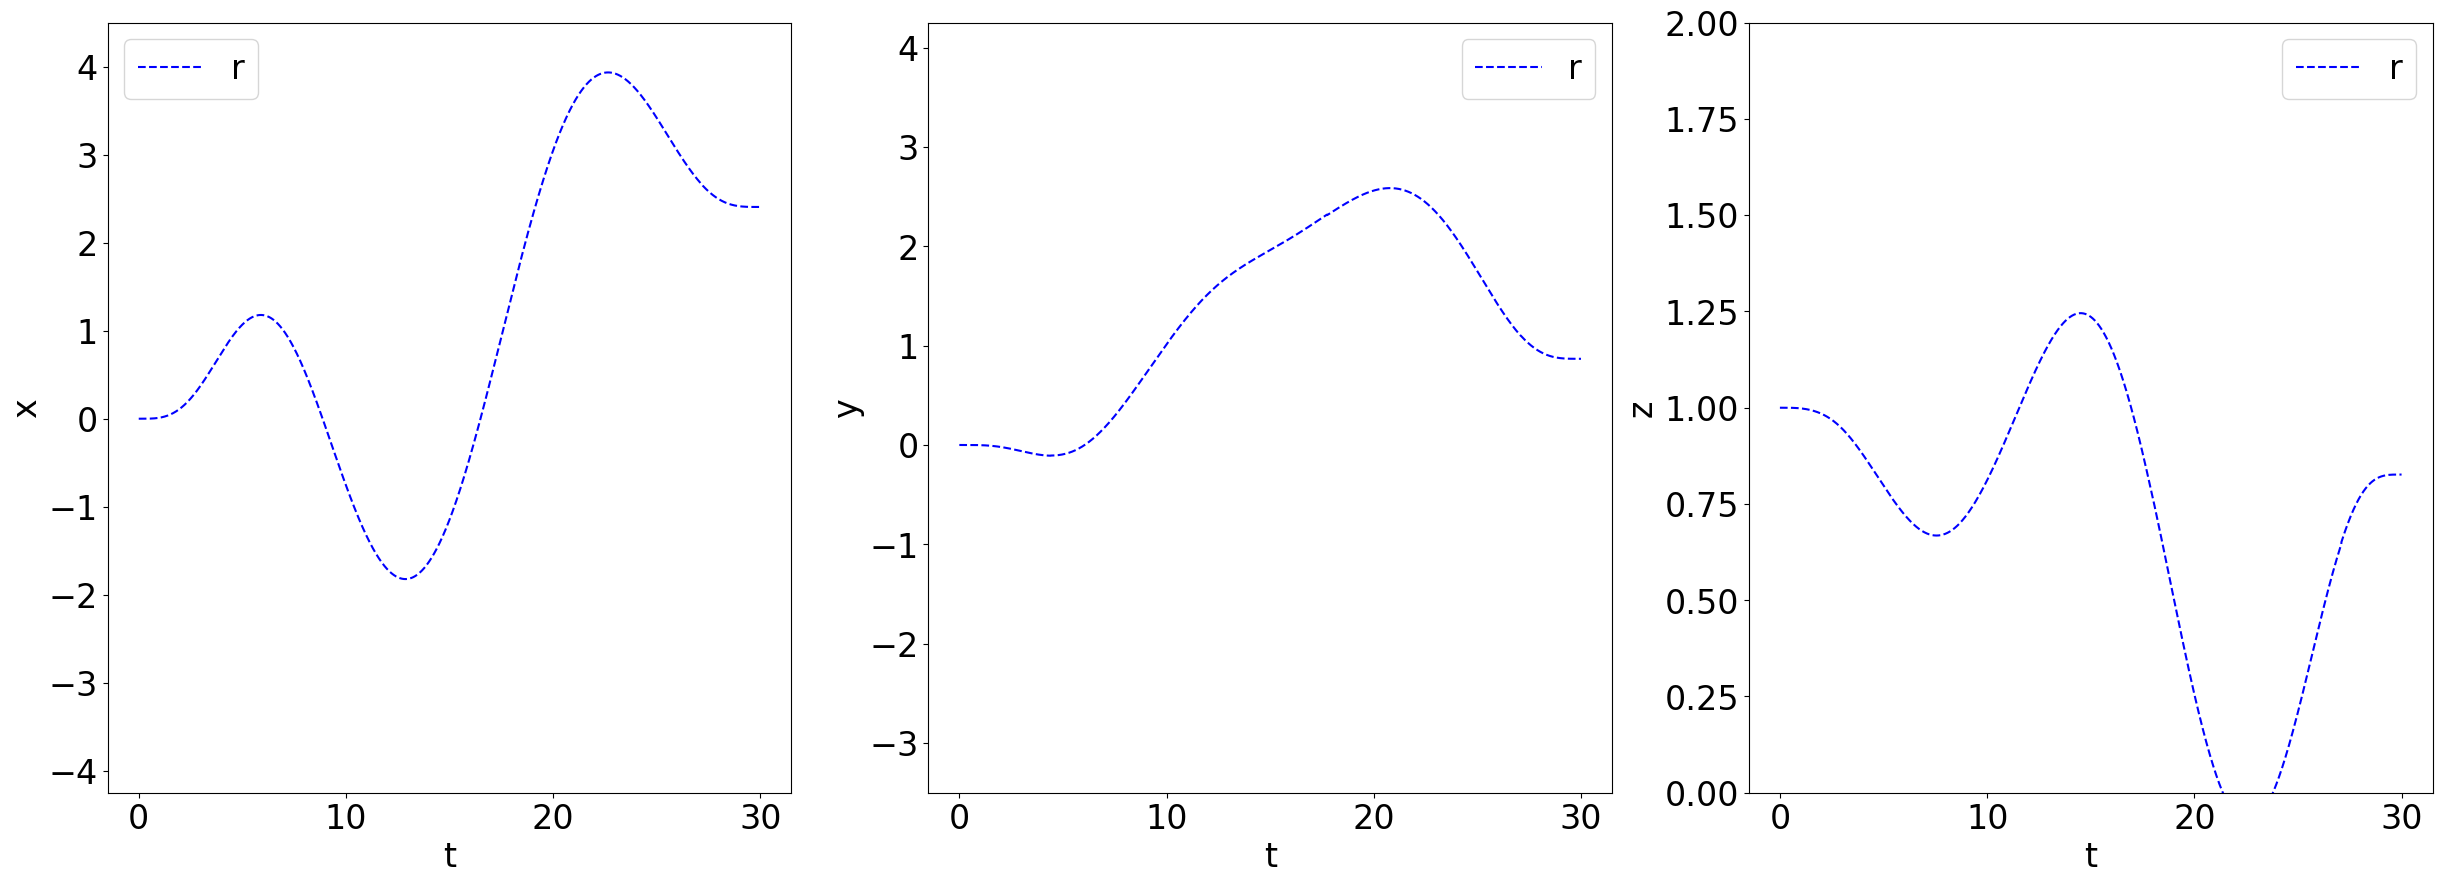

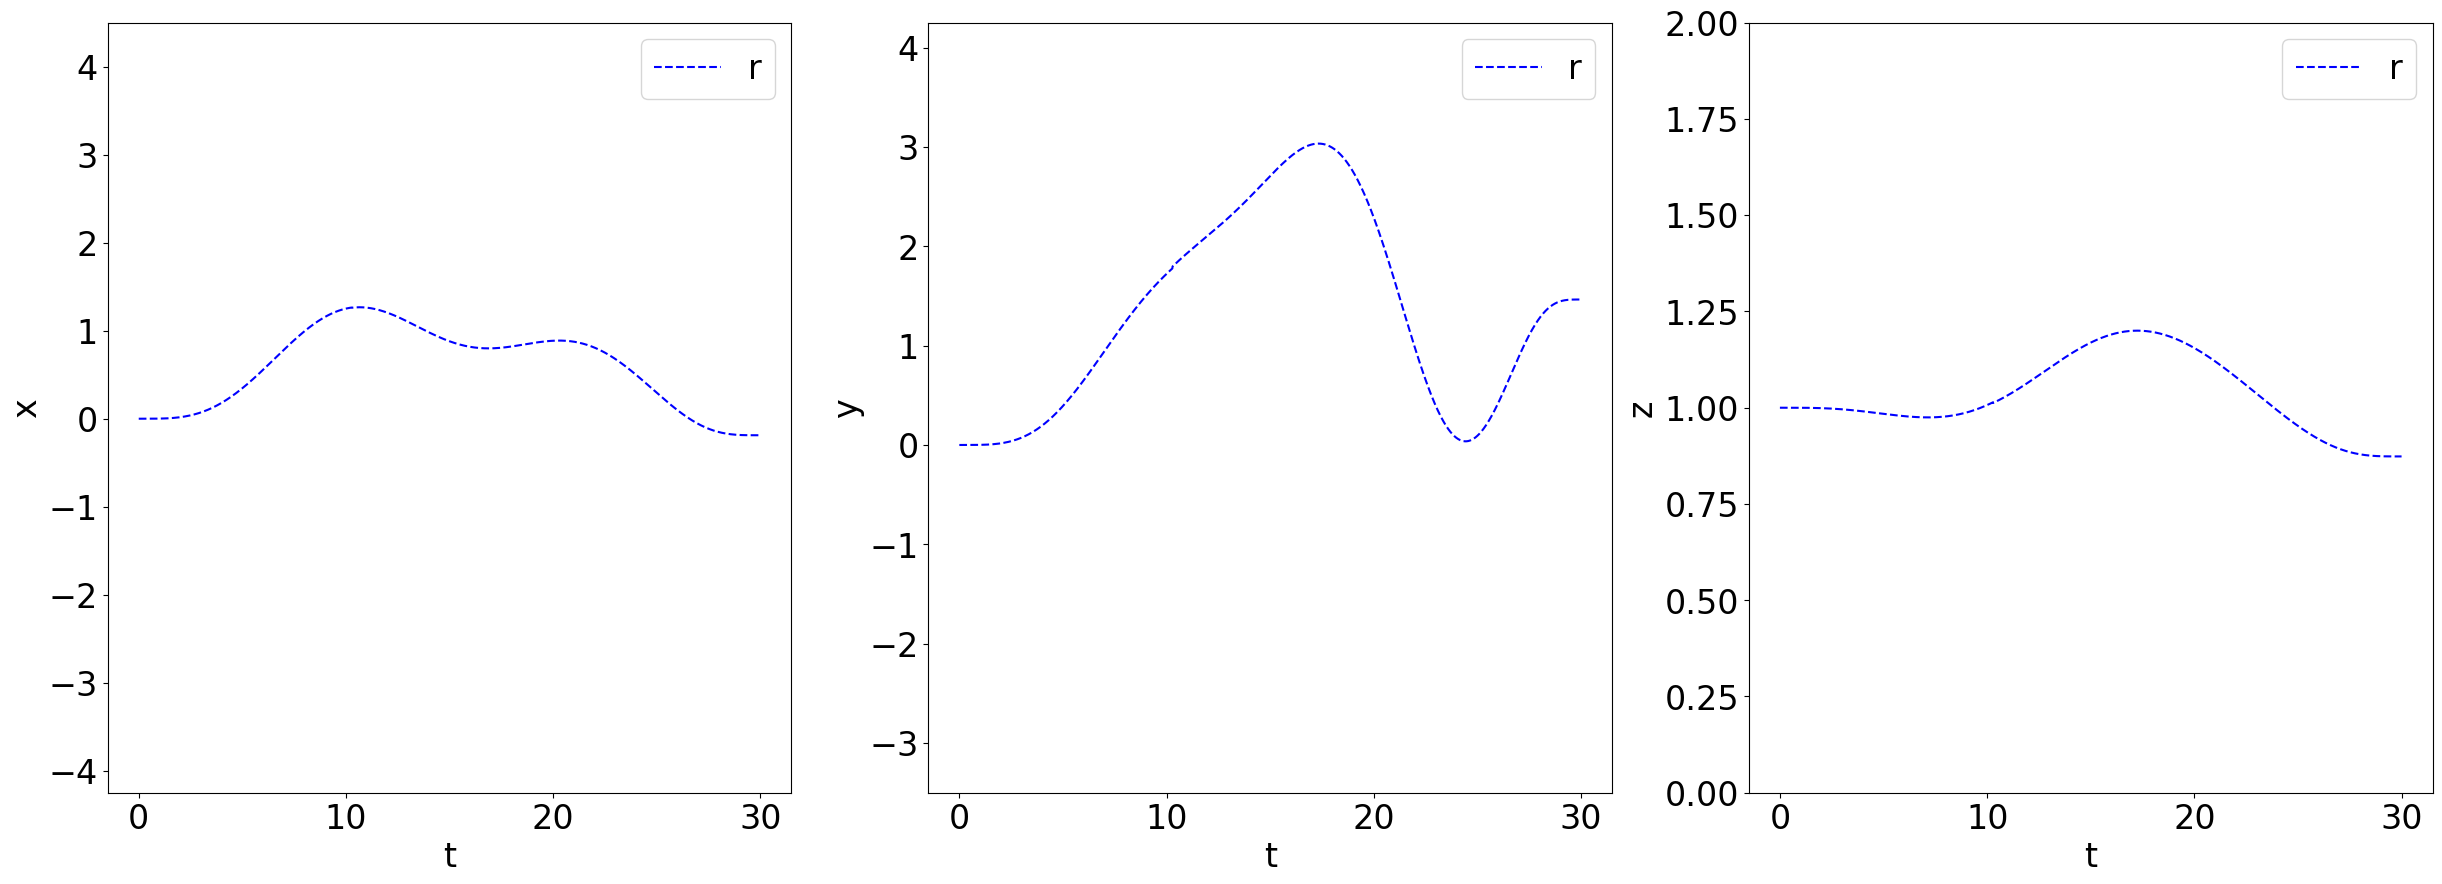

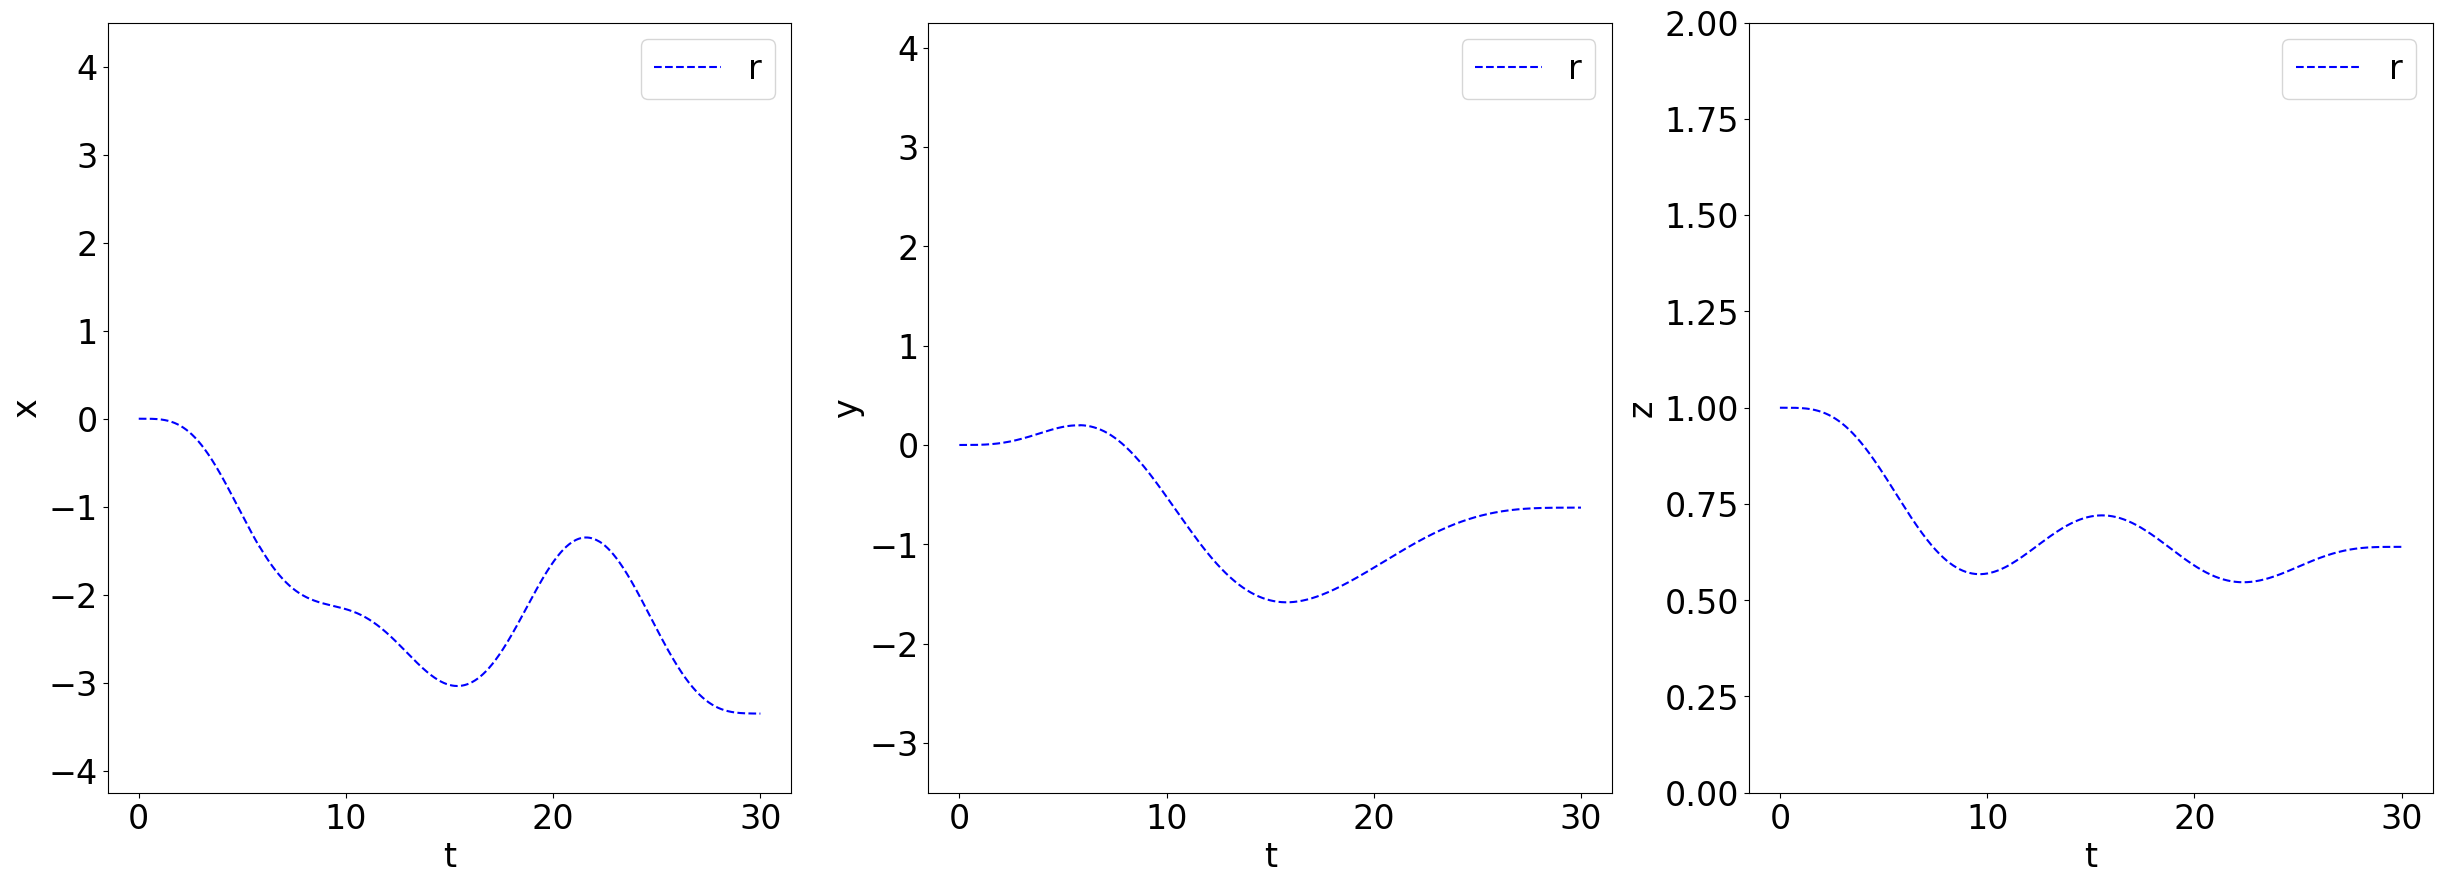

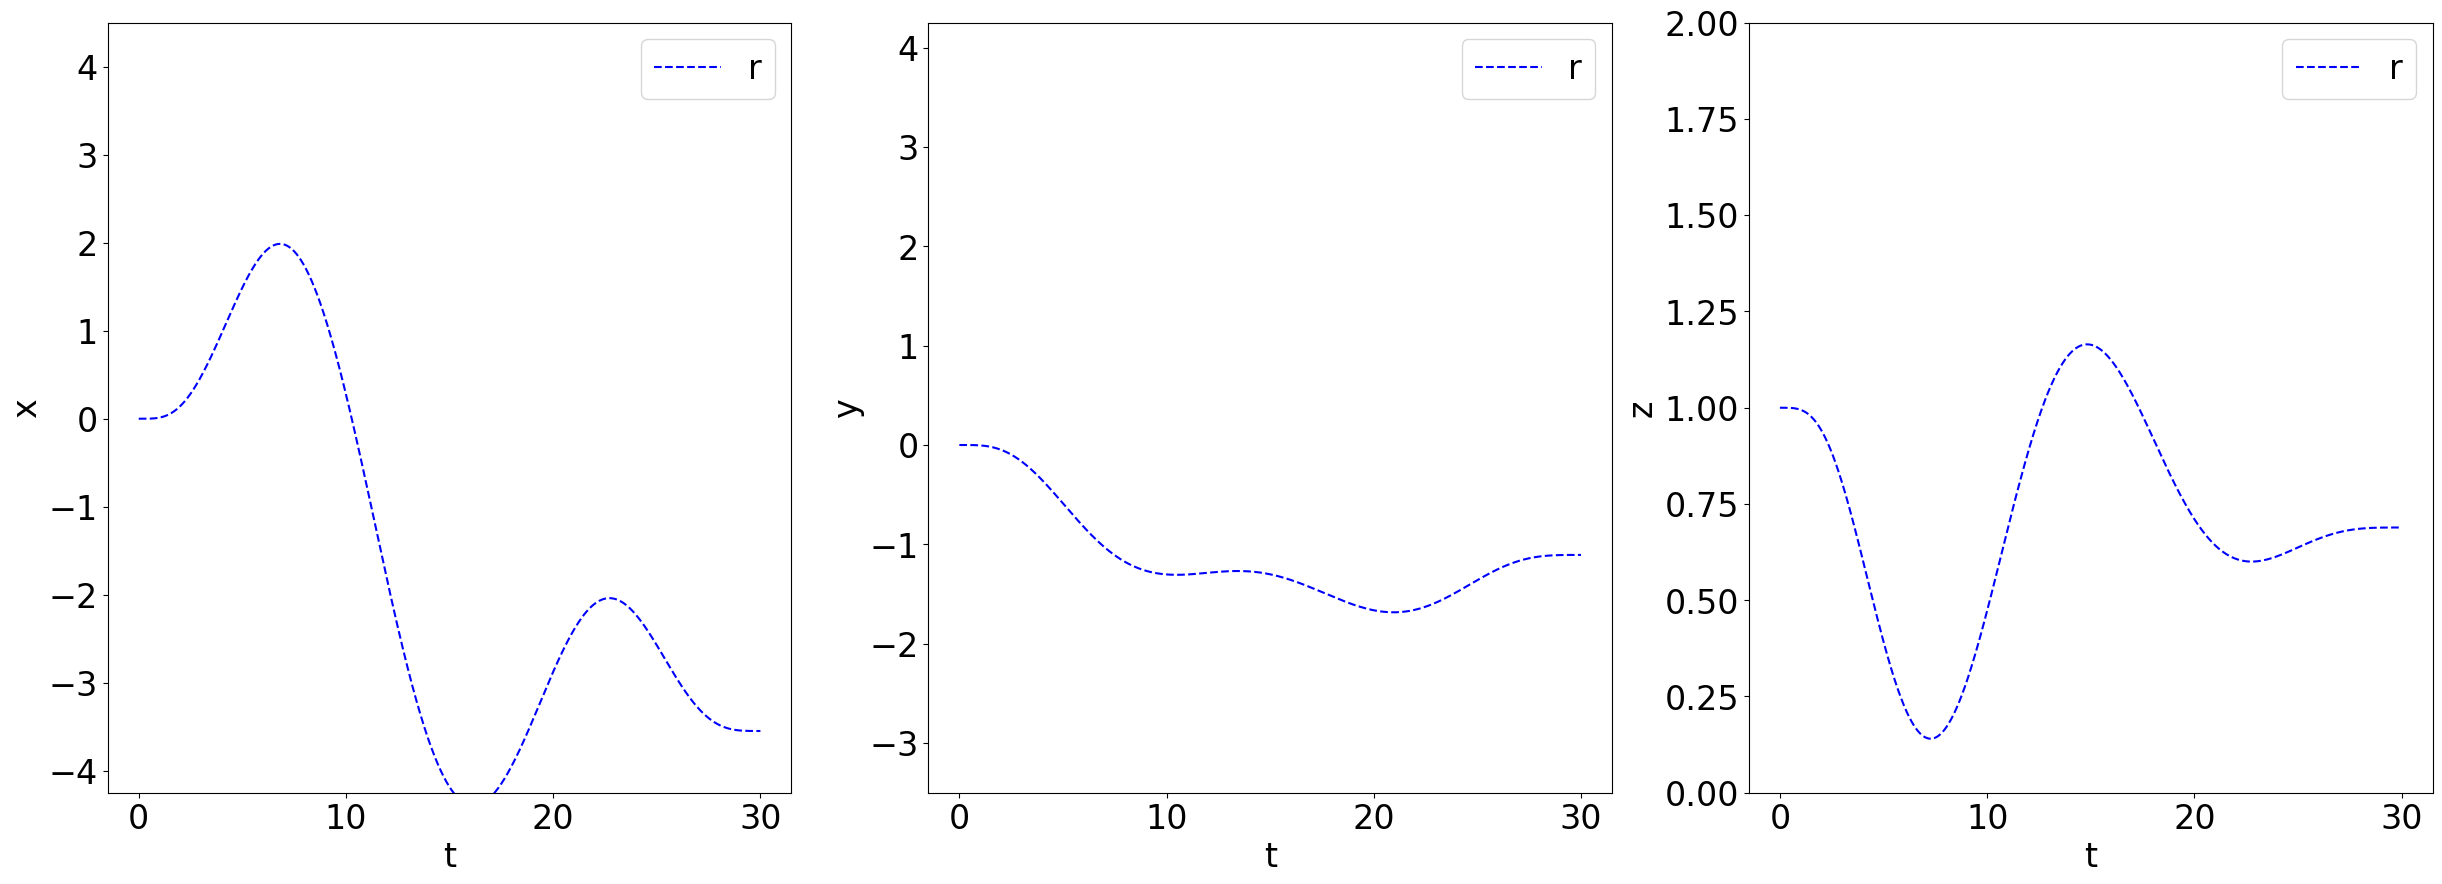

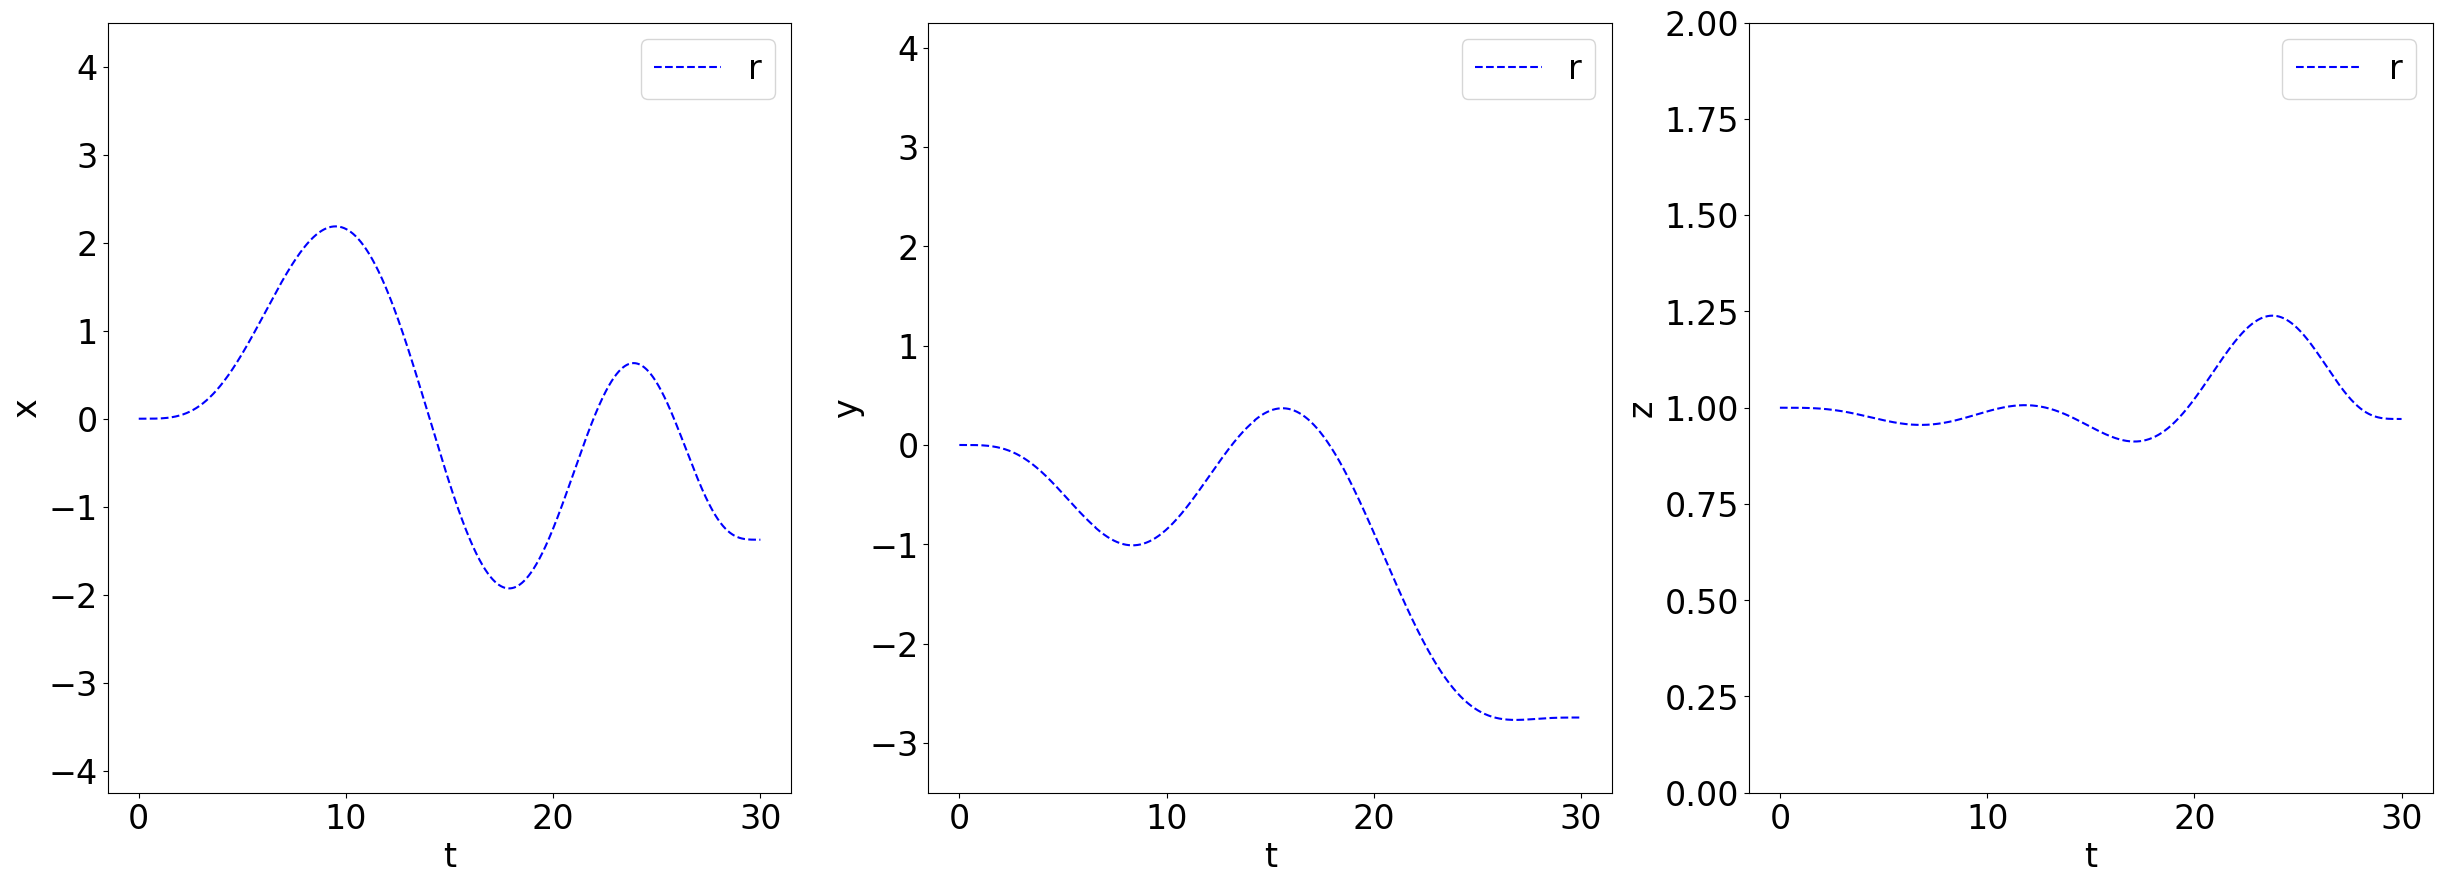

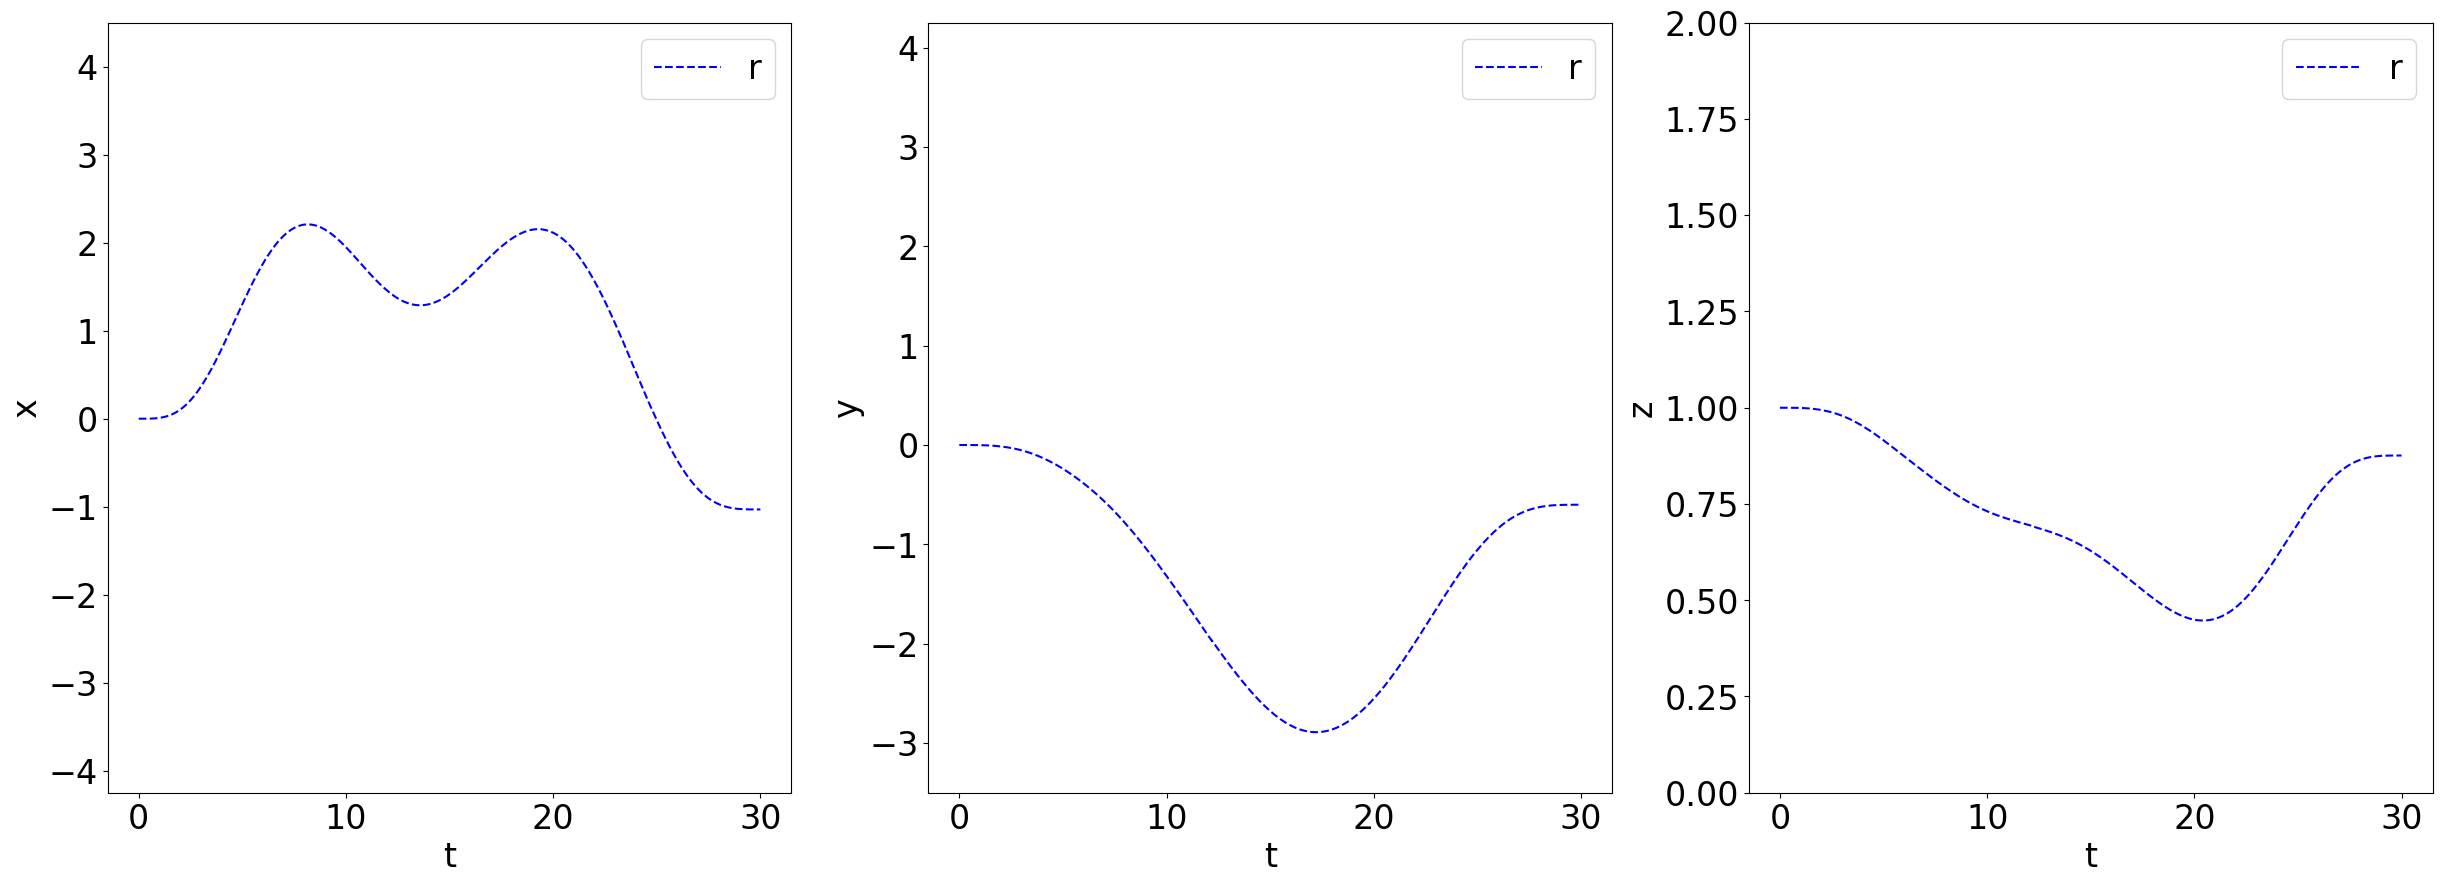

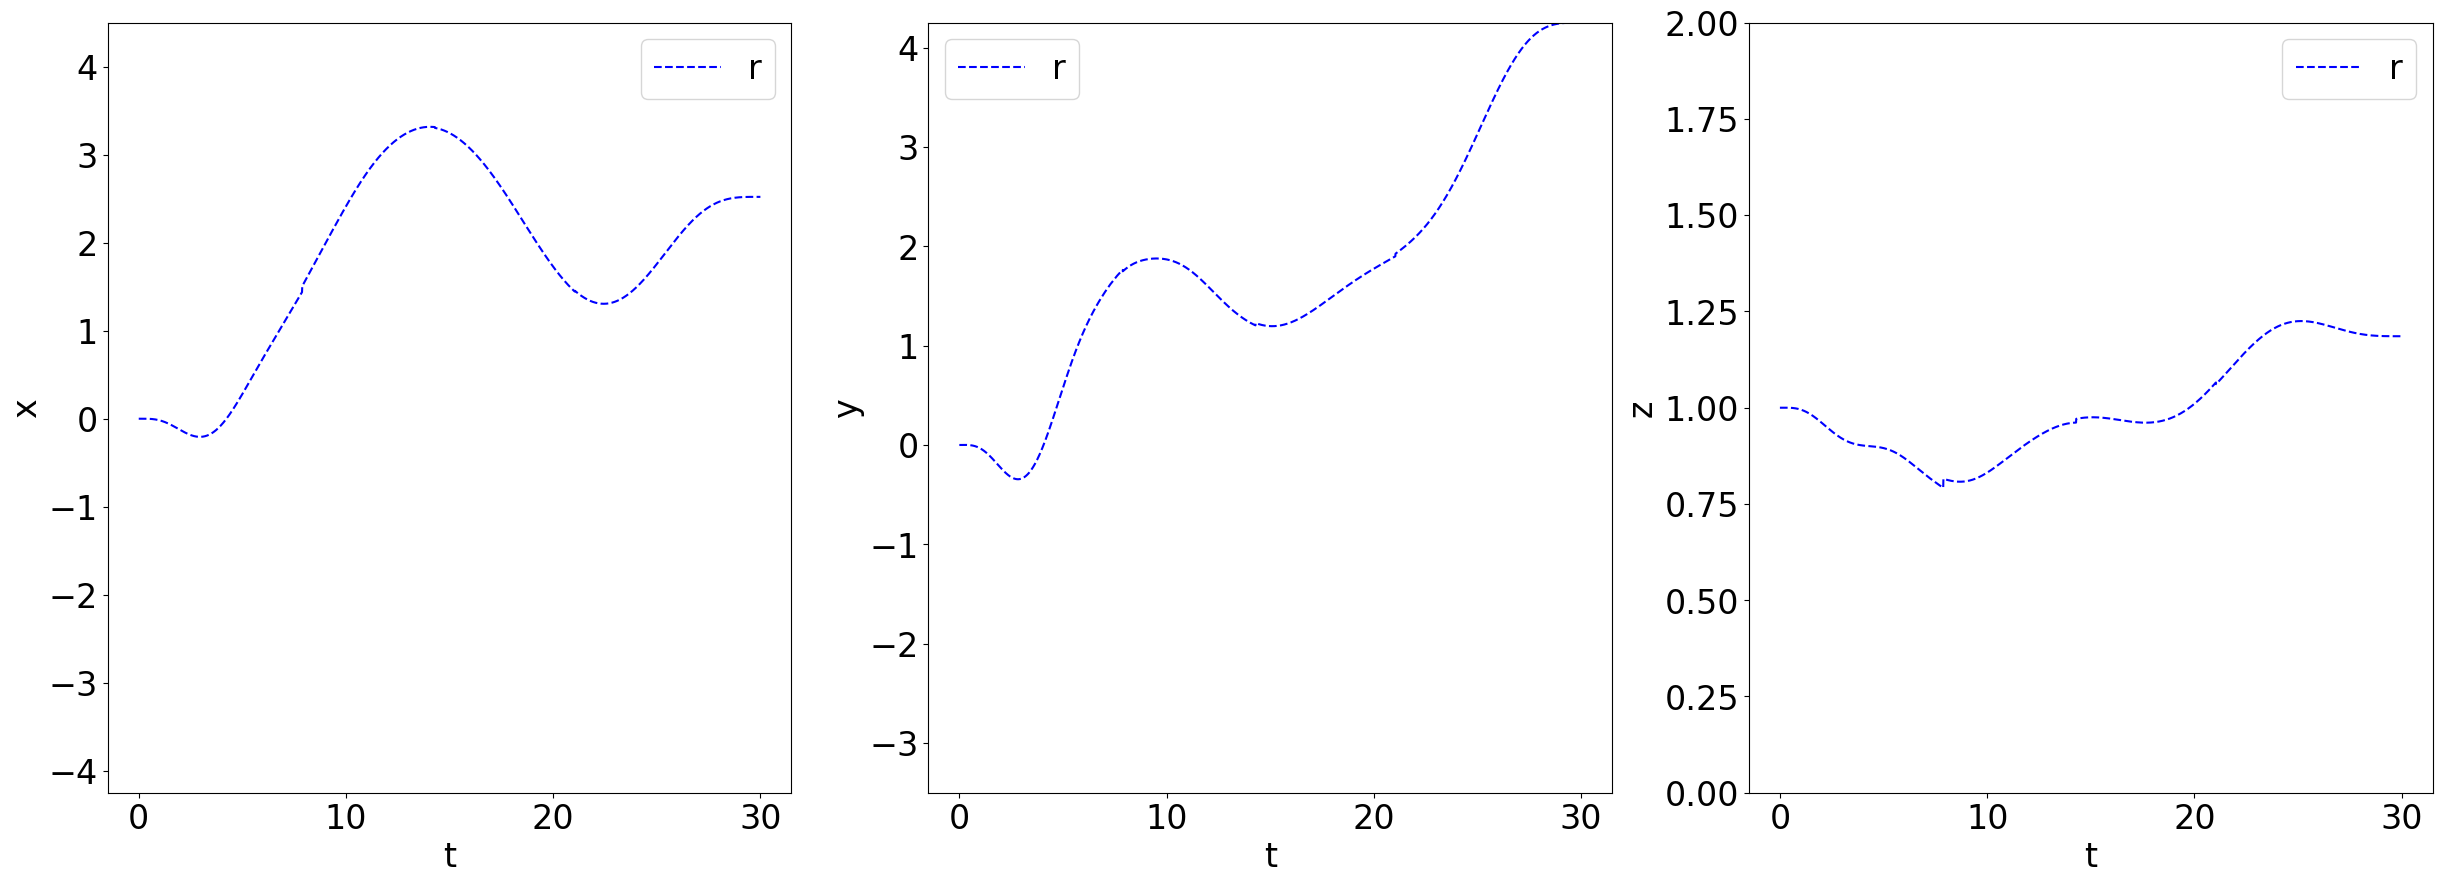

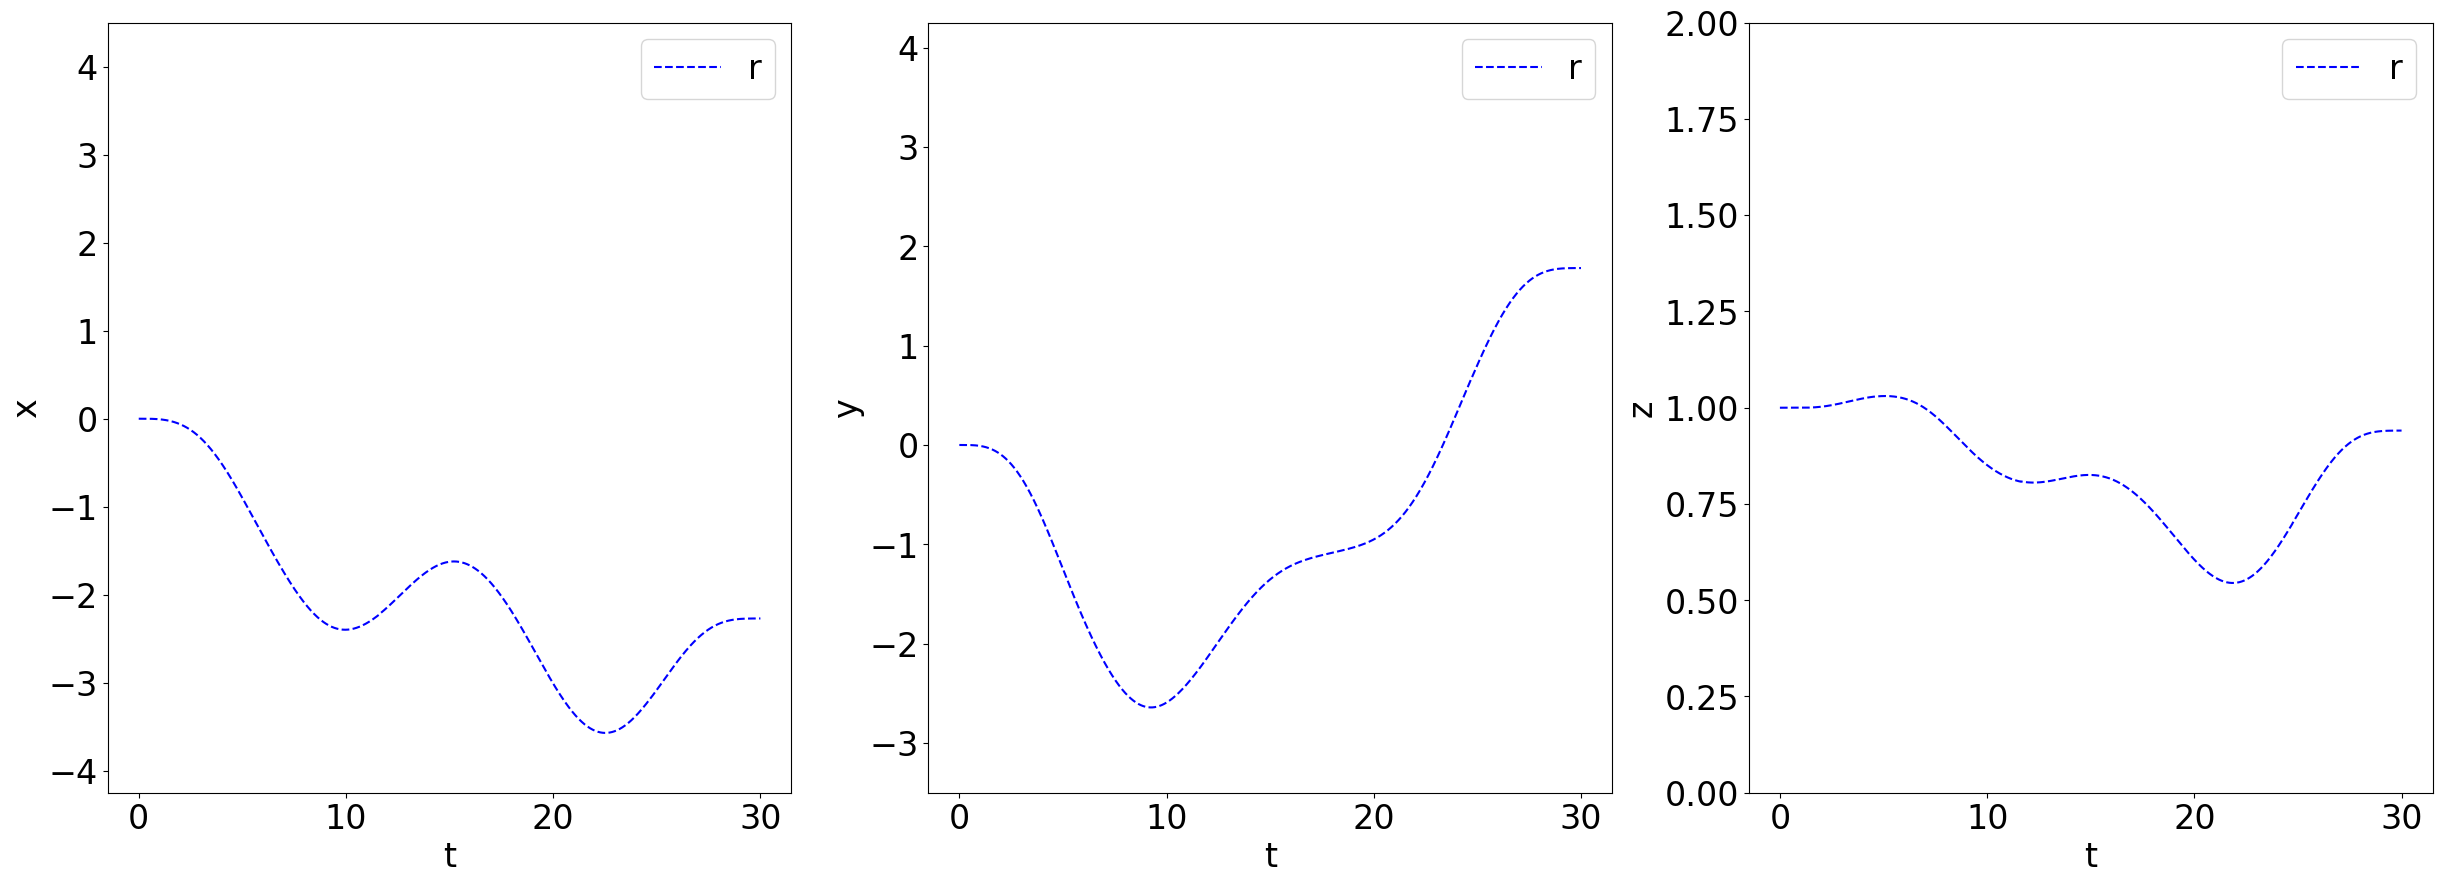

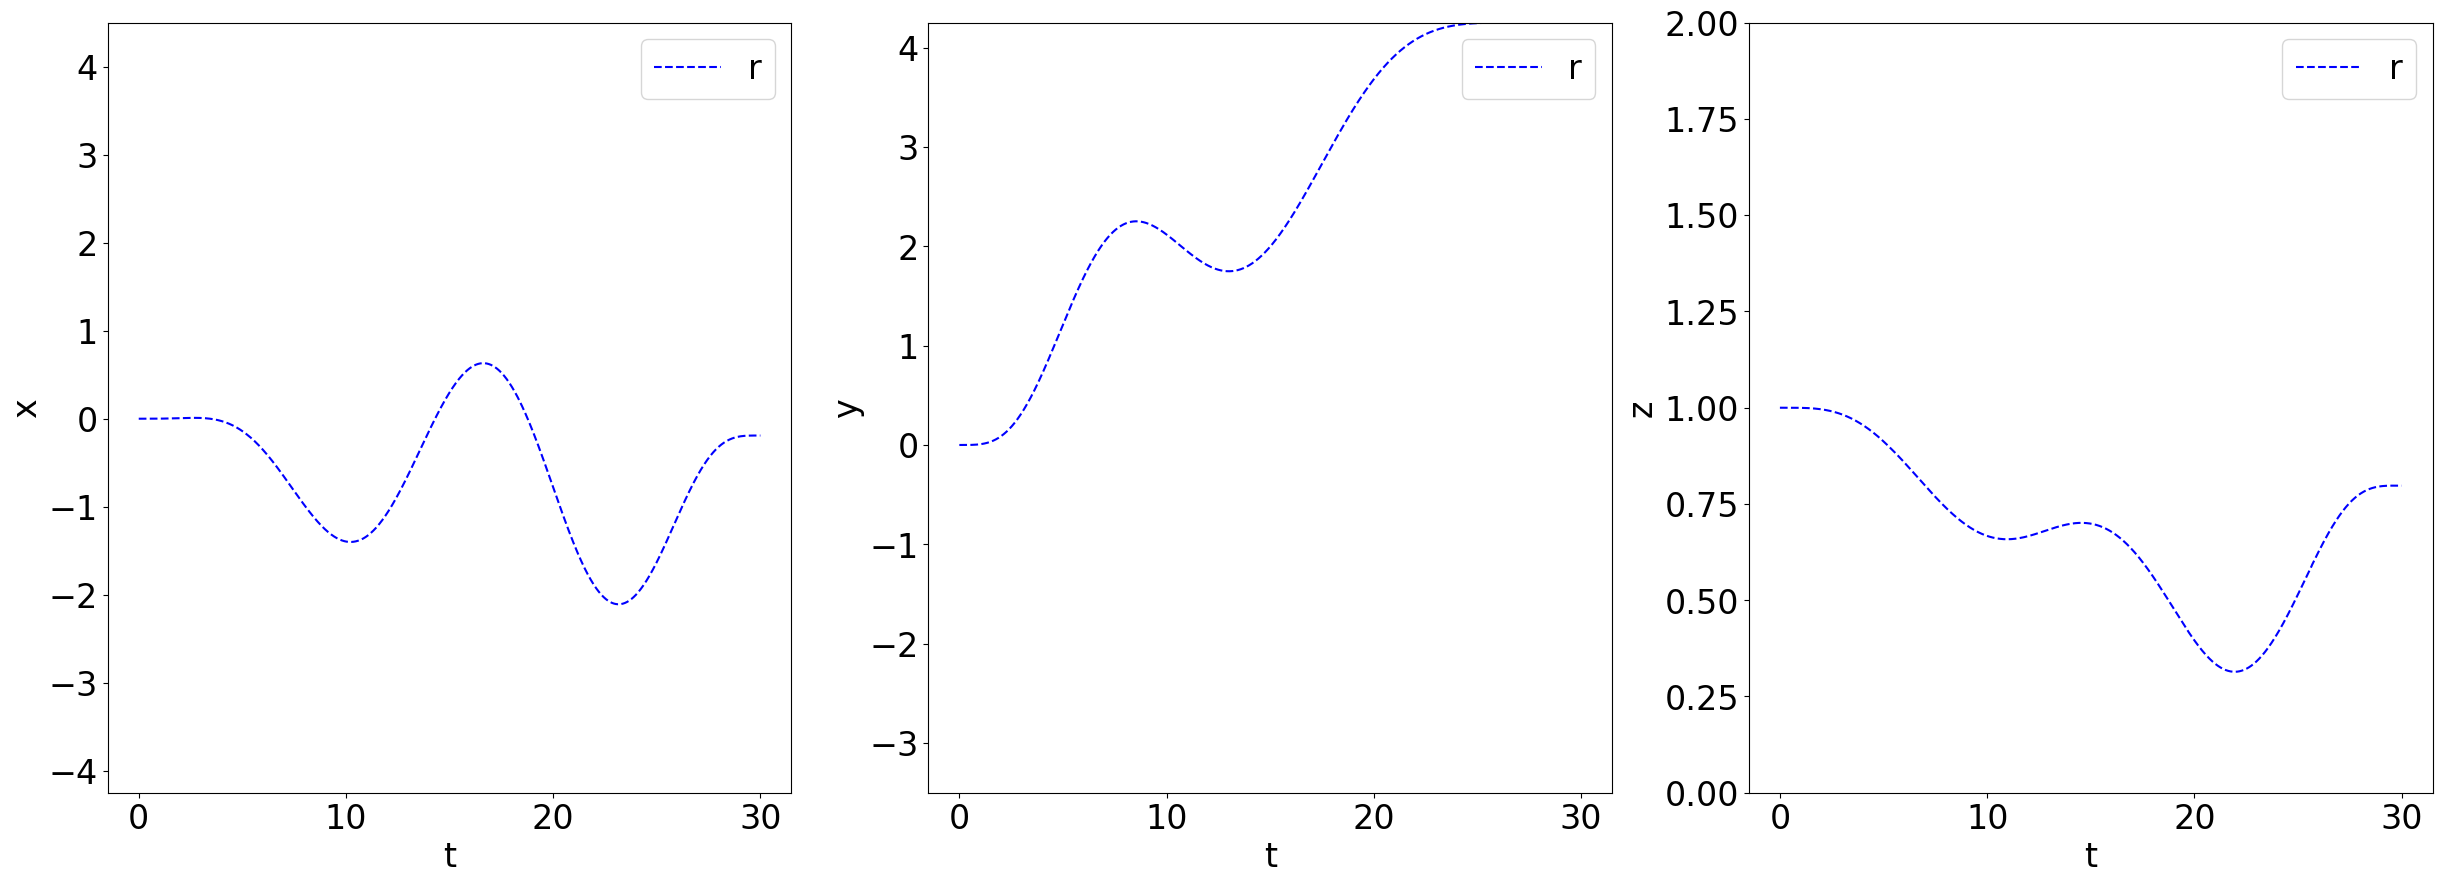

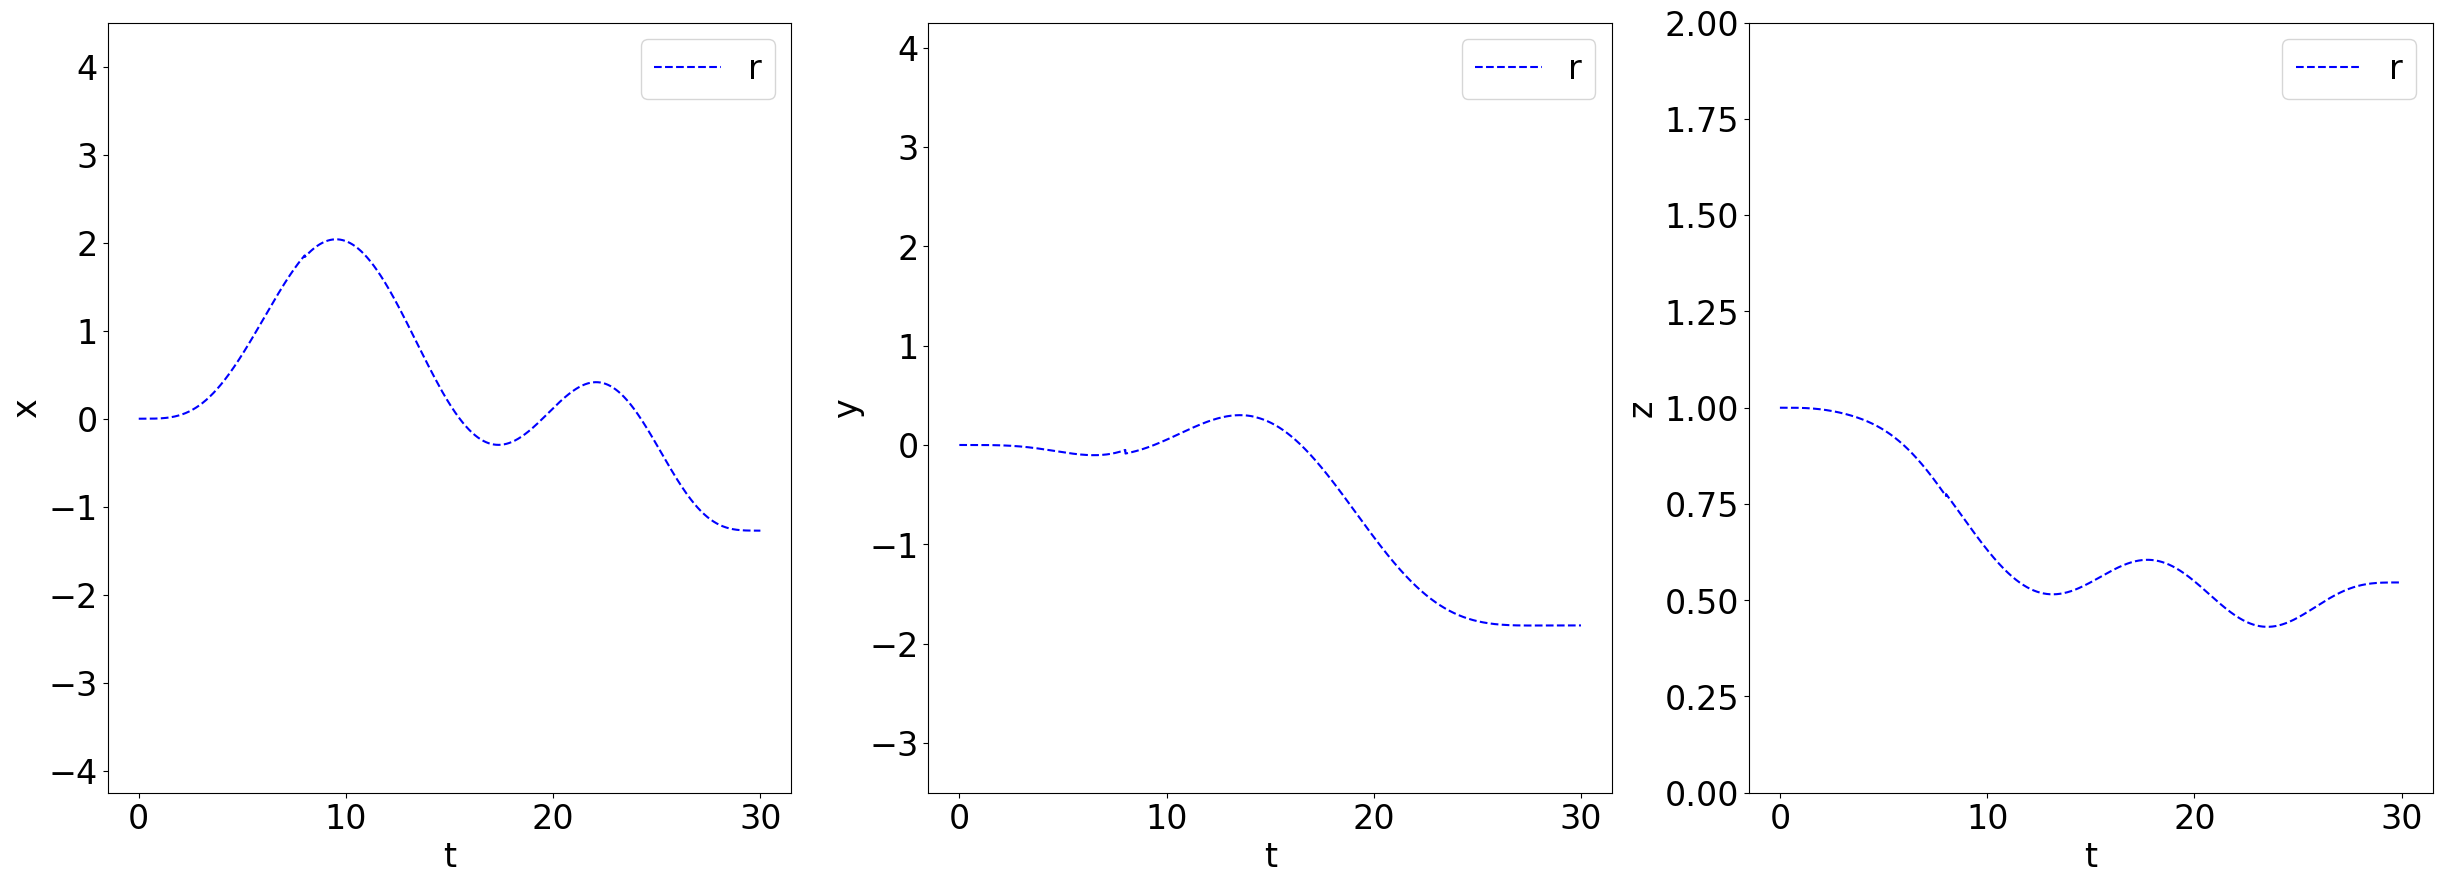

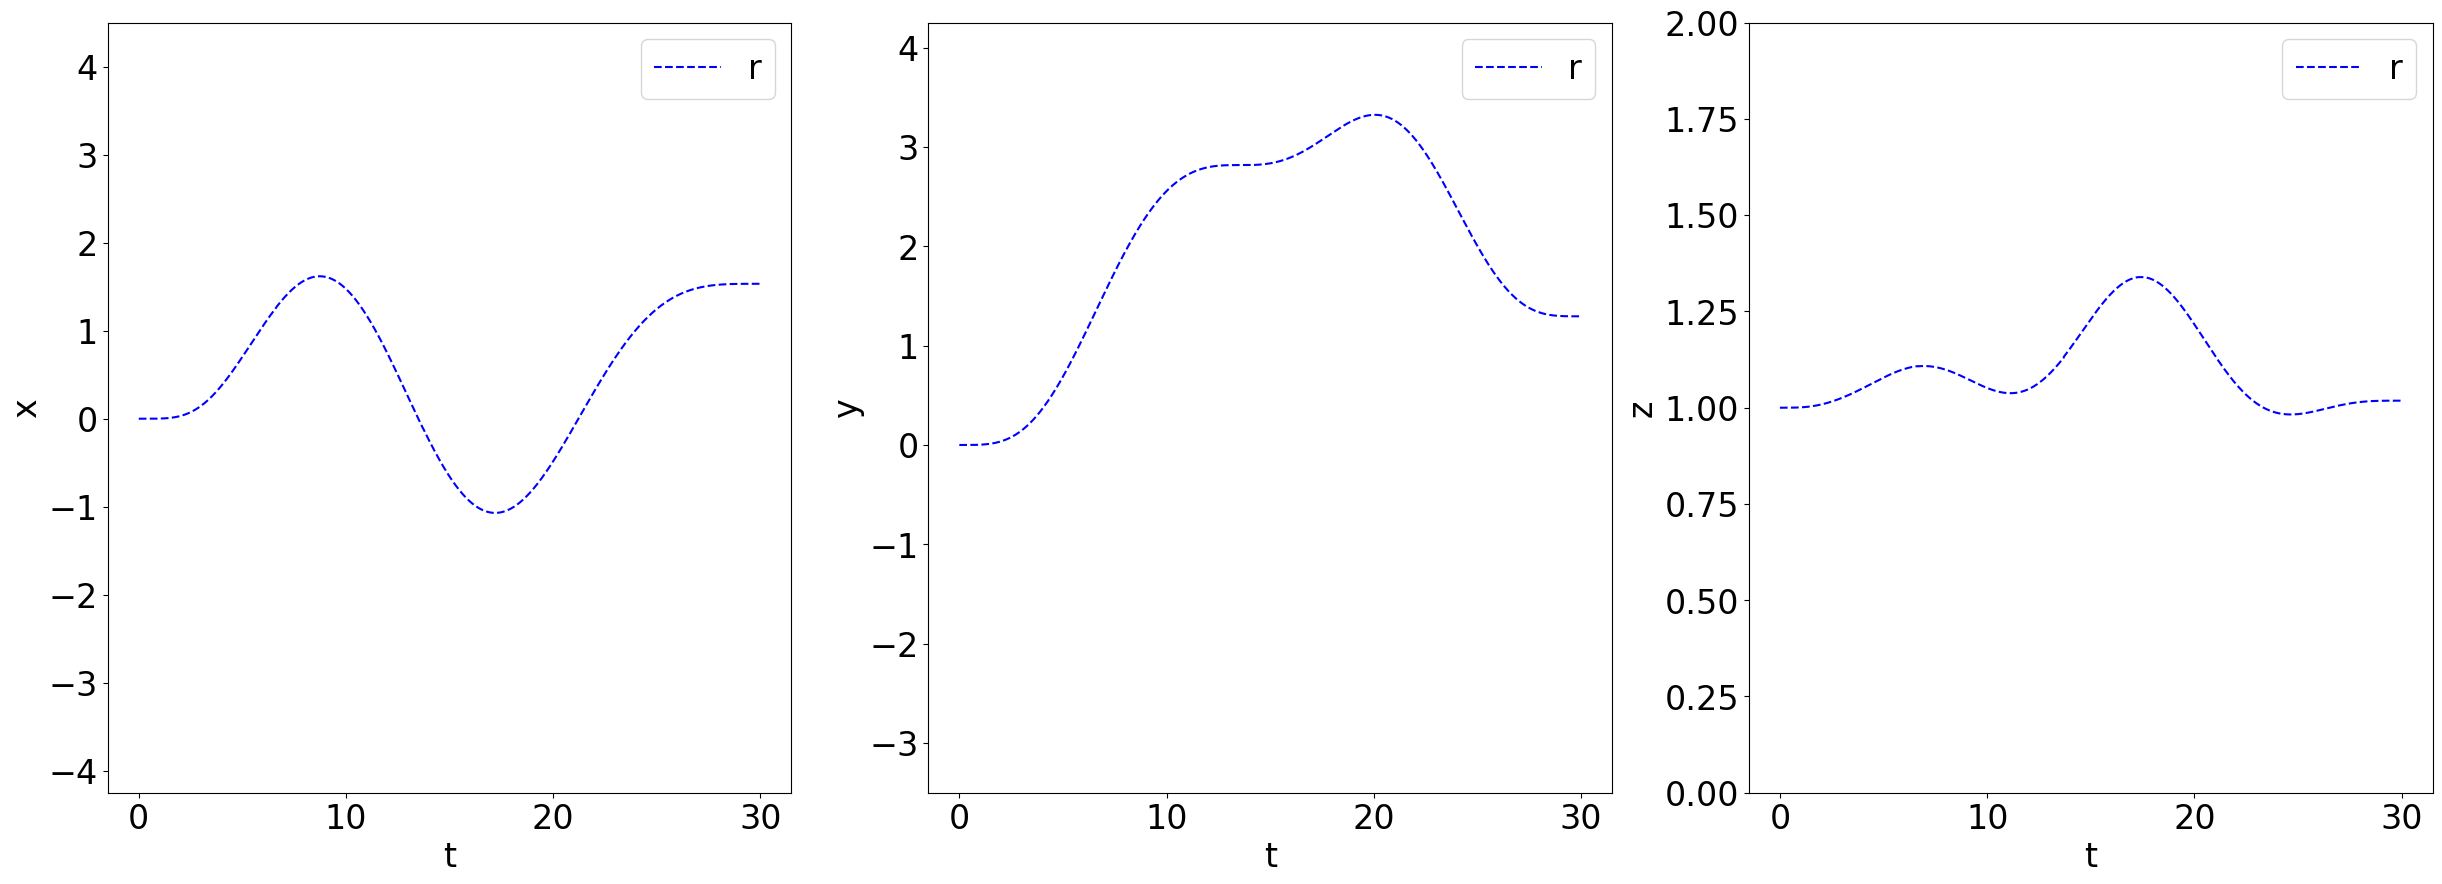

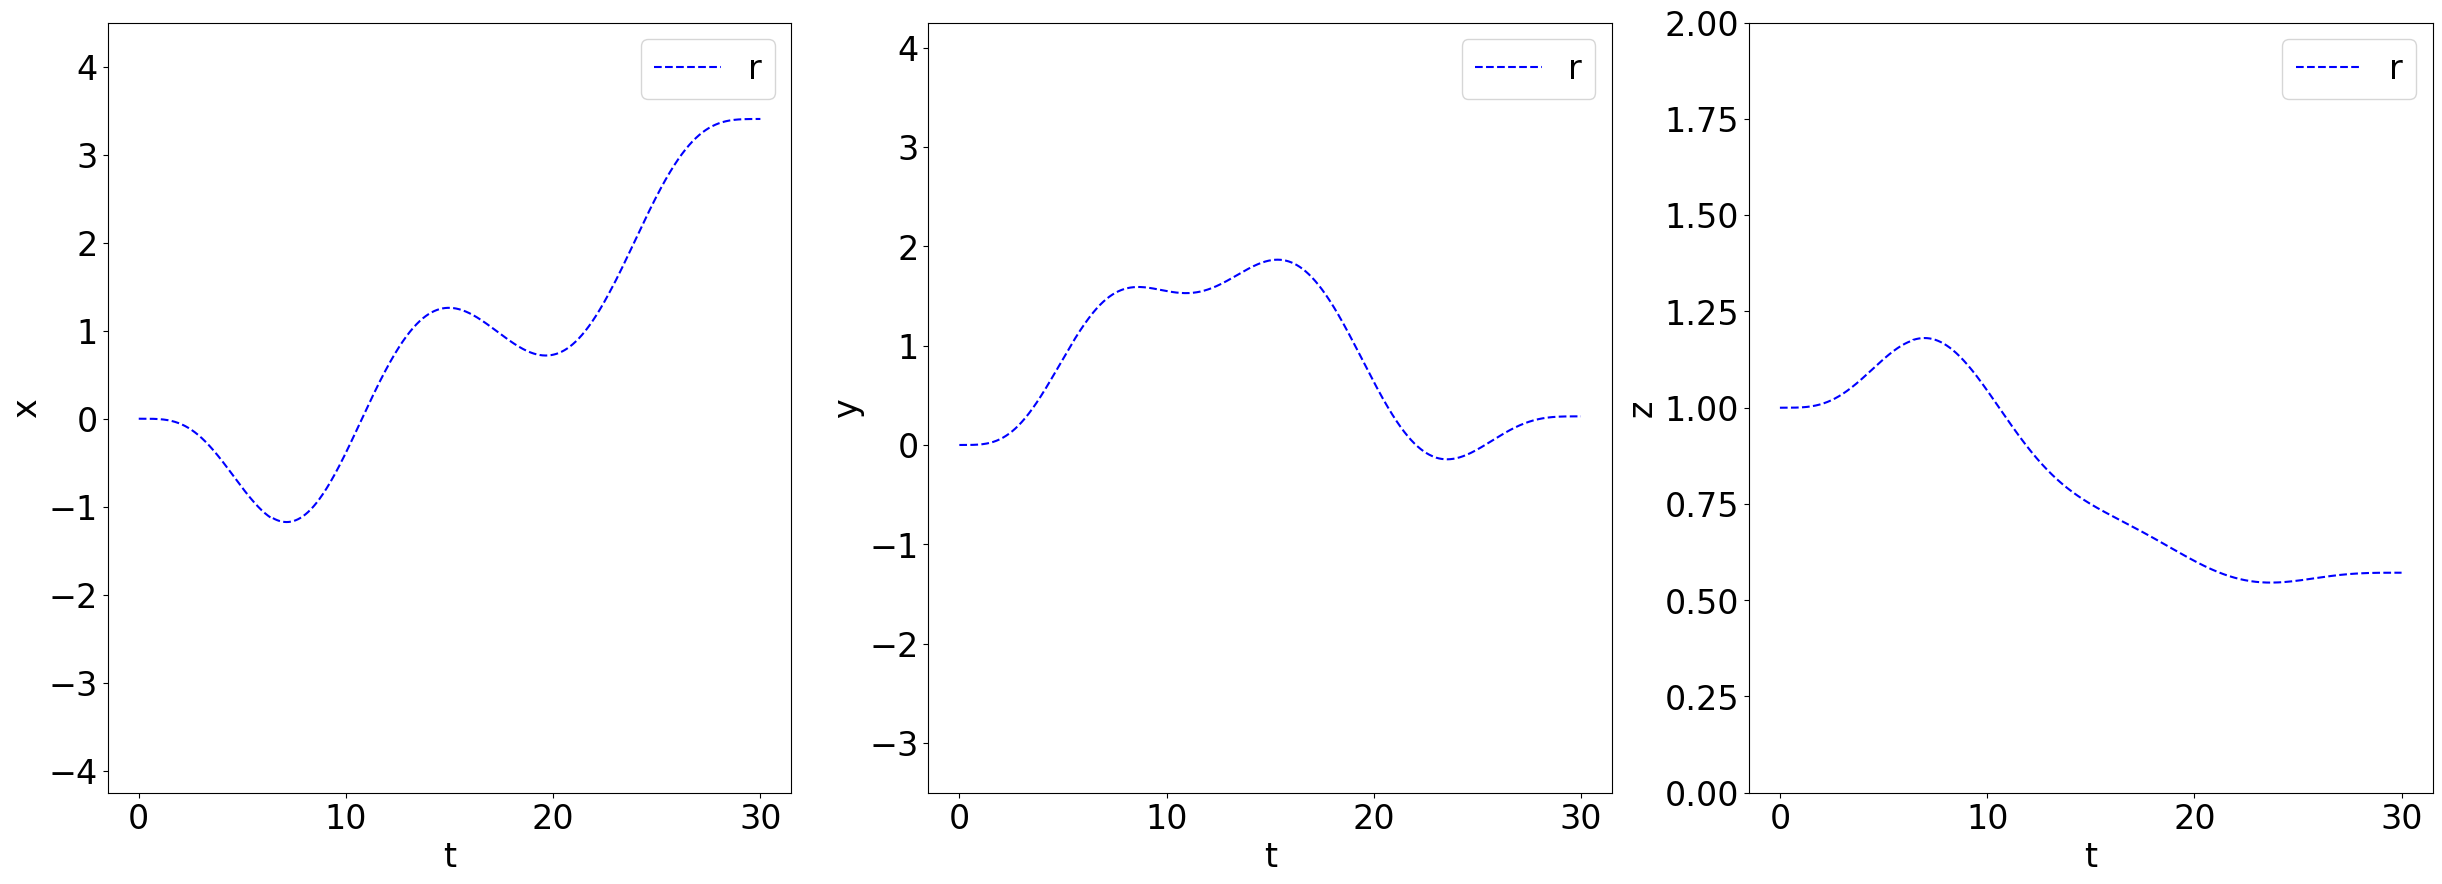

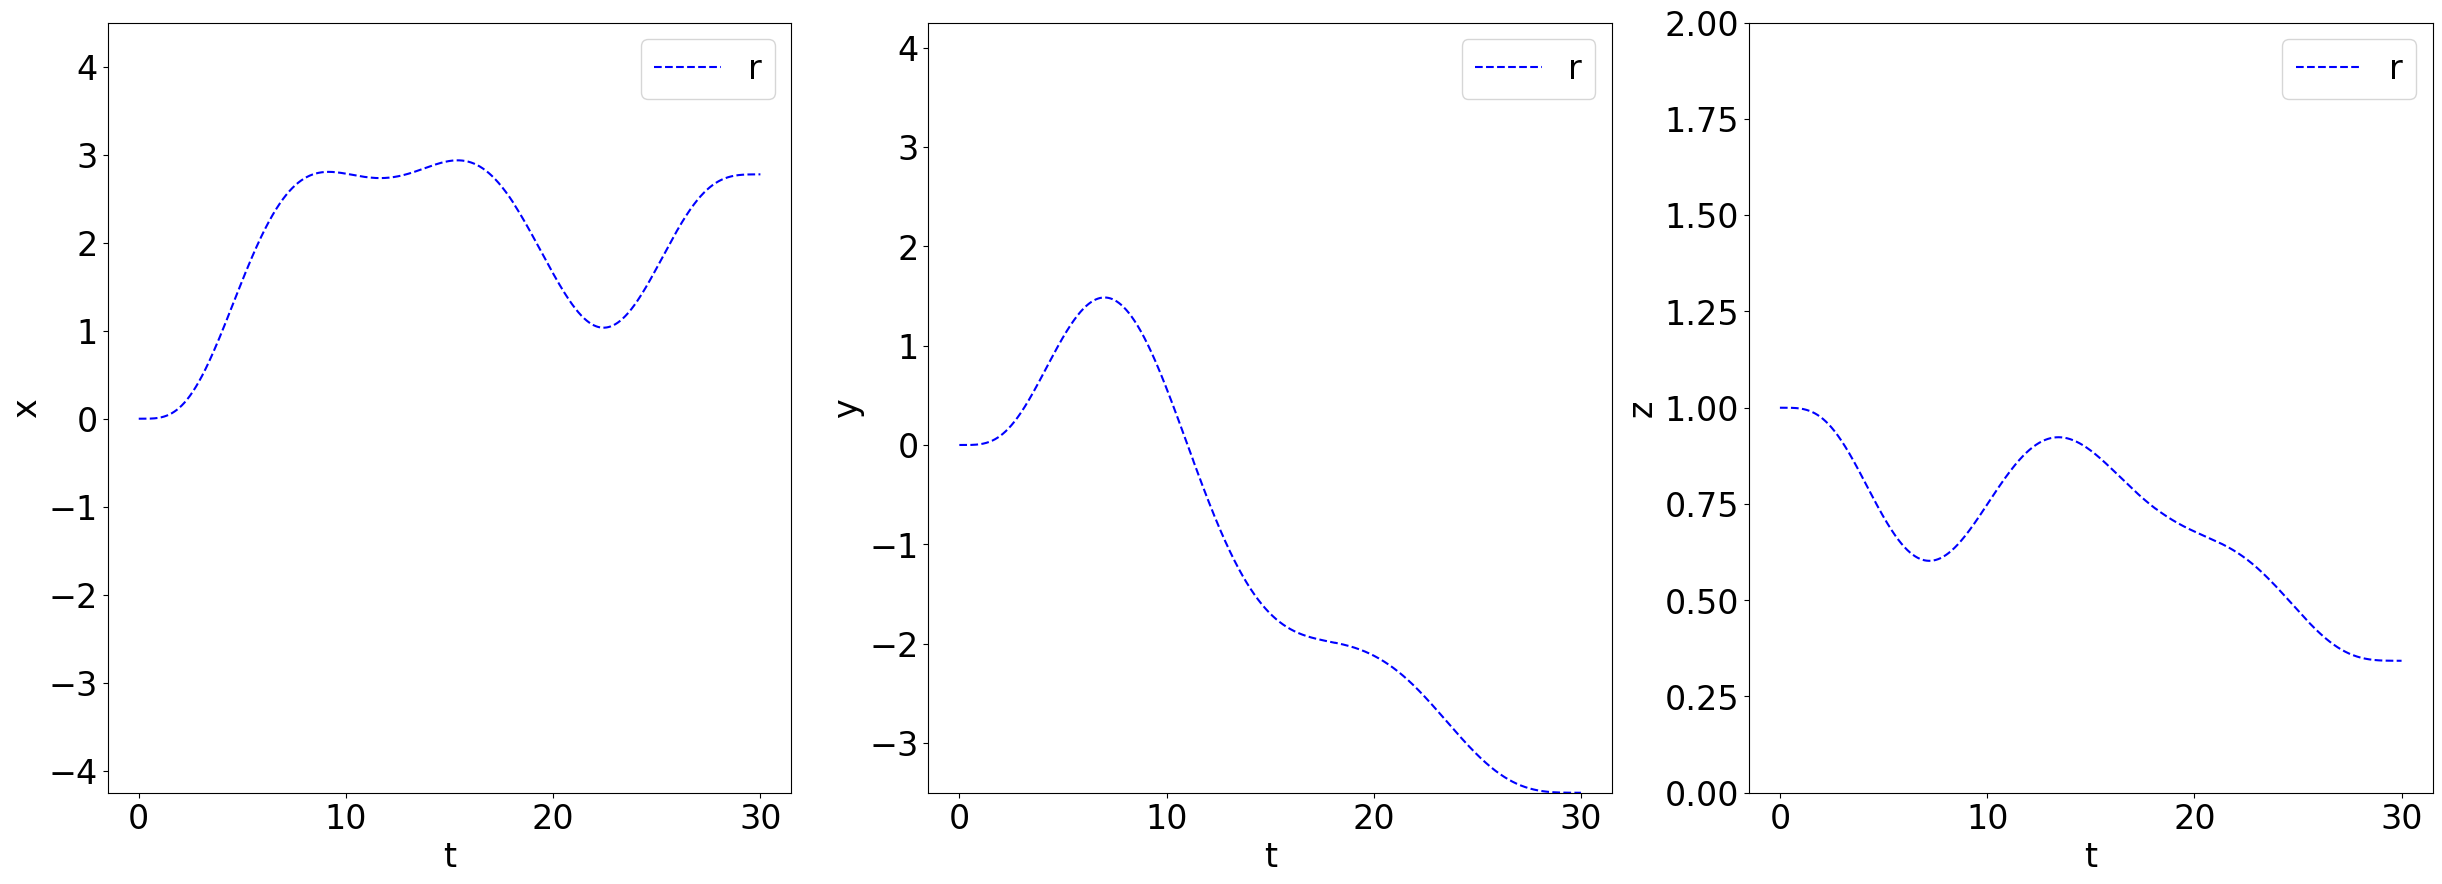

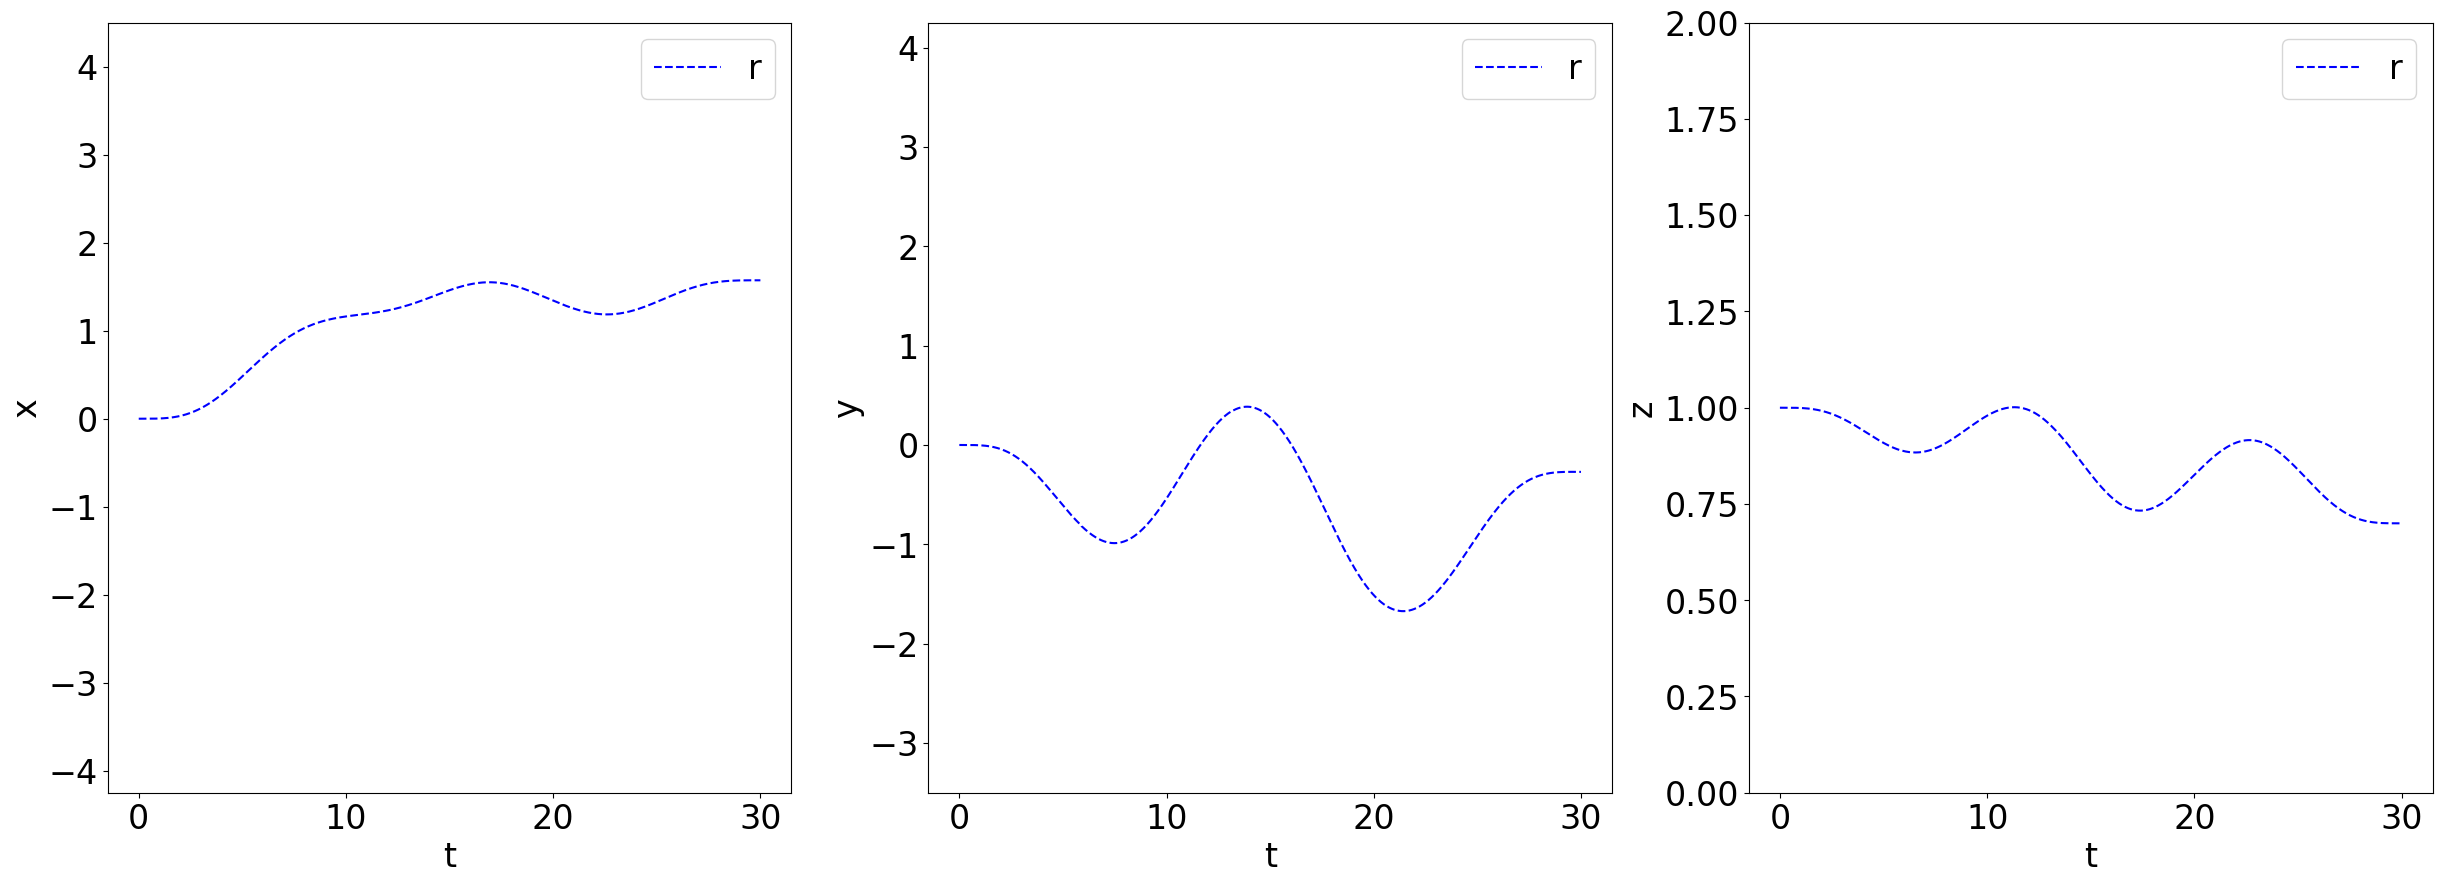

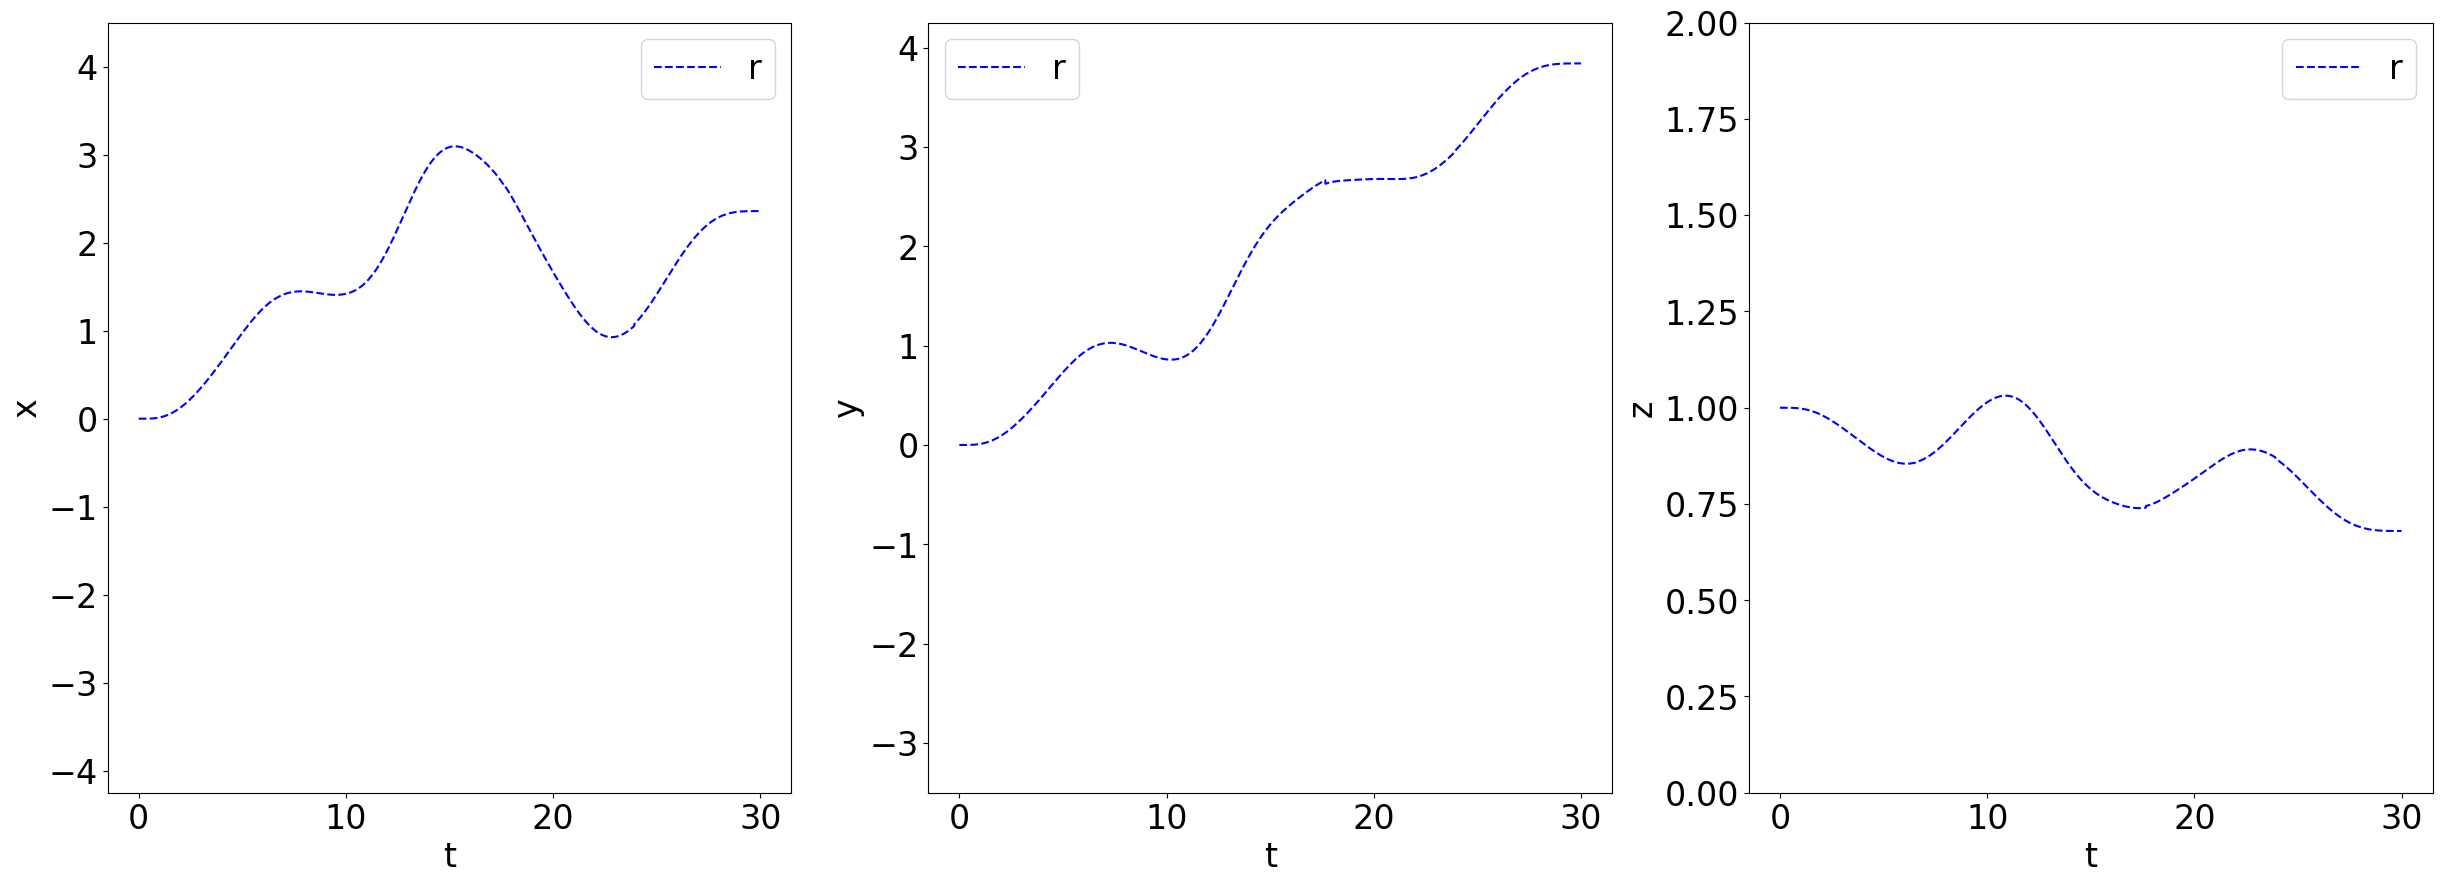

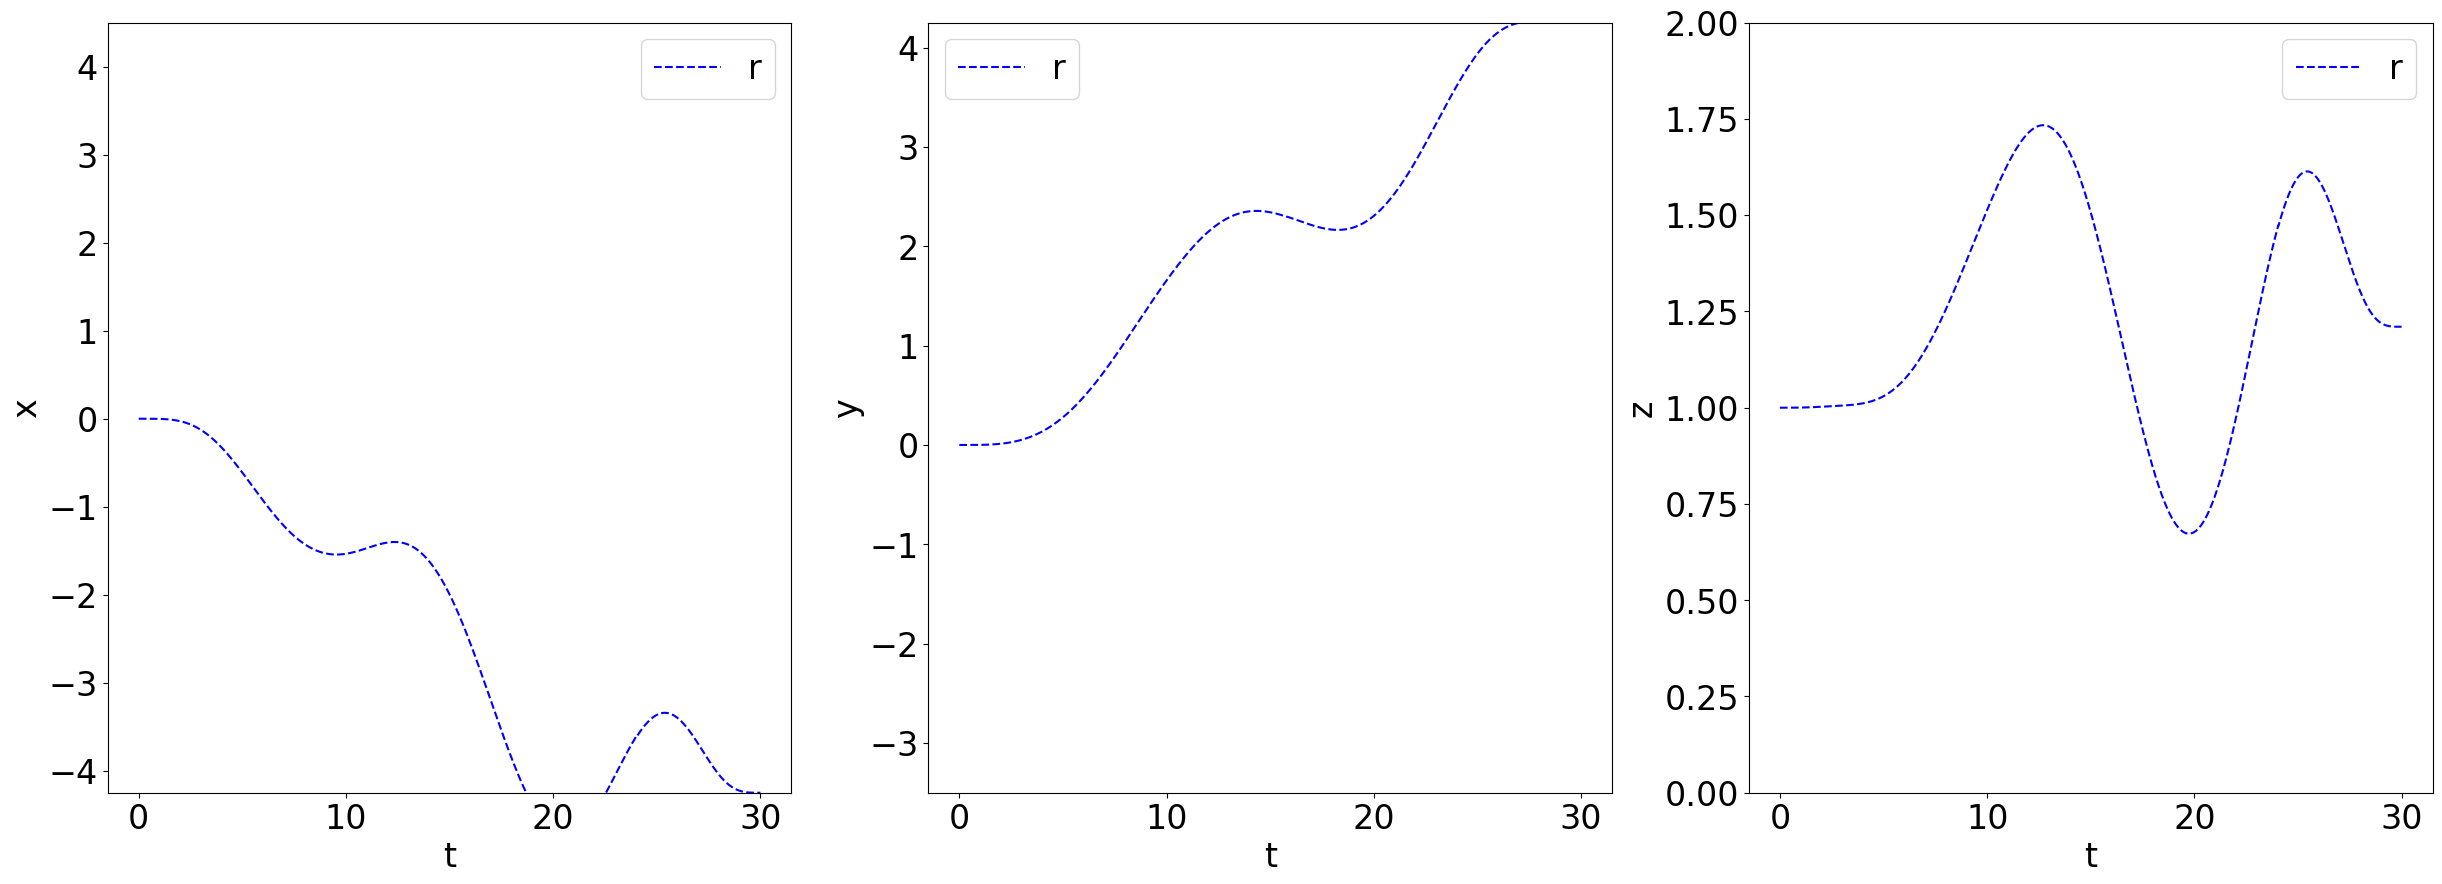

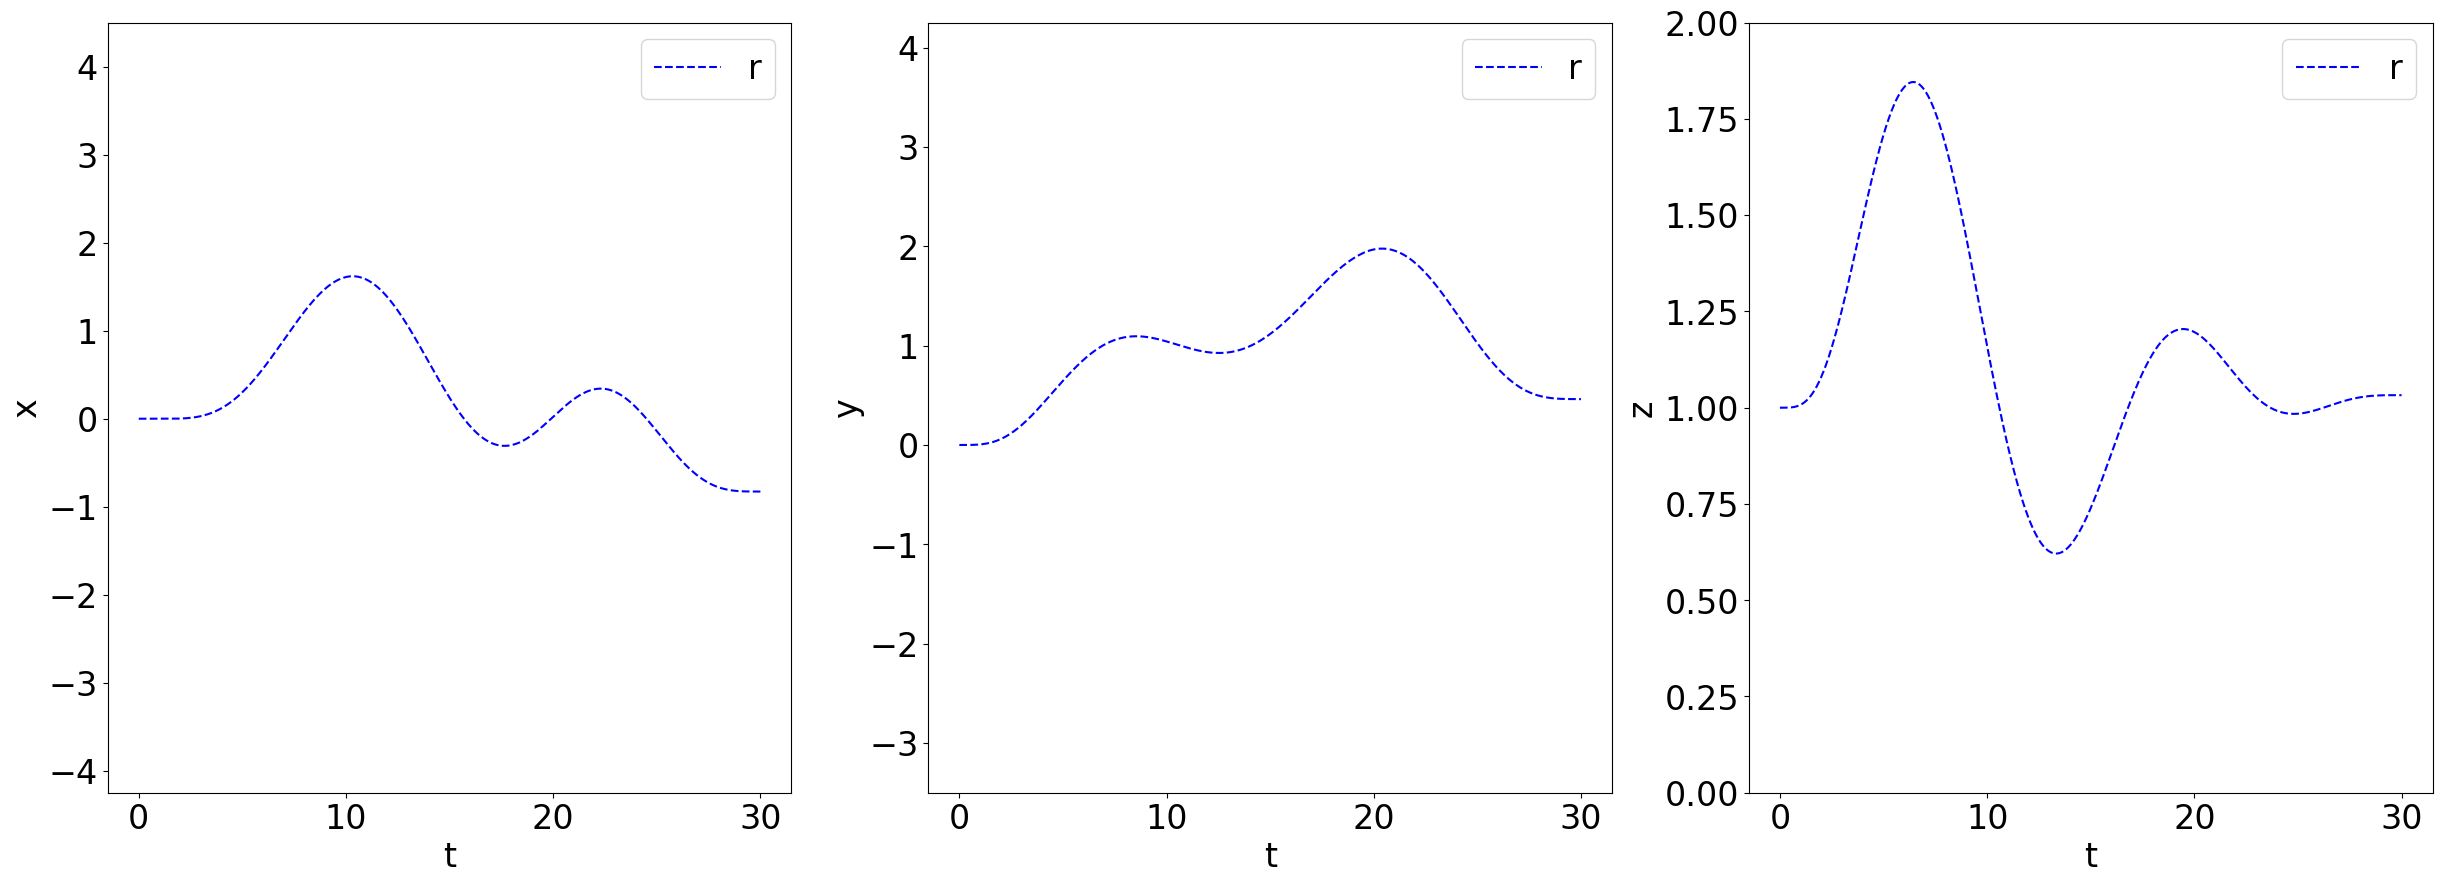

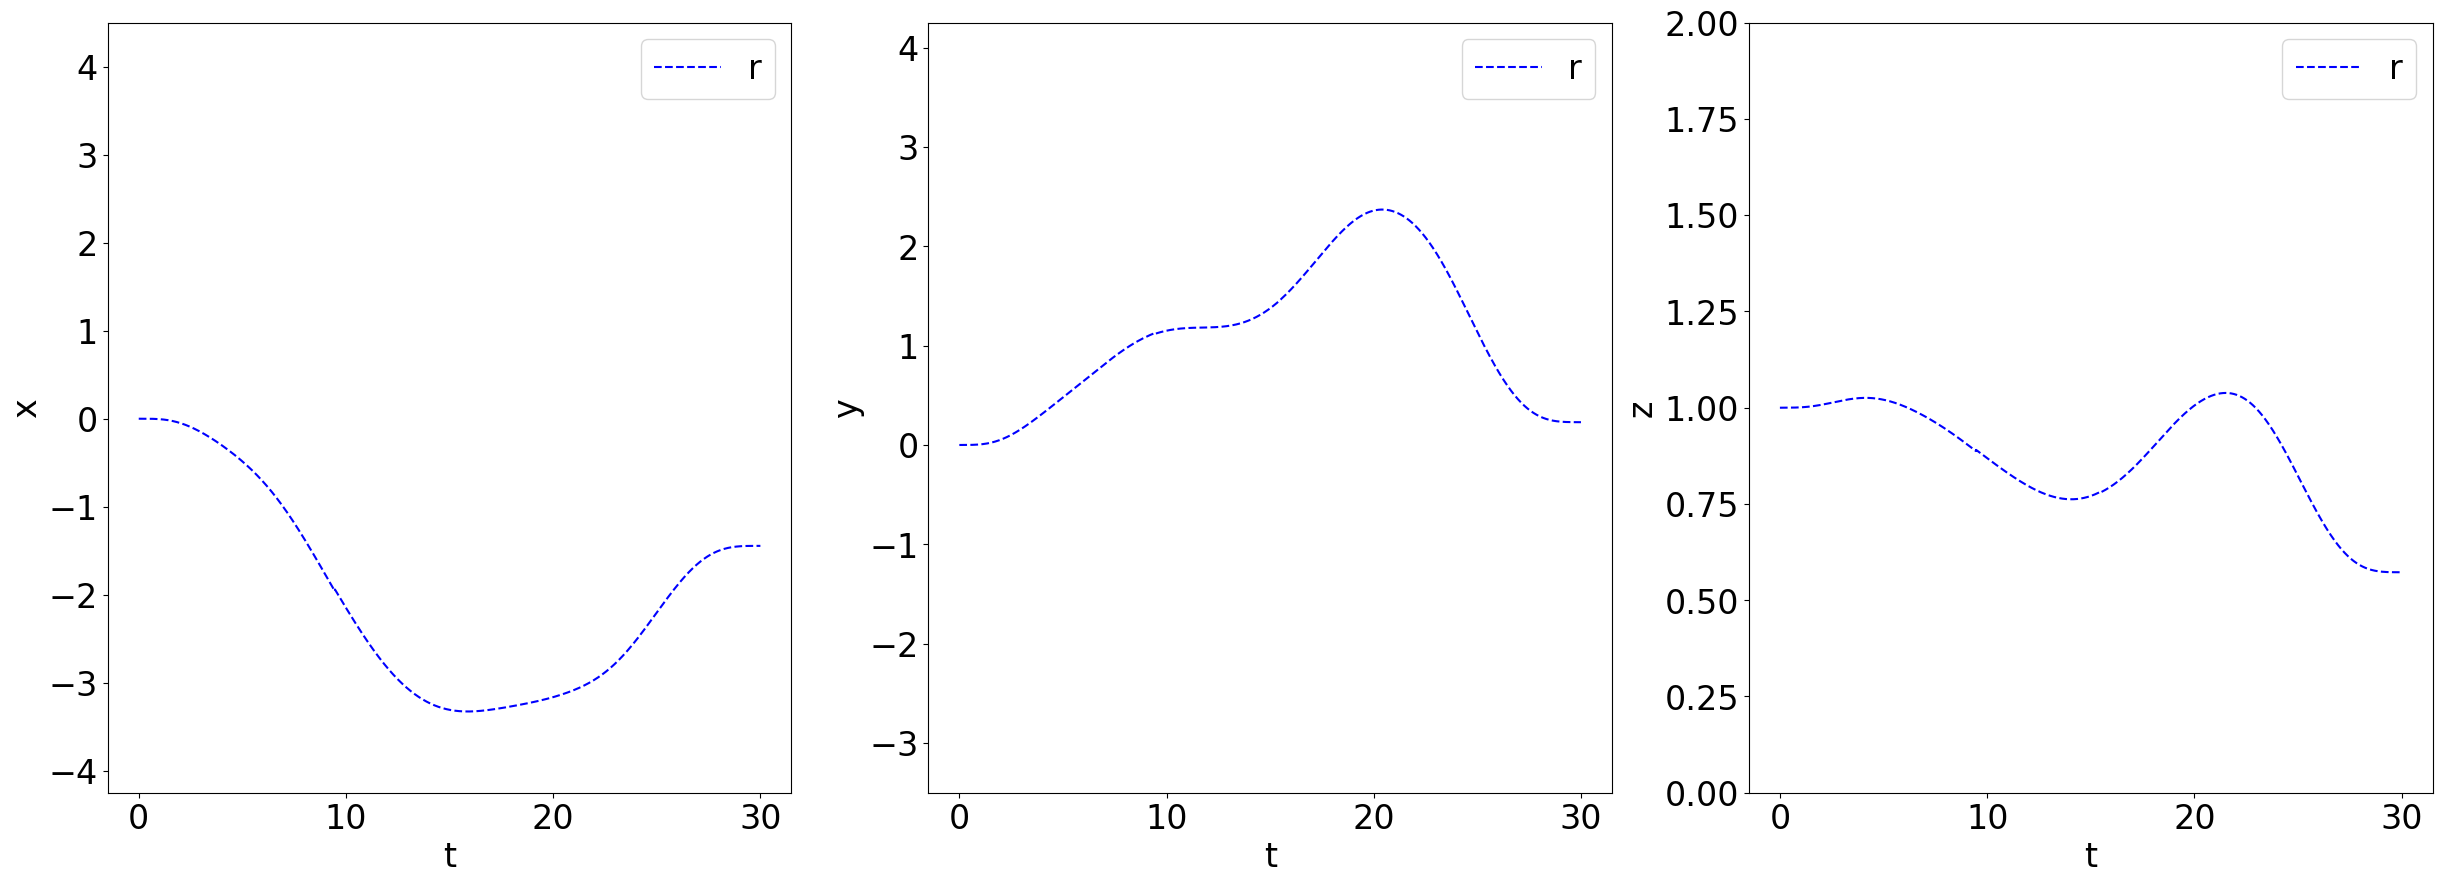

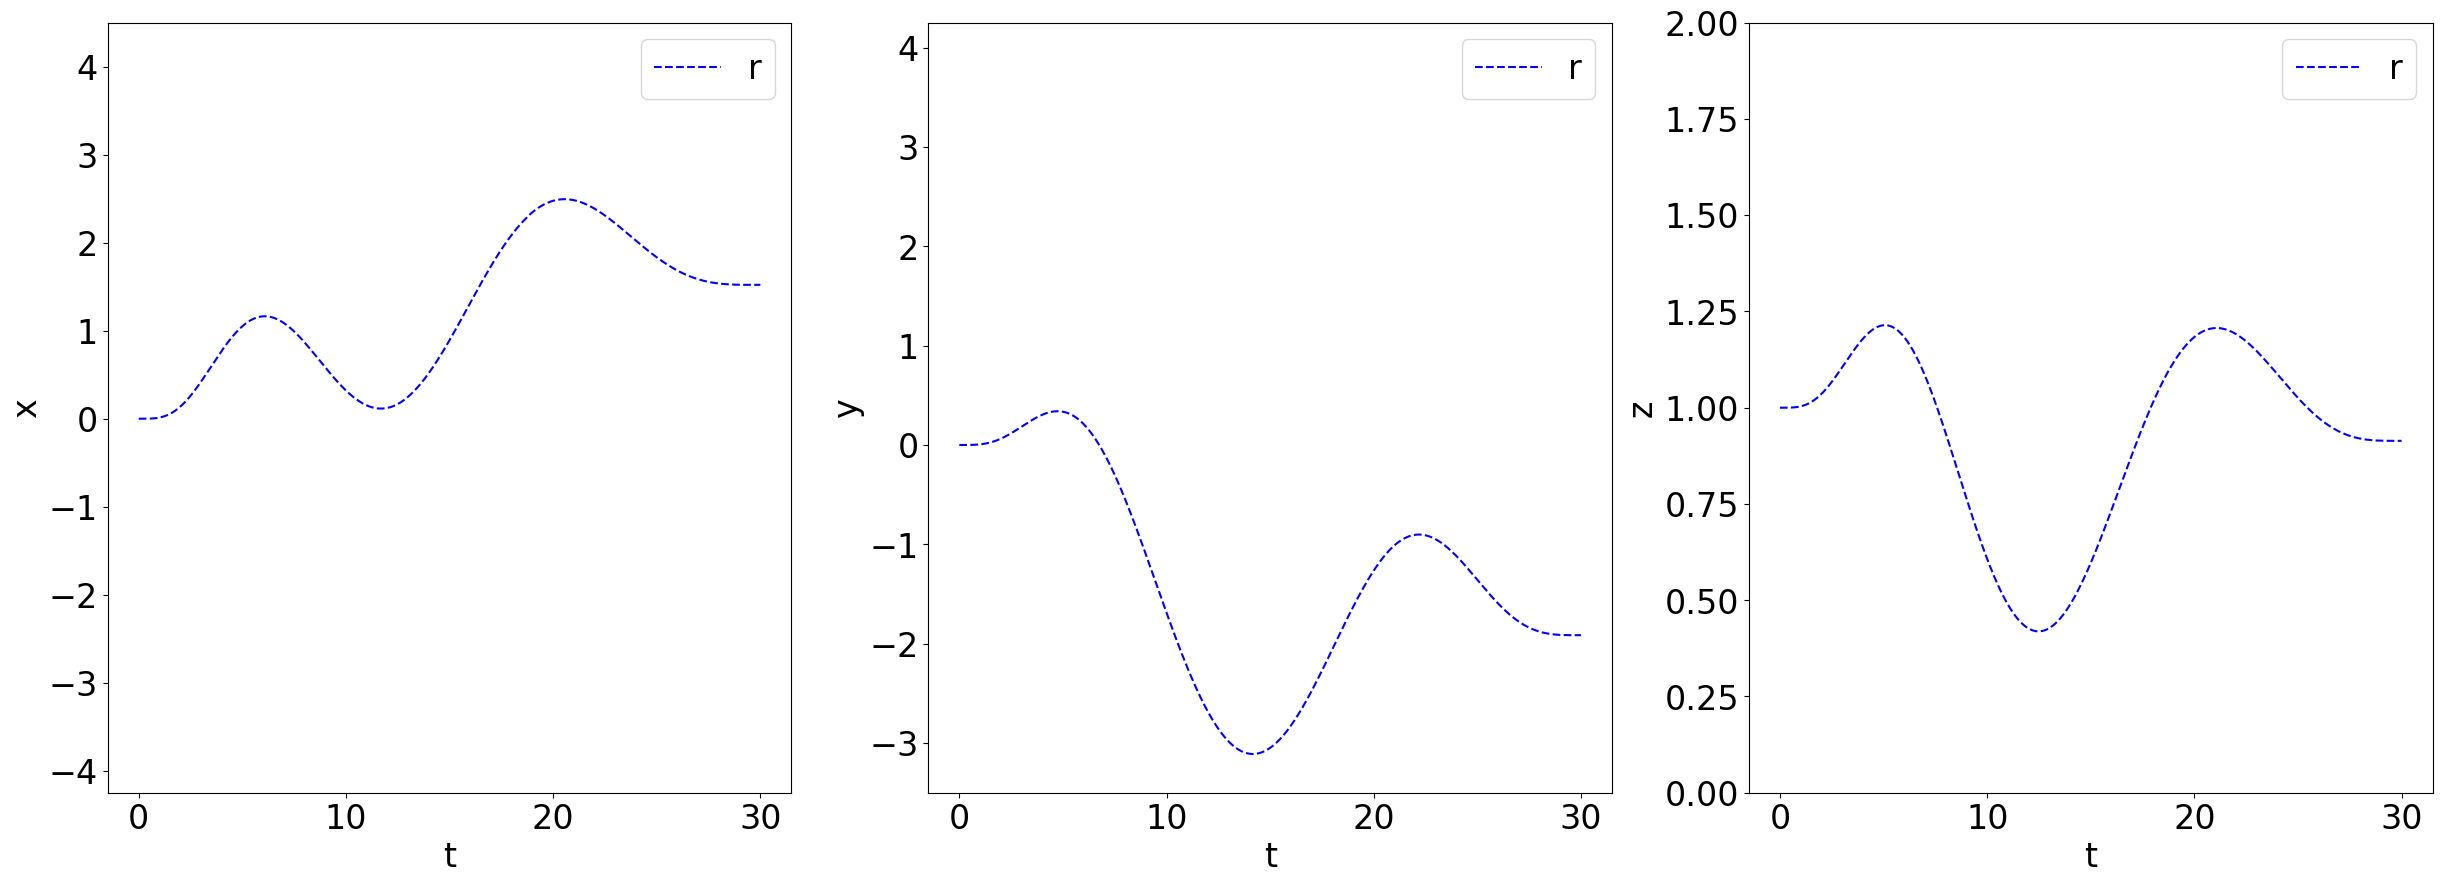

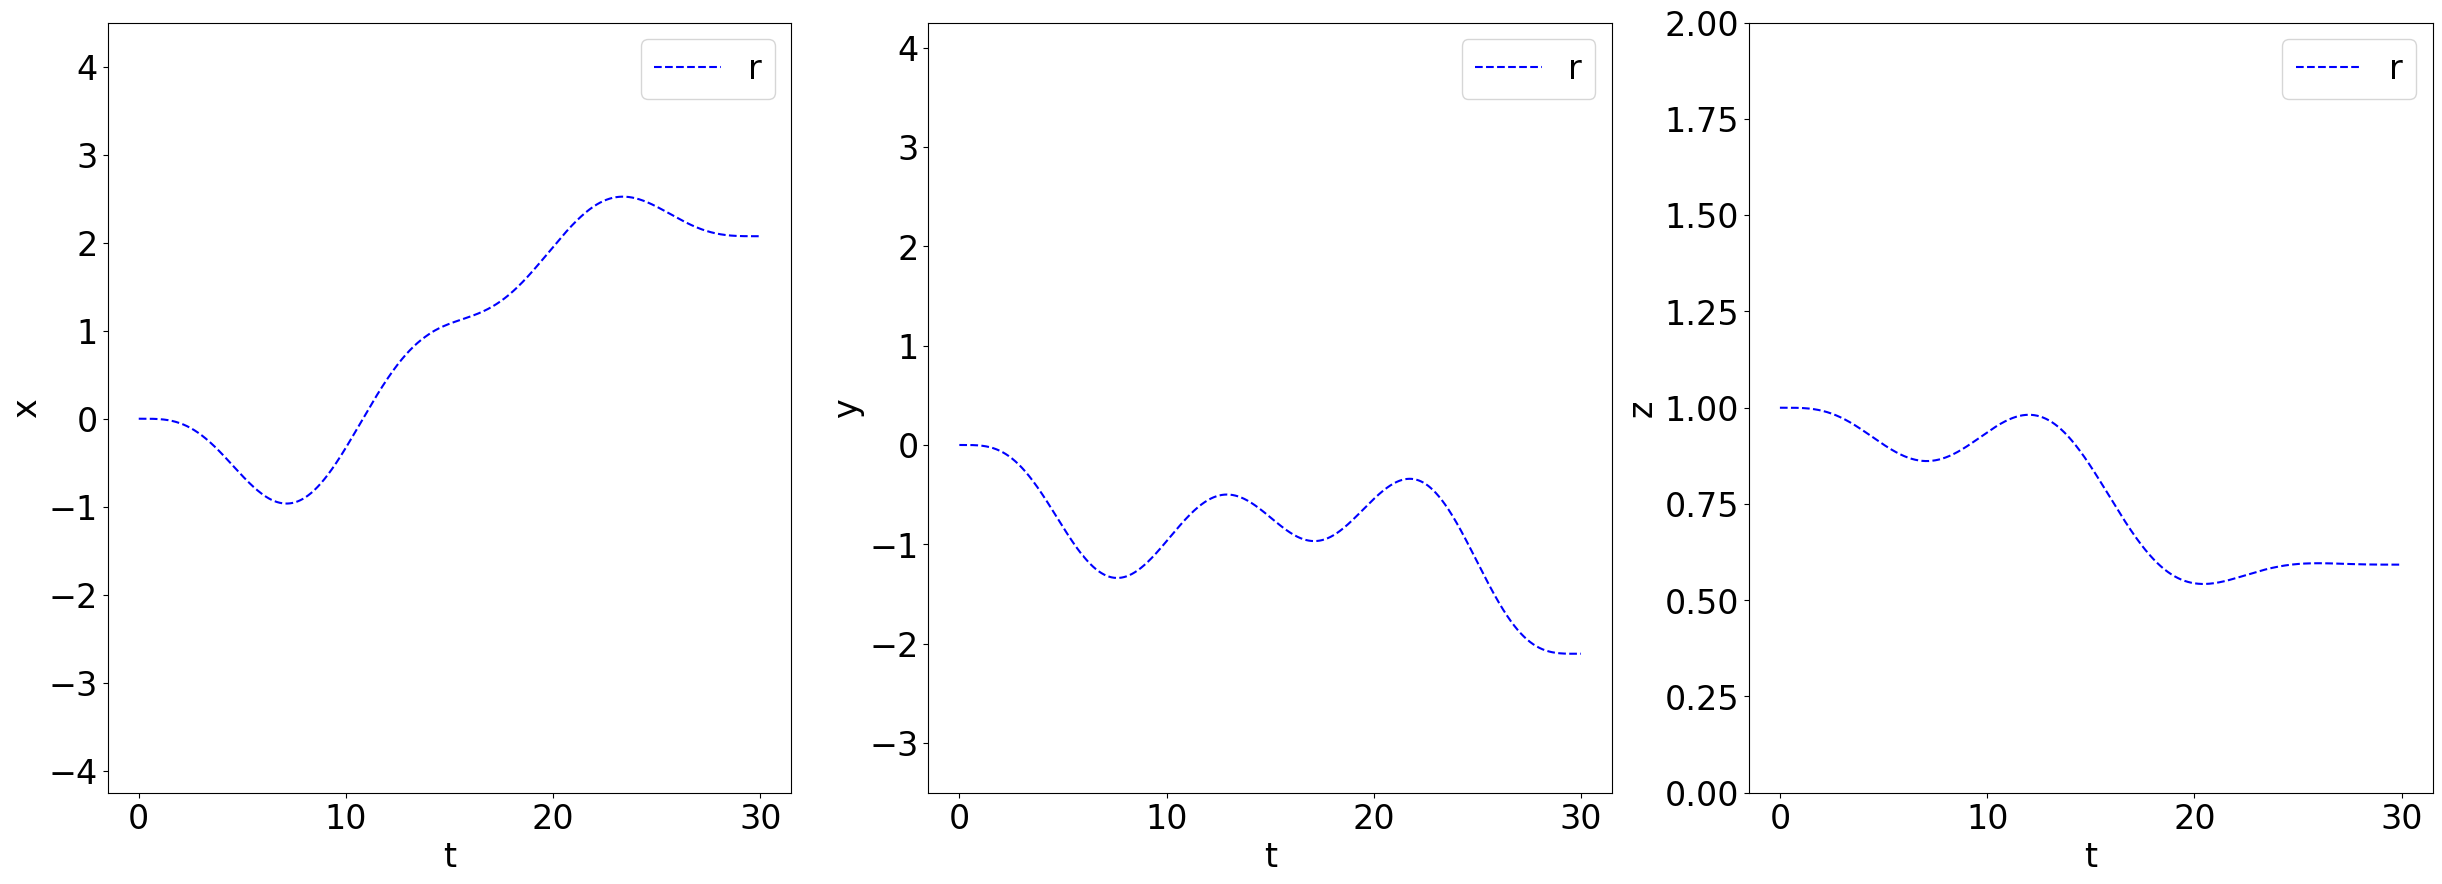

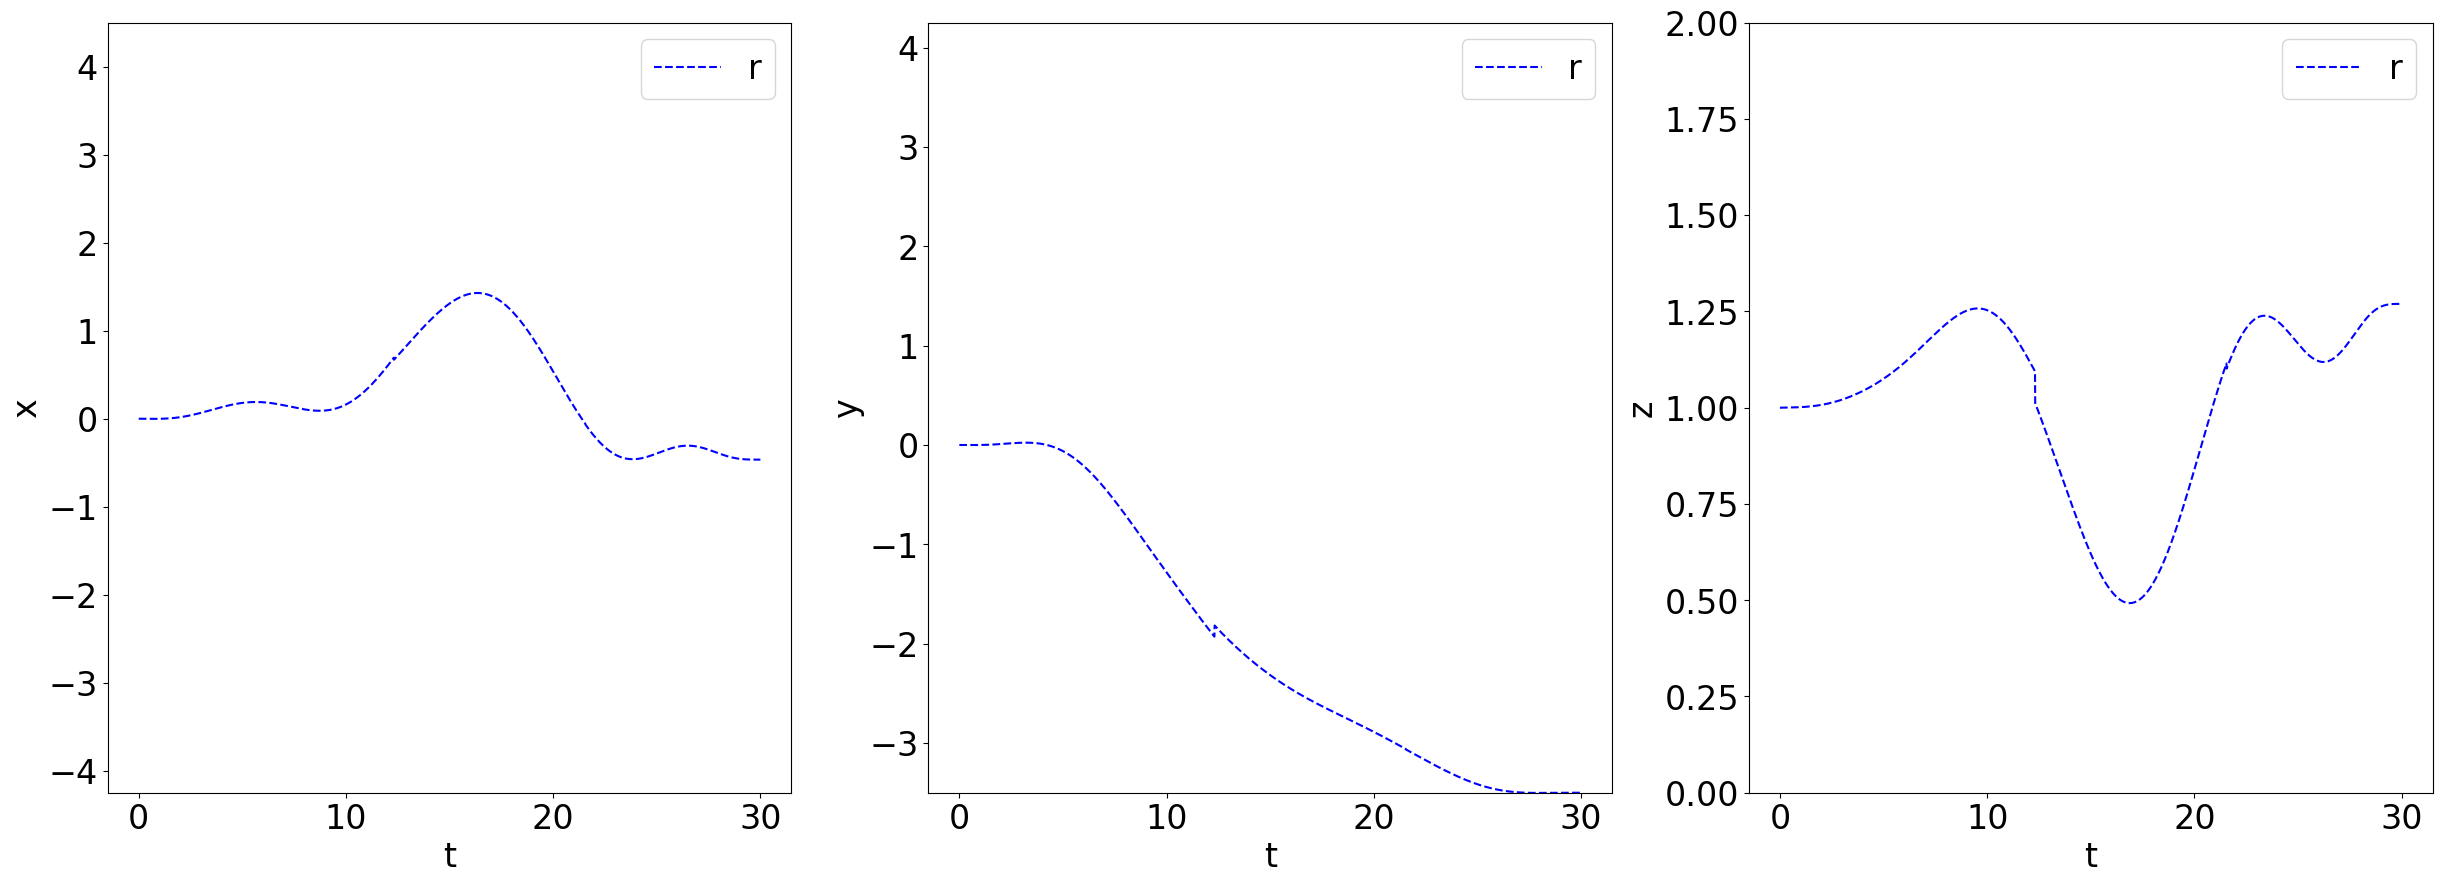

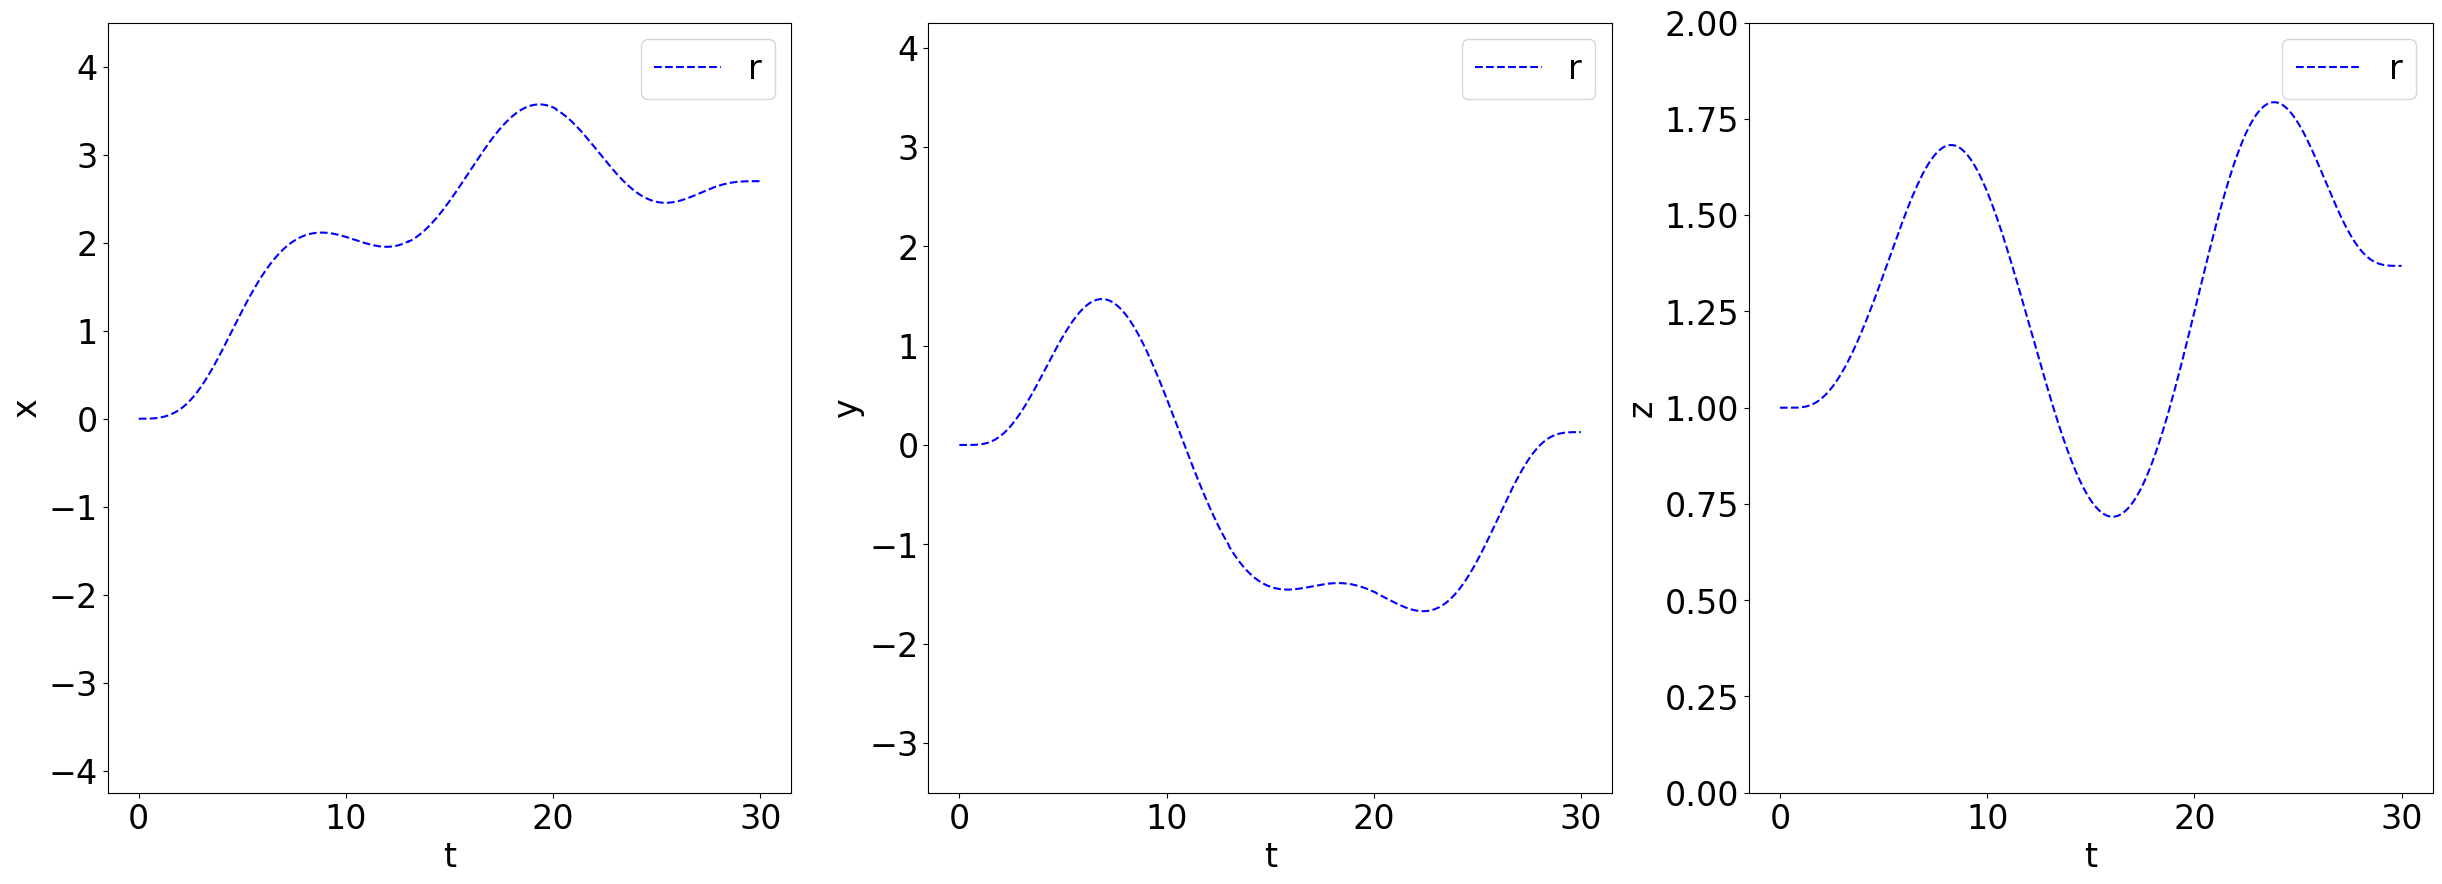

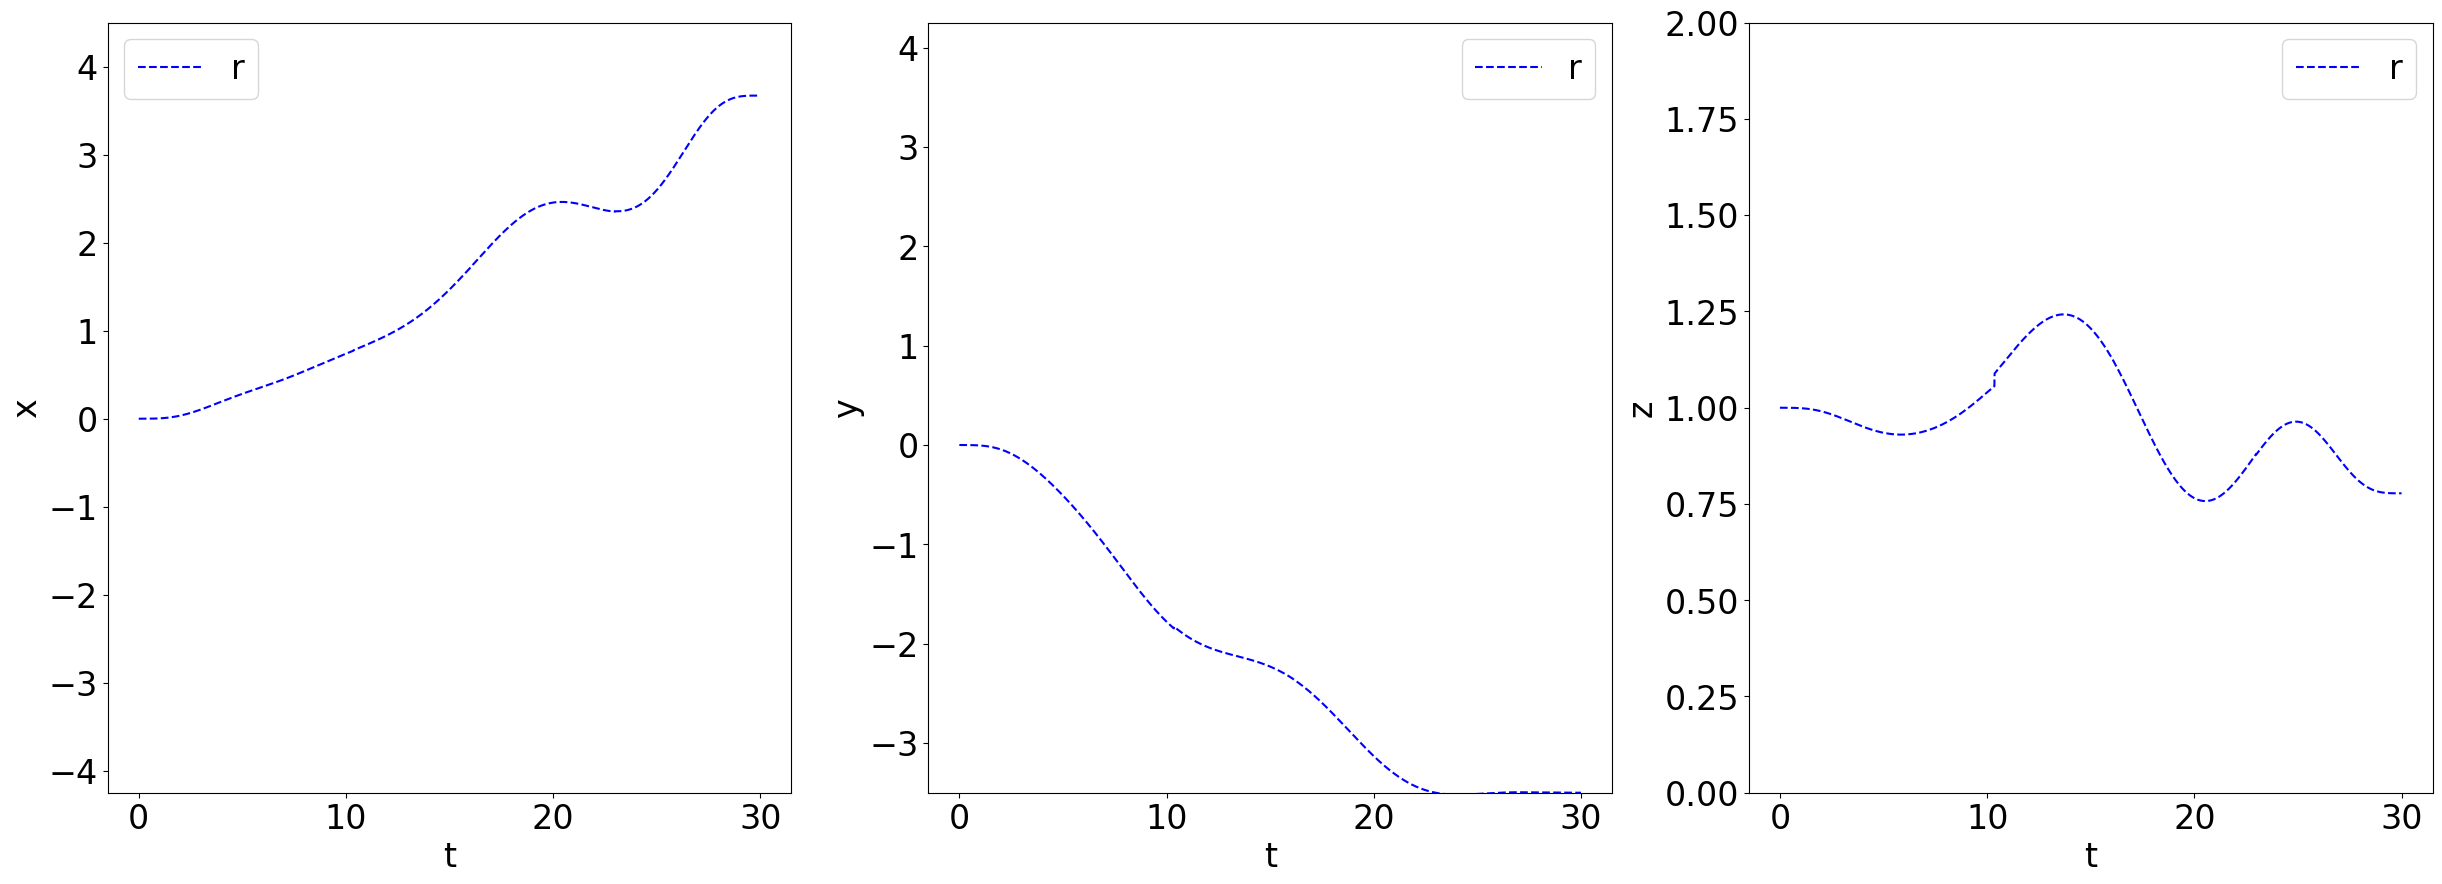

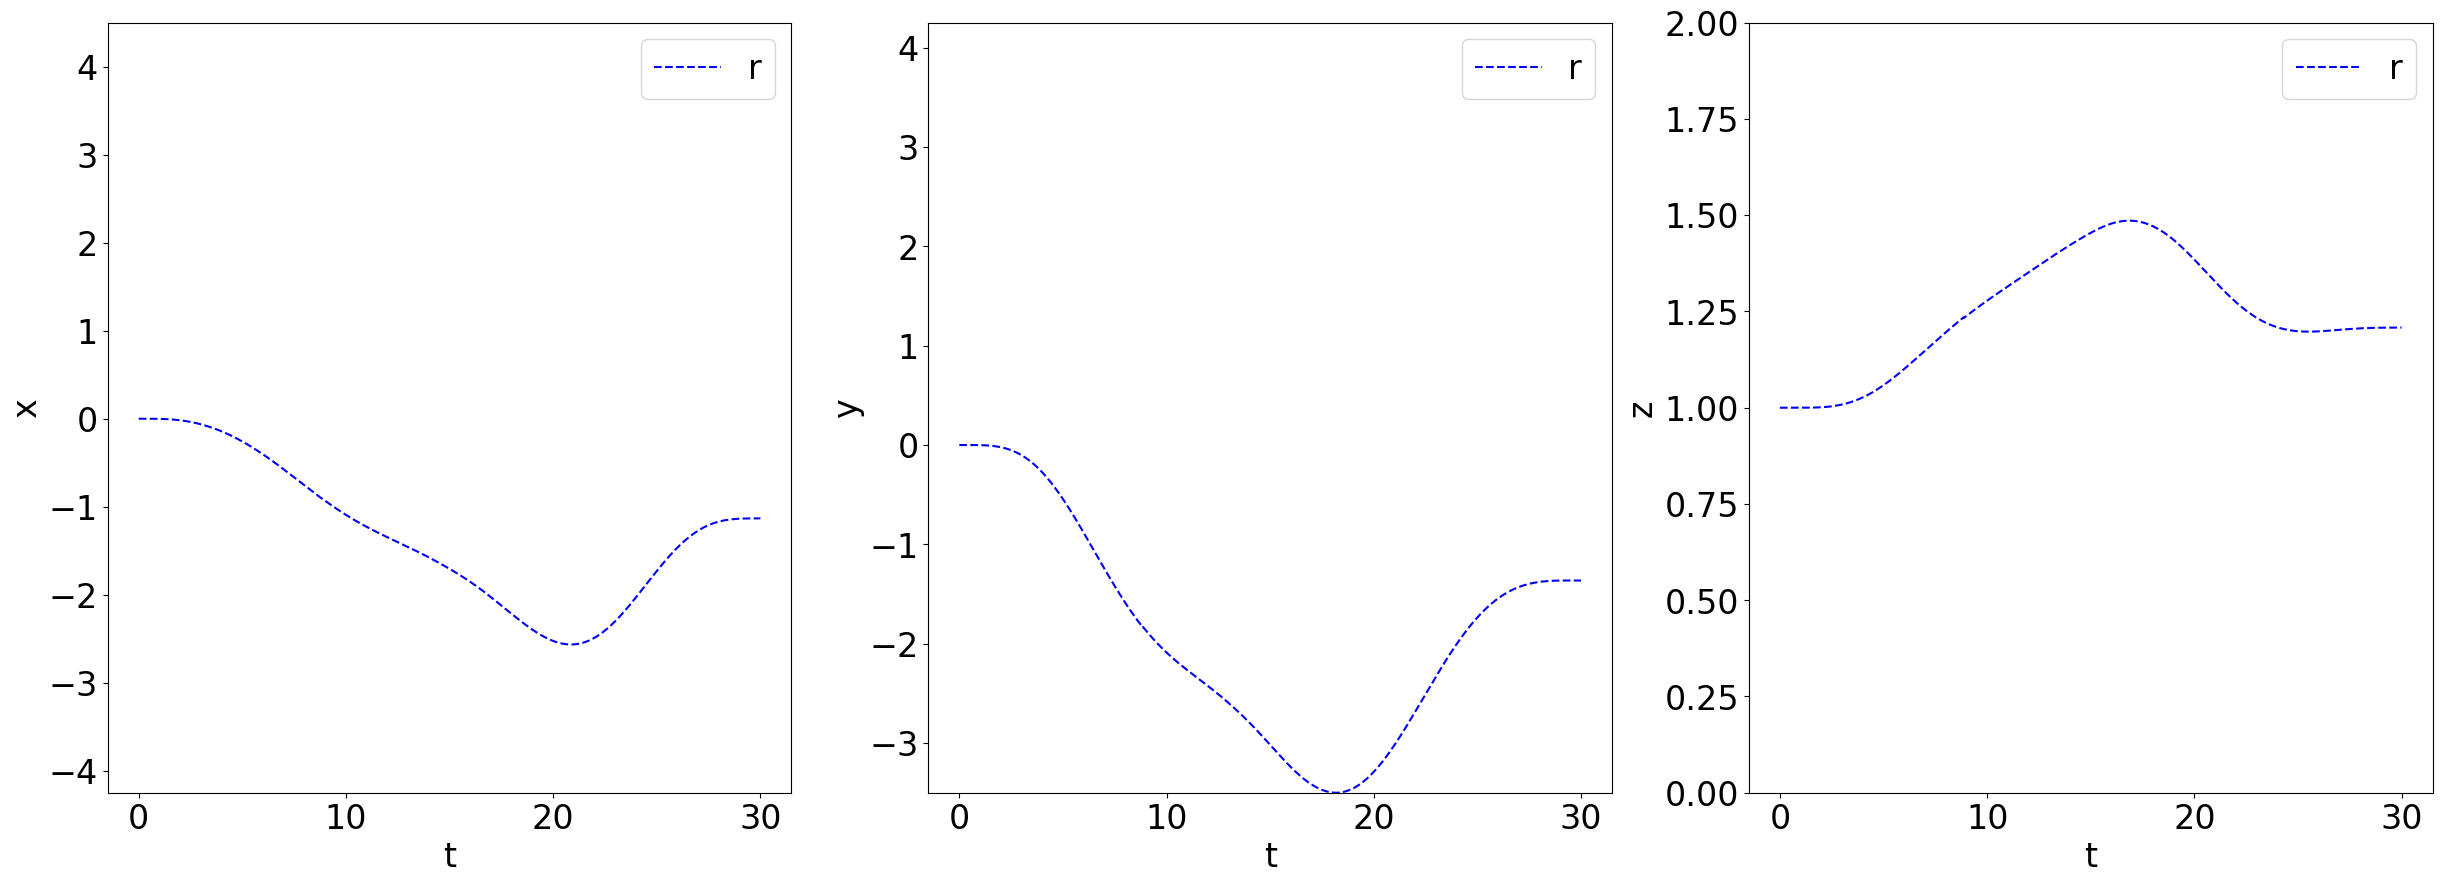

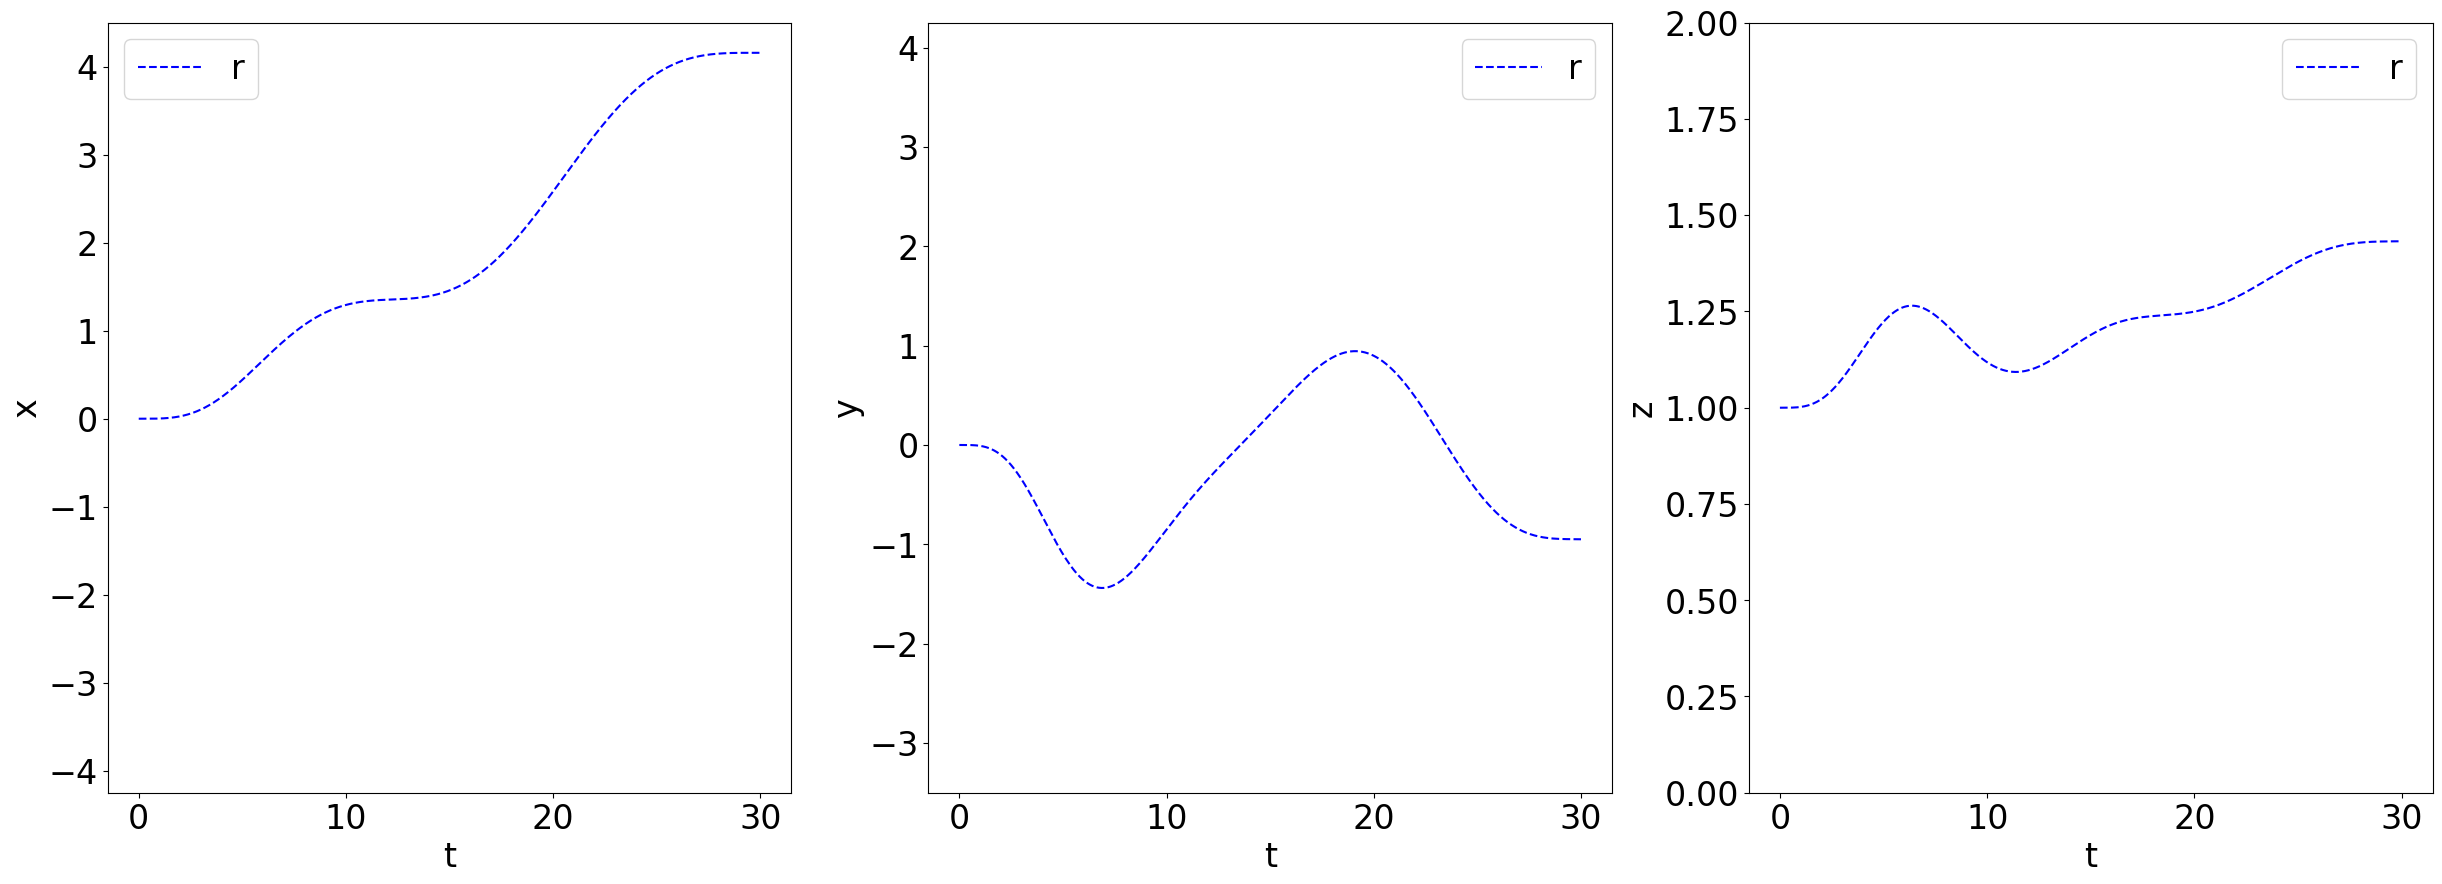

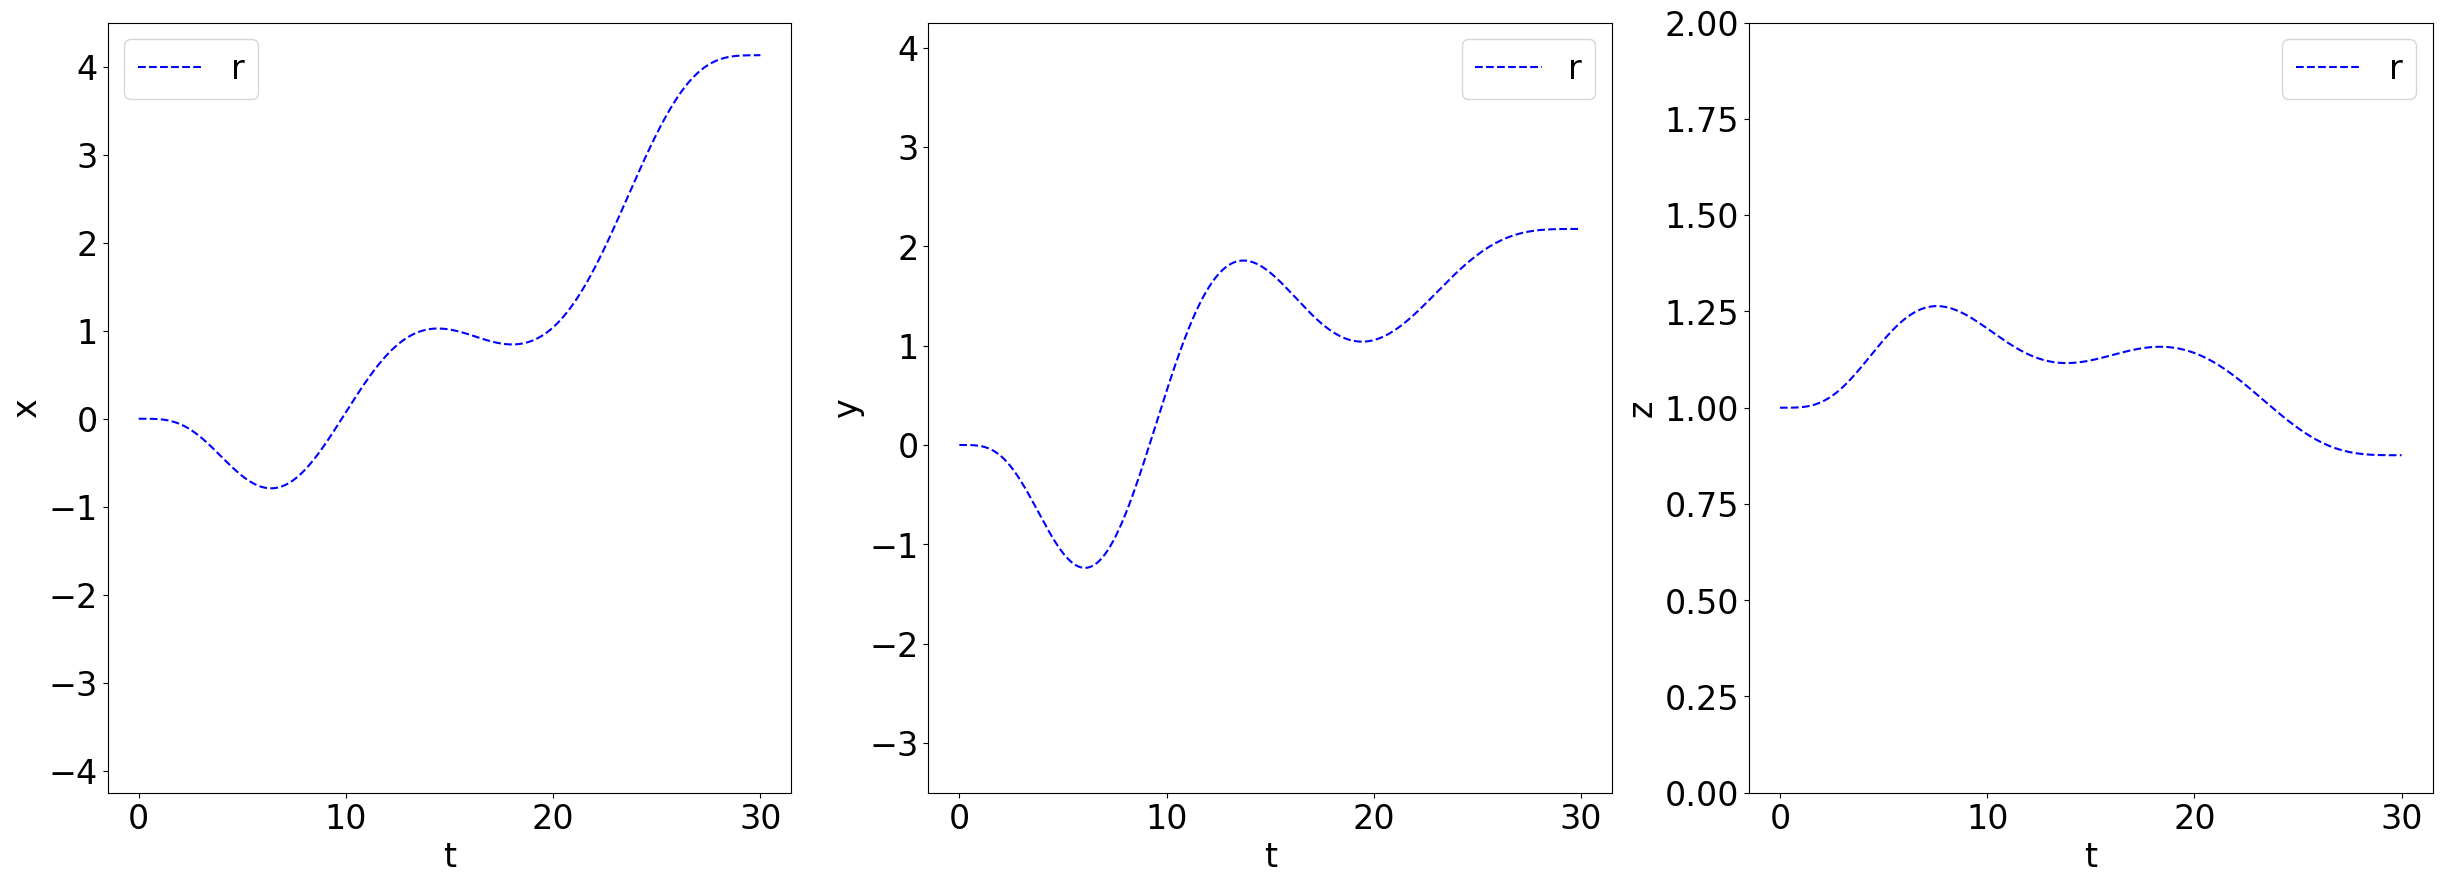

In [4]:
def plot_r(ts, r, traj=0):
    xmin_ = -4.25
    xmax_ = 4.5
    ymin_ = -3.5
    ymax_ = 4.25
    zmin_ = 0.0
    zmax_ = 2.0
    y_limits = [(xmin_, xmax_), (ymin_, ymax_), (zmin_, zmax_)]
    fig, ax = plt.subplots(1, 3, figsize=(30, 10))
    ax[0].plot(ts, r[traj, :, 0], 'b--', label='r')
    ax[0].set_ylabel('x')
    ax[0].set_xlabel('t')
    ax[0].set_ylim(*y_limits[0])
    ax[0].legend()

    ax[1].plot(ts, r[traj, :, 1], 'b--', label='r')
    ax[1].set_ylabel('y')
    ax[1].set_xlabel('t')
    ax[1].set_ylim(*y_limits[1])
    ax[1].legend()

    ax[2].plot(ts, r[traj, :, 2], 'b--', label='r')
    ax[2].set_ylabel('z')
    ax[2].set_xlabel('t')
    ax[2].set_ylim(*y_limits[2])
    ax[2].legend()

# i = 5
# print('t:', t_knots[i])
# print('x:', knots[0][i])
# print('y:', knots[1][i])
# print('z:', knots[2][i])
# plot_r(ts, r, i)

for i in range(50):
    # print('t:', t_knots[i])
    # print('x:', knots[0][i])
    # print('y:', knots[1][i])
    # print('z:', knots[2][i])
    plot_r(ts, r, i)